# Ionization and Thermal History

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

## Notebook Initialization

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc_file('matplotlibrc')


import numpy as np
from scipy.interpolate import interp1d

import darkhistory.physics as phys
import darkhistory.history.tla as tla

## Three-Level Atom

The three-level atom (TLA) model is a set of coupled differential equations governing the ionization and thermal history of the universe. In it's original form as proposed by Peebles <cite data-cite="6232408/DVUAUQGP"></cite> and Zel'dovich et al. <cite data-cite="6232408/VV5Y8E88"></cite>, it assumes that the universe is entirely composed of hydrogen atoms with three levels: $n = 1$, $n = 2$ and the continuum, and that the only additional source of photons is the CMB blackbody radiation. A more recent explanation of this model is given in <cite data-cite="6232408/HNJVBBSZ"></cite>.

The TLA has been successfully modified to include dark matter energy injection <cite data-cite="6232408/SPGPKD33"></cite>. This is done by introducing the ratio $f_c(z)$ of the energy injection rate due to DM annihilation/decay to the energy deposition rate into the IGM from these injections, in a given channel $c$ (ionization of hydrogen, excitation of hydrogen, or collisional heating of the IGM):

$$ \left( \frac{dE}{dV \, dt} \right)_{\text{dep.}, c} = f_c(z) \left( \frac{dE}{dV \, dt} \right)_{\text{inj.}, c} $$

Calculating $f_c(z)$ for use in these equations is one of the key goals of DarkHistory.

The TLA with DM is included in DarkHistory and reionization can be solved to give the ionization and thermal history of the universe with DM energy injection and a reionization model. Our TLA solver includes a fudge factor in the recombination coefficient to the $n=2$ levels recommended by <cite data-cite="6232408/HNJVBBSZ"></cite> for good agreement with HyRec. Furthermore, we solve the TLA equations in terms of $y \equiv \text{arctanh}[2(x_e - 0.5)]$, which makes the differential equations less stiff, and also guarantees that the ionization fraction $x_e$ is bounded between 0 and 1. 

---

## `history.tla.get_history`

The function that solves the TLA is `tla.get_history`.

We will first solve the equation with no dark matter injection and no reionization model.

First, we initialize the redshift abscissa. This must be defined in decreasing redshift. Note that the transfer functions used in calculating $f_c(z)$ only span a redshift range of $4 \leq 1+z \leq 3000$. We recommend that integration of the TLA should begin no earlier than $1+z = 3000$ for the default solver parameters that we use. 

In this example, we solve the TLA from $1+z = 3000$ to $1+z = 1$. 

In [3]:
rs_vec_std = np.flipud(1 + np.arange(3000))

Next, we set the initial conditions. This is a list of four floats ($T_m$, $x_\mathrm{HII}$, $x_\mathrm{HeII}$, $x_\mathrm{HeIII}$). Well before recombination, we can safely take $T_m = T_\mathrm{CMB}$ and $x_\mathrm{HII} = 1$. For this version of the code, we always take $x_\mathrm{HeII} = x_\mathrm{HeIII} = 0$, with no evolution in these fractions until reionization begins (note that the code actually sets any electron fraction that is specified to be 0 to a small number `1. - 1e-12` internally, so that $y$ remains finite).

In [4]:
init_cond = [phys.TCMB(3000), 1, 0, 0]

We are now ready to call `tla.get_history`. The function is called using the following syntax:

```python
def get_history(
    init_cond, f_H_ion_in, f_H_exc_in, f_heating_in,
    dm_injection_rate_in, rs_vec, reion_switch=True, reion_rs=None,
    photoion_rate_func=None, photoheat_rate_func=None,
    mxstep = 1000
)
```

The arguments are as follows: 

1. `init_cond` is the initial conditions which we have defined above.

2. `f_H_ion_in`, `f_H_exc_in`, `f_heating_in` and `dm_injection_rate_in` are all parameters related to dark matter energy injection; we set them to zero in this part of the example. 

3. `rs_vec_std` is the redshift array over which to solve the TLA. Note that numerical errors may be reported by the ODE solver if `rs_vec_std` is spaced too widely. 

4. `reion_switch` determines if a reionization model should be used, and `reion_rs`, `photoion_rate_func` and `photoheat_rate_func` are parameters related to reionization. We shall set `reion_switch=False` for now.

5. Finally, `mxstep` is the maximum number of steps that the integrator can take per integration point. Increasing this may allow the solver to overcome integration errors, while decreasing this value may speed up the integration.

Now, let's call the function!

In [5]:
soln = tla.get_history(init_cond, 0., 0., 0., 0., rs_vec_std, reion_switch=False)

The solution is returned as an array with dimensions `(rs_vec_std.size, 4)`. Each column corresponds to the solution for ($T_m$ in eV, $x_\mathrm{HII}$, $x_\mathrm{HeII}$, $x_\mathrm{HeIII}$. Let's plot the solution. 

[1, 3000.0, 0.0001, 2]

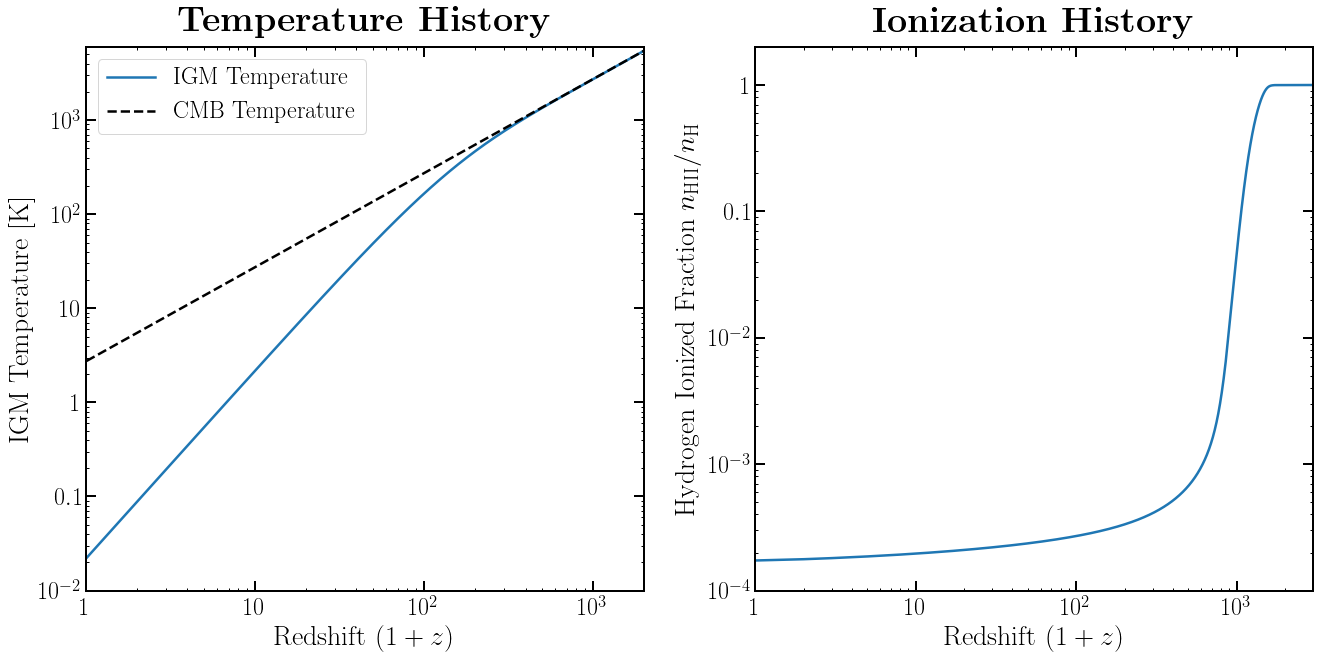

In [6]:
soln_Tm = soln[:,0]/phys.kB
soln_xHII = soln[:,1]

plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)

T_IGM, = plt.plot(rs_vec_std, soln_Tm, label='IGM Temperature')
T_CMB, = plt.plot(rs_vec_std, phys.TCMB(rs_vec_std)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB])


plt.title(r'\bf{Temperature History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('IGM Temperature [K]')
plt.axis([1, 2e3, 1e-2, 6e3])

ax = plt.subplot(1,2,2)

plt.plot(rs_vec_std, soln_xHII)

ax.set_xscale('log')
ax.set_yscale('log')


plt.title(r'\bf{Ionization History}')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Hydrogen Ionized Fraction $n_\mathrm{HII}/n_\mathrm{H}$')
plt.axis([1, 3e3, 1e-4, 2])

## Reionization

A default reionization model is included with `DarkHistory`. This model combines the fiducial photoionization and photoheating rates provided in <cite data-cite="6232408/MJ7LY7BF"></cite> with rates for collisional ionization, collisional excitation, recombination cooling and Bremsstrahlung cooling given in <cite data-cite="6232408/4FF4XZAM"></cite>, in order to obtain the ionization/temperature change during reionization. Although the results of <cite data-cite="6232408/MJ7LY7BF"></cite> are meant for large scale simulations of reionization, `DarkHistory` is able to obtain excellent agreement with their fiducial temperature/ionization history using this method. 

The code for the model can be found in `darkhistory.history.reionization`.

To obtain the temperature/ionization history with the default reionization model, simply specify `reion_switch = True`.

In [7]:
# Initialize the redshift at which we want the solution. 
rs_vec = np.flipud(1 + np.arange(0, 3000, 0.1))

# Set the initial conditions. The initial temperature is the CMB temperature, 
# and the initial free electron fraction is 1. 
init_cond = [phys.TCMB(3000), 1, 0, 0]

# Obtain the solution.
soln_with_reion = tla.get_history(init_cond, 0., 0., 0., 0., rs_vec, reion_switch=True)

16.1 0.0004753318705879875 0.0002048586427219612 9.999986949615902e-13 9.999986949615902e-13
16.099999999997696 0.0004753318707285515 0.0002048586427533805 1.003308547353754e-12 9.999986949615902e-13
16.099999999997696 0.0004753318707285515 0.0002048586427533805 1.00330160845985e-12 9.999986949615902e-13
16.09999999999948 0.0004753318706198928 0.00020485864272906662 1.0007480955032122e-12 9.999986949615902e-13
16.09999999999948 0.0004753318706198928 0.00020485864272906662 1.0007480955032122e-12 9.999986949615902e-13
16.099999999998957 0.0004753318706517981 0.00020485864273622756 1.001504434938738e-12 9.999986949615902e-13
16.099999999998957 0.0004753318706517981 0.00020485864273622756 1.0014974960448342e-12 9.999986949615902e-13
16.09999999999791 0.00047533187071560867 0.0002048586427504384 1.003003236021982e-12 9.999986949615902e-13
16.09999999999791 0.00047533187071560867 0.0002048586427504384 1.003003236021982e-12 9.999986949615902e-13
16.09999999999686 0.0004753318707794192 0.00020

16.099999982008345 0.00047533296695564047 0.00020485888770055416 2.6794899632420766e-11 9.999986949615902e-13
16.099999982008345 0.00047533296695564047 0.00020485888770055416 2.6794878815739054e-11 9.999986949615902e-13
16.09999998116762 0.00047533301818716644 0.00020485889914800826 2.8000247953574586e-11 9.999986949615902e-13
16.09999998116762 0.00047533301818716644 0.00020485889914800826 2.800023407578678e-11 9.999986949615902e-13
16.099999980326896 0.0004753330694186924 0.00020485891059546235 2.920560321362231e-11 9.999986949615902e-13
16.099999980326896 0.0004753330694186924 0.00020485891059546235 2.92055893358345e-11 9.999986949615902e-13
16.099999979211496 0.00047533313738820214 0.00020485892578298026 3.0804768458292386e-11 9.999986949615902e-13
16.099999979211496 0.00047533313738820214 0.00020485892578298026 3.0804747641610675e-11 9.999986949615902e-13
16.099999978096097 0.0004753332053577119 0.00020485894097044266 3.2403954519644174e-11 9.999986949615902e-13
16.099999978096097 

16.099999672923584 0.0004753518017885658 0.00020486309626238652 4.699332659119371e-10 9.999986949615902e-13
16.099999672923584 0.0004753518017885658 0.00020486309626238652 4.699330369284382e-10 9.999986949615902e-13
16.099999659024125 0.0004753526487859839 0.00020486328552032917 4.898610336812048e-10 9.999986949615902e-13
16.099999659024125 0.0004753526487859839 0.00020486328552032917 4.898608463310694e-10 9.999986949615902e-13
16.099999640673904 0.0004753537670014827 0.00020486353538073931 5.161701135958374e-10 9.999986949615902e-13
16.099999640673904 0.0004753537670014827 0.00020486353538073931 5.161697458344605e-10 9.999986949615902e-13
16.099999622323683 0.0004753548852169858 0.00020486378524114945 5.424793531050298e-10 9.999986949615902e-13
16.099999622323683 0.0004753548852169858 0.00020486378524114945 5.424786453378516e-10 9.999986949615902e-13
16.099999603973462 0.00047535600343249313 0.0002048640351015596 5.687880513804977e-10 9.999986949615902e-13
16.099999603973462 0.0004753

16.099995857035577 0.0004755843323322999 0.0002049150542191569 5.940819280958465e-09 9.999986949615902e-13
16.099995857035577 0.0004755843323322999 0.0002049150542191569 5.9408172756181266e-09 9.999986949615902e-13
16.0999956387766 0.0004755976324866992 0.00020491802608257892 6.25374181606464e-09 9.999986949615902e-13
16.0999956387766 0.0004755976324866992 0.00020491802608257892 6.253737756811706e-09 9.999986949615902e-13
16.099995420517626 0.0004756109326417004 0.0002049209979462785 6.566666037322033e-09 9.999986949615902e-13
16.099995420517626 0.0004756109326417004 0.0002049209979462785 6.566658390660951e-09 9.999986949615902e-13
16.09999520225865 0.0004756242327973035 0.0002049239698101446 6.879584464603017e-09 9.999986949615902e-13
16.09999520225865 0.0004756242327973035 0.0002049239698101446 6.879579197982544e-09 9.999986949615902e-13
16.099994983999675 0.0004756375329535084 0.00020492694167423275 7.192504307418357e-09 9.999986949615902e-13
16.099994983999675 0.0004756375329535084

16.09962396847669 0.0004982471613370983 0.00020997908751951844 5.391547700517307e-07 1.0007897288666356e-12
16.09962396847669 0.000498247161337098 0.00020997908751951844 5.391545163935252e-07 1.0007897288666356e-12
16.099608155245637 0.0004992108558278385 0.0002101944313870896 5.61829157190441e-07 1.0008591178056747e-12
16.099608155245637 0.0004992108558278383 0.0002101944313870896 5.618289585507252e-07 1.0008591178056747e-12
16.099592342014585 0.0005001745534781759 0.00021040977639341651 5.845036767371248e-07 1.0009285067447138e-12
16.099592342014585 0.0005001745534781758 0.00021040977639341651 5.845035186274883e-07 1.0009285067447138e-12
16.099571791859198 0.0005014269358059249 0.00021068963066439572 6.139708035382552e-07 1.0010256512593685e-12
16.099571791859198 0.0005014269358059245 0.00021068963066439572 6.139704925162137e-07 1.0010256512593685e-12
16.09955124170381 0.0005026793234697607 0.00021096948685855876 6.434382465031474e-07 1.001129734667927e-12
16.09955124170381 0.0005026

16.091434784435247 0.0009977378024055427 0.00032165127786748515 1.229716671239528e-05 1.4167347850424505e-12
16.091086010246215 0.0010190297435354334 0.00032641412259470926 1.2798635004043768e-05 1.4514292545619867e-12
16.091086010246215 0.001019029743535362 0.00032641412243289425 1.2798631328823917e-05 1.4514292545619867e-12
16.090737236057183 0.0010403232234863697 0.0003311775199479339 1.3300155733142471e-05 1.4875115028623043e-12
16.090737236057183 0.0010403232234863177 0.00033117751979788723 1.3300152784133379e-05 1.4875115028623043e-12
16.09028830629453 0.0010677337006809427 0.00033730960987976566 1.394578222123355e-05 1.536000493462808e-12
16.09028830629453 0.0010677337006808187 0.00033730960955175027 1.3945776573084934e-05 1.536000493462808e-12
16.089839376531874 0.0010951467276627013 0.0003434426157692405 1.4591504884343964e-05 1.5868070746272167e-12
16.089839376531874 0.0010951467276624177 0.0003434426151314729 1.4591494676571837e-05 1.5868070746272167e-12
16.08939044676922 0.

15.799698738338101 0.019352561638221015 0.004501715861641331 0.0004518948209957588 5.643674416688782e-10
15.799698738338101 0.019352561638570367 0.004501716313156989 0.00045189488821294893 5.643675943245441e-10
15.787057585581572 0.020172903156303042 0.004691927373379423 0.0004718750129754992 6.152708412199281e-10
15.787057585581572 0.020172903156496565 0.004691927716522826 0.0004718750631919205 6.152709730589123e-10
15.774416432825042 0.020995352707248012 0.004882914580483011 0.0004919346858620333 6.685881223655876e-10
15.774416432825042 0.020995352707457542 0.004882914846212227 0.0004919347242379815 6.685882125712084e-10
15.757160507652381 0.02212145476213876 0.005144880252968664 0.0005194460719928212 7.453139355684257e-10
15.757160507652381 0.02212145476268613 0.005144880888627412 0.0005194461625015953 7.453141853686063e-10
15.73990458247972 0.023251501171064615 0.005408302959993505 0.0005471066773872629 8.266553205849014e-10
15.73990458247972 0.023251501173008175 0.0054083046111224

13.651678033355047 0.19156665699014364 0.050940945792238845 0.005293032401968878 7.611983761368624e-08
13.588240444833668 0.19777924402461486 0.05286483046756013 0.0054921876827693505 8.194716198672847e-08
13.588240444833668 0.19777924380417813 0.05286483627265948 0.005492188292603027 8.194718248422106e-08
13.49217208898416 0.20733094376574437 0.055855752865806685 0.005801550063811077 9.142972298703533e-08
13.49217208898416 0.20733094305927915 0.05585576986907553 0.005801551846157056 9.142978651260902e-08
13.396103733134654 0.21705740434095636 0.05894268251400819 0.006120519426049395 1.0175730943279282e-07
13.396103733134654 0.21705740397656859 0.05894267869754699 0.0061205190227072714 1.0175729376477038e-07
13.300035377285147 0.22696073144698414 0.06212872480174336 0.006449379935005439 1.1299305661960357e-07
13.300035377285147 0.2269607314649277 0.062128693858896133 0.006449376696122201 1.1299292589084242e-07
13.20396702143564 0.23704298591875822 0.06541704329603754 0.0067884186216318

12.099943758273243 0.3708978389692636 0.11332589280705213 0.011669003952169046 3.860274656250495e-07
12.095488451434466 0.37150975792389807 0.11356262261692596 0.011692855143643568 3.877419124387327e-07
12.095488451434466 0.3715097419111991 0.11356262132283157 0.01169285477180139 3.877419800166204e-07
12.09103314459569 0.3721222123208175 0.11379974408567922 0.0117167421450808 3.8946401363648686e-07
12.09103314459569 0.3721222123465088 0.11379974422891975 0.011716742160928061 3.8946401306055867e-07
12.086577837756913 0.37273525026335513 0.11403726198376779 0.011740666148698668 3.91193597411299e-07
12.086577837756913 0.3727352502880552 0.11403726212700649 0.011740666164544906 3.911935968353708e-07
12.042024769369137 0.3788968527159469 0.1164342922858374 0.011981929408437272 4.089117368669126e-07
12.042024769369137 0.3788968519405144 0.1164342979427086 0.011981930033835152 4.0891172079643434e-07
11.997471700981361 0.3851152535104767 0.11887151326251938 0.012226907347096229 4.2742033751902

9.92448291188474 0.7478534412345936 0.29724277620653816 0.02918191206860728 4.495825941537579e-06
9.942217124378436 0.7442866128840083 0.29495909696228395 0.028976581043445544 4.381739129151463e-06
9.942217124378436 0.7443117948281867 0.29496671865993707 0.028977239503217962 4.3829830808708725e-06
9.942217124378436 0.7443111831414582 0.2949666359291876 0.02897723252681714 4.382941266541096e-06
9.98504588740862 0.7357237072612239 0.28954102563163353 0.028488161324013862 4.12390388617595e-06
9.98504588740862 0.7357242775690523 0.2895411978150283 0.028488176243107663 4.1239305619902855e-06
9.995753078166167 0.733573710658489 0.28820105245371985 0.02836711548693653 4.062141869383418e-06
9.994682359090413 0.7337888705633804 0.2883347780880293 0.02837919998423319 4.06827022042533e-06
9.994682359090413 0.7337888394102353 0.2883347991846269 0.028379201969635365 4.068271426981018e-06
9.995753078166167 0.733573710658489 0.28820105245371985 0.02836711548693653 4.062141869383418e-06
9.995646006258

9.071819580772058 0.8848820672449106 0.43048872091467116 0.04064720793643294 1.7685817695491102e-05
9.071819580772058 0.8848820677103675 0.4304887209506777 0.04064720793894168 1.7685817660227643e-05
9.067861217963882 0.8852903206427607 0.4312248796196249 0.04070769025968998 1.7808294085826237e-05
9.067861217963882 0.8852906334009208 0.4312249945290036 0.04070769973617834 1.7808310548213246e-05
9.067861217963882 0.8852903194052345 0.4312248795235882 0.04070769025300179 1.7808294180299278e-05
9.067861217963882 0.8852906965787043 0.43122501755893977 0.040707701634822416 1.7808313793020447e-05
9.071027908210423 0.884963899240664 0.4306358665155679 0.040659299821655004 1.7710240992625803e-05
9.071027908210423 0.8849638992932013 0.4306358665196114 0.040659299821936334 1.771024098868451e-05
9.070236235648789 0.8850456403860287 0.43078305518879667 0.04067139399795274 1.7734700239274703e-05
9.070236235648789 0.8850456404162286 0.430783055191112 0.040671393998113654 1.7734700237019563e-05
9.0694

8.223219334583396 0.9573585599939312 0.6250777201758301 0.05563181275685228 8.71337530148758e-05
8.223219334583396 0.9573585596461777 0.6250777201772734 0.05563181275706718 8.713375301848403e-05
8.215856835844468 0.9579986532244601 0.6271200977515881 0.05577914477900418 8.842435194499759e-05
8.215856835844468 0.9579986531195877 0.6271200977541759 0.05577914477851724 8.84243519466213e-05
8.20849433710554 0.958649942015105 0.6291730232595591 0.05592701955155793 8.973605588350614e-05
8.20849433710554 0.9586499419153321 0.6291730232620728 0.05592701955104793 8.973605588516453e-05
8.171780344010392 0.9620467196073125 0.6395642207676484 0.056672118785098945 9.66042174711107e-05
8.171780344010392 0.9620467021025042 0.6395642212285456 0.05667211866748012 9.660421783800471e-05
8.135066350915244 0.9656475606892815 0.6502021507183899 0.05742894115639524 0.00010405076388913387
8.135066350915244 0.9656475544230217 0.650202151034276 0.05742894079495538 0.00010405076455412277
8.098352357820096 0.9693

7.38841134584101 1.078746973489064 0.9122607442857944 0.07385216059186689 0.0005395324488510905
7.38841134584101 1.0787469860315648 0.9122607356901945 0.07385215962518231 0.0005395324511241195
7.374997281645029 1.0822133221030532 0.9176275106882765 0.0741328049596654 0.0005580412316861655
7.374997281645029 1.0822133334414241 0.9176275007408672 0.07413280412195017 0.000558041234098472
7.357558969291173 1.0866913093971229 0.9245266738626698 0.07448803913225151 0.0005832561084597523
7.357558969291173 1.0866913325409397 0.9245266482136425 0.07448803779978808 0.000583256114630705
7.340120656937317 1.0910574353603304 0.9312860424014557 0.0748293073105056 0.000609832397613759
7.340120656937317 1.0910574479574735 0.9312860176441626 0.07482930785271864 0.000609832401898075
7.322682344583461 1.0952280046852658 0.9378494949096625 0.07515342847664794 0.0006378336616846836
7.322682344583461 1.09522797413581 0.9378495049419042 0.07515343322646248 0.0006378336527574635
7.305244032229605 1.09912351642

7.082437609876245 1.1113335448815764 0.9938614995057724 0.07735774261896447 0.001196233879855936
7.080505398042009 1.1112380815839622 0.9941284003820132 0.07736528968266332 0.0012017848697040145
7.080505398042009 1.1112380815463234 0.9941284003956307 0.0773652896827596 0.0012017848697033276
7.078573186207772 1.1111292399011412 0.9943877862664872 0.07737253362315169 0.0012073427022501124
7.078573186207772 1.1111292397460257 0.99438778633241 0.07737253362152957 0.001207342702249023
7.076640974373536 1.1110065370947608 0.99463937144392 0.07737946343443494 0.0012129073673987495
7.076640974373536 1.111006536897995 0.9946393715368782 0.07737946343063251 0.001212907367398576
7.0747087625392995 1.1108695647423523 0.994882910973225 0.07738606961096726 0.0012184788539059271
7.0747087625392995 1.1108695645319617 0.9948829110775799 0.0773860696067748 0.0012184788539053582
7.072776550705063 1.1107179897293404 0.9951182018010798 0.07739234415730314 0.0012240571495195224
7.072776550705063 1.110717989

6.92283505125687 1.0748696162750353 0.9997524715081977 0.07723967080148654 0.0016772302414999121
6.9218853536340115 1.074594715192954 0.9997563568677343 0.07723707210182965 0.0016802309569224974
6.9218853536340115 1.074594716300423 0.9997563568905141 0.0772370721671772 0.001680230962781637
6.920979916710874 1.0743324841177153 0.99976000280834 0.07723458786180248 0.0016830934338818299
6.920979916710874 1.0743324850864506 0.9997600028282199 0.07723458791914922 0.001683093439070353
6.920074479787737 1.0740701152553955 0.9997635927156155 0.07723209712829737 0.0016859574775918498
6.920074479787737 1.0740701161833646 0.9997635927336759 0.07723209718231619 0.0016859574826444124
6.9191690428646 1.0738076104538499 0.9997671274962631 0.07722959996822701 0.001688823090149269
6.9191690428646 1.0738076113693347 0.9997671275139941 0.0772296000219466 0.0016888230951899036
6.918303830398467 1.0735566422583693 0.9997704545579195 0.07722720780775576 0.0016915628645267147
6.918303830398467 1.073556643064

6.873855563029084 1.0605297393052149 0.9998897773490315 0.07709763489808988 0.001834278128049184
6.873855563029084 1.0605297393504407 0.9998897773493456 0.07709763490026754 0.0018342781284759122
6.873441819058371 1.0604074823378653 0.9998905231267285 0.07709637567087158 0.0018356250418593914
6.873441819058371 1.0604074823828864 0.9998905231270402 0.07709637567304181 0.0018356250422856685
6.873036382440099 1.060287665867978 0.9998912489773089 0.07709514089980782 0.0018369452481628856
6.873036382440099 1.0602876659105736 0.9998912489776031 0.0770951409018584 0.0018369452485676799
6.872630945821827 1.060167835384468 0.9998919699589778 0.07709390531248778 0.0018382657876716696
6.872630945821827 1.0601678354264 0.9998919699592609 0.07709390531449098 0.0018382657880719327
6.872225509203555 1.0600479909704914 0.9998926861051554 0.07709266891157471 0.0018395866605670635
6.872225509203555 1.0600479910122391 0.9998926861054365 0.07709266891357108 0.0018395866609669104
6.871828220267316 1.0599305

6.809471259069695 1.0413741767513809 0.9999614968244466 0.0768927984116779 0.002048162216446013
6.809471259069695 1.0413741767513809 0.9999614968244466 0.07689279830366416 0.002048162324227179
6.809471259069695 1.0413739638309492 0.9999612645198512 0.07689277359945526 0.002048162315171624
6.809471259069695 1.0413739676680478 0.9999612640082236 0.07689277359938058 0.0020481623151757736
6.809471259069695 1.041374176546815 0.9999614968245585 0.07689279830353532 0.002048162213291446
6.809471259069695 1.0413739167173535 0.999961212706528 0.07689276810826418 0.002048162340261256
6.809471259069695 1.0413739835940352 0.9999612582166629 0.07689277193070254 0.002048162340116934
6.809471259069695 1.041374176546815 0.9999614968245585 0.07689279830353532 0.002048162213291446
6.809471259069695 1.0413741920644994 0.9999614968245585 0.07689279830353532 0.002048162213291446
6.809471259069695 1.041374176546815 0.9999614968303902 0.07689279830353532 0.002048162213291446
6.809471259069695 1.04137417654681

6.796306131457009 1.0374530241038686 0.9999616835820471 0.0768480100598368 0.0020930199452400752
6.796306131457009 1.0374530395631234 0.9999616835820471 0.0768480100598368 0.0020930199452400752
6.796306131457009 1.0374530241038686 0.9999616835878532 0.0768480100598368 0.0020930199452400752
6.796306131457009 1.0374530241038686 0.9999616835820471 0.07684801016946644 0.0020930199452400752
6.796306131457009 1.0374530241038686 0.9999616835820471 0.0768480100598368 0.0020930200546420558
6.796306131457009 1.0374530227235097 0.9999616835820941 0.07684800985457442 0.0020930201495400966
6.793124053897076 1.036512385140876 0.9999617696445935 0.0768371196258037 0.0021039275846604505
6.7899419763371425 1.0355744996757419 0.999961855590215 0.07682620348655408 0.002114860897307183
6.784401631642155 1.0339481060780107 0.999962004951723 0.076807136026877 0.0021339581771549765
6.784401631642155 1.0339481214850381 0.999962004951723 0.076807136026877 0.0021339581771549765
6.784401631642155 1.0339481060780

6.471831502225295 0.9554457392766483 0.9999696613684408 0.07558353157421231 0.0033590496851707077
6.471831502225295 0.9554457392766483 0.9999696613637379 0.07558353172356255 0.0033590496851707077
6.471831502225295 0.9554457392766483 0.9999696613637379 0.07558353157421231 0.003359049834389144
6.471831502225295 0.9554457394428257 0.9999696613640359 0.07558353140327301 0.0033590498574022284
6.46561929128005 0.9541455820708201 0.9999697374587346 0.07555567136386372 0.0033869231897588684
6.459407080334805 0.9528554040885002 0.9999698136311981 0.0755276215300657 0.00341498633205789
6.45319486938956 0.9515752066382941 0.9999698898803184 0.0754993803424843 0.003443240841789888
6.441652168120034 0.9492230199239251 0.9999700317584654 0.07544639263777655 0.0034962533399963483
6.441652168120034 0.9492230340684503 0.9999700317584654 0.07544639263777655 0.0034962533399963483
6.441652168120034 0.9492230199239251 0.9999700317631164 0.07544639263777655 0.0034962533399963483
6.441652168120034 0.94922301

6.1786504876236235 0.9050439619523679 0.9999733249627978 0.07403364954270025 0.004909573440183647
6.178558751084227 0.9050317425090809 0.9999733260260129 0.0740330792277558 0.004910143926115808
6.178558751084227 0.9050317425091645 0.999973326026019 0.07403307922778071 0.004910143926115981
6.17846701454483 0.9050195253635711 0.9999733270892468 0.07403250884381346 0.00491071448096974
6.17846701454483 0.9050195253636408 0.9999733270892504 0.07403250884383214 0.004910714480969913
6.17837519841591 0.9050072999193985 0.999973328153416 0.07403193789591228 0.004911285599849893
6.17837519841591 0.9050072999194586 0.999973328153418 0.0740319378959263 0.004911285599850067
6.1774570371267155 0.9048851720790152 0.9999733387959346 0.07402622461365957 0.004917000588149464
6.1774570371267155 0.904885185562855 0.9999733387959346 0.07402622461365957 0.004917000588149464
6.1774570371267155 0.9048851720790152 0.9999733388001187 0.07402622461365957 0.004917000588149464
6.1774570371267155 0.9048851720790152

5.890094243668898 0.8783928398619208 0.9999767510988037 0.07185163007306933 0.007092157257048197
5.889960638260309 0.8783861938541707 0.9999767527168095 0.07185041602072213 0.007093371582725043
5.889697391343952 0.8783731045585765 0.9999767559093757 0.07184802333677523 0.007095764805400424
5.889697391343952 0.8783731176473557 0.9999767559093757 0.07184802333677523 0.007095764805400424
5.889697391343952 0.8783731045585765 0.9999767559130712 0.07184802333677523 0.007095764805400424
5.889697391343952 0.8783731045585765 0.9999767559093757 0.07184802355960962 0.007095764805400424
5.889697391343952 0.8783731045585765 0.9999767559093757 0.07184802333677523 0.007095765028186894
5.889697391343952 0.8783731264951041 0.9999767559210238 0.0718480231099607 0.007095765031086693
5.889770220019208 0.878376725790005 0.9999767550265116 0.0718486853565865 0.007095102636459065
5.8895798017781065 0.878367280653654 0.9999767573469587 0.07184695408130817 0.007096834300644804
5.889309904926588 0.8783539162206

5.619736871996181 0.8771633502876076 0.9999800791403229 0.06882826912162163 0.010116092129072992
5.619666681102243 0.8771663933604554 0.9999800800502434 0.06882731902681935 0.010117042382438522
5.619666681102243 0.8771663933582574 0.9999800800484477 0.06882731902670895 0.010117042382438005
5.619596619320404 0.8771694327065075 0.999980080957092 0.06882637057776278 0.010117990990144505
5.619596619320404 0.8771694327056891 0.9999800809564614 0.06882637057768187 0.010117990990143988
5.619526557538566 0.8771724739251036 0.9999800818655402 0.0688254220269183 0.010118939700042441
5.619526557538566 0.8771724739246879 0.999980081865233 0.06882542202685692 0.010118939700041924
5.619456495756728 0.8771755170152375 0.9999800827747816 0.06882447337417849 0.01011988851214123
5.619456495756728 0.877175517014942 0.9999800827745573 0.06882447337413183 0.010119888512140705
5.61938644463857 0.8771785615127772 0.9999800836842454 0.0688235247638736 0.010120837282013451
5.61938644463857 0.8771785615125913 0

5.3600089188676145 0.9020049784753303 0.9999834078123406 0.06453218427009372 0.014412779180279774
5.3600089188676145 0.902004965034409 0.9999834078150619 0.06453218427009372 0.014412779180279774
5.3600089188676145 0.902004965034409 0.9999834078123406 0.06453218453326982 0.014412779180279774
5.3600089188676145 0.902004965034409 0.9999834078123406 0.06453218427009372 0.014412779443457615
5.359986962713084 0.9020082755550843 0.9999834080881456 0.06453174826194087 0.01441321523960079
5.359986962713084 0.9020082757670629 0.9999834080893191 0.06453174825958595 0.014413215242073462
5.359944129152669 0.9020147341506456 0.9999834086296475 0.06453089763746947 0.014414065964264668
5.359944129152669 0.9020147349509448 0.999983408637794 0.06453089763085422 0.014414065971674578
5.359944129152669 0.9020147349469344 0.9999834086344972 0.06453089763070574 0.014414065971674137
5.359901295592254 0.9020211941299221 0.9999834091823292 0.06453004696290196 0.01441491674027233
5.359901295592254 0.902021194926

5.110036221419401 0.9536212474631295 0.9999865473537954 0.058716734324725475 0.02022882127794311
5.1099814528955685 0.9536356924091808 0.9999865480087873 0.05871526110261924 0.020230294385890343
5.1099814528955685 0.9536356938403976 0.9999865480122108 0.05871526107711613 0.020230294411786004
5.109926684371736 0.9536501388205645 0.9999865486705786 0.05871378778090347 0.020231767833191236
5.109926684371736 0.9536501403168135 0.9999865486793772 0.05871378774790627 0.020231767867302377
5.109946035925638 0.9536450349252474 0.9999865484379589 0.058714308353835176 0.020231247216022208
5.109946035925638 0.9536450491356658 0.9999865484379589 0.058714308353835176 0.020231247216022208
5.109946035925638 0.9536450349252474 0.9999865484402071 0.058714308353835176 0.020231247216022208
5.109946035925638 0.9536450349252474 0.9999865484379589 0.058714308592718936 0.020231247216022208
5.109946035925638 0.9536450349252474 0.9999865484379589 0.058714308353835176 0.020231247454918954
5.109946035925638 0.953

4.872358399871557 1.0301253222673723 0.9999893195564941 0.051309444758077846 0.02763664384136018
4.871456990688094 1.0304664562767694 0.9999893293059487 0.0512774353052086 0.027668655006232758
4.87055558150463 1.0308079541467916 0.9999893390492722 0.051245396410617663 0.027700695777142563
4.868752763137701 1.0314920405221213 0.9999893585174626 0.051181230345622636 0.027764865591084834
4.868752763137701 1.0314920558925504 0.9999893585174626 0.051181230345622636 0.027764865591084834
4.868752763137701 1.0314920405221213 0.9999893585192783 0.051181230345622636 0.027764865591084834
4.868752763137701 1.0314920405221213 0.9999893585174626 0.0511812305096607 0.027764865591084834
4.868752763137701 1.0314920405221213 0.9999893585174626 0.051181230345622636 0.027764865755138417
4.868752763137701 1.0314921581804761 0.9999893589631135 0.051181218094205935 0.027764877923221687
4.870190446714607 1.030946388153959 0.9999893429942563 0.051232409996542924 0.027713682950912796
4.870190446714607 1.0309464

4.618763797218462 1.1407940937705485 0.9999918921393085 0.04095759429605883 0.037988986917424986
4.618763797218462 1.140794076771392 0.9999918921407248 0.04095759429605883 0.037988986917424986
4.618763797218462 1.140794076771392 0.9999918921393085 0.04095759431814998 0.037988986917424986
4.618763797218462 1.140794076771392 0.9999918921393085 0.04095759429605883 0.037988986939527826
4.618763797218462 1.1408346868642072 0.9999918974145148 0.040953593588340755 0.03799298847278422
4.633019548984789 1.1339345249214852 0.9999917622116569 0.04160506257530186 0.03734149408159072
4.633019548984789 1.1339345418184263 0.9999917622116569 0.04160506257530186 0.03734149408159072
4.633019548984789 1.1339345249214852 0.9999917622130938 0.04160506257530186 0.03734149408159072
4.633019548984789 1.1339345249214852 0.9999917622116569 0.04160506260700011 0.03734149408159072
4.633019548984789 1.1339345249214852 0.9999917622116569 0.04160506257530186 0.037341494113300996
4.633019548984789 1.1339406667476049 

4.4125269407512 1.2463174312124639 0.9999936241461598 0.0306452290285587 0.048301671960062624
4.4125269407512 1.2463174497840408 0.9999936241461598 0.0306452290285587 0.048301671960062624
4.4125269407512 1.2463174312124639 0.9999936241472963 0.0306452290285587 0.048301671960062624
4.4125269407512 1.2463174312124639 0.9999936241461598 0.030645229155681075 0.048301671960062624
4.4125269407512 1.2463174312124639 0.9999936241461598 0.0306452290285587 0.04830167208717874
4.4125269407512 1.2463331160383815 0.9999936253340471 0.03064358671643212 0.04830331448549777
4.419400868744334 1.2427669617098893 0.9999935728643548 0.03100723416035371 0.04793965764916924
4.419400868744334 1.2427669802285601 0.9999935728643548 0.03100723416035371 0.04793965764916924
4.419400868744334 1.2427669617098893 0.9999935728654997 0.03100723416035371 0.04793965764916924
4.419400868744334 1.2427669617098893 0.9999935728643548 0.03100723428260816 0.04793965764916924
4.419400868744334 1.2427669617098893 0.999993572864

4.20970515671861 1.3482493422952144 0.999994986423093 0.019314466820651476 0.05963266937705221
4.20970515671861 1.3482493422952144 0.9999949864221813 0.019314467065733282 0.05963266937705221
4.20970515671861 1.3482493422952144 0.9999949864221813 0.019314466820651476 0.05963266962213255
4.20970515671861 1.34824984222464 0.9999949864559088 0.019314411093610914 0.05963272510845091
4.211275768772588 1.3475524925761606 0.9999949772881918 0.01940167385216497 0.0595454608752924
4.211275768772588 1.3475525126562575 0.9999949772881918 0.01940167385216497 0.0595454608752924
4.211275768772588 1.3475524925761606 0.999994977289105 0.01940167385216497 0.0595454608752924
4.211275768772588 1.3475524925761606 0.9999949772881918 0.019401674096691864 0.0595454608752924
4.211275768772588 1.3475524925761606 0.9999949772881918 0.01940167385216497 0.059545461119817795
4.210883115759094 1.3477269383579988 0.9999949795737478 0.0193798634278548 0.059567271667715256
4.210490462745599 1.347901227513207 0.99999498

4.0373581247222745 1.414696687390845 0.9999958937799797 0.00931487305646262 0.06963240410565066
4.029815255947129 1.4164589688198053 0.9999959275719825 0.0089193683727837 0.07002791340965504
4.029815255947129 1.4164589899266886 0.9999959275719825 0.0089193683727837 0.07002791340965504
4.029815255947129 1.4164589688198053 0.9999959275727357 0.0089193683727837 0.07002791340965504
4.029815255947129 1.4164589688198053 0.9999959275719825 0.008919368615722418 0.07002791340965504
4.029815255947129 1.4164589688198053 0.9999959275719825 0.0089193683727837 0.07002791365259453
4.029815255947129 1.4164589896154862 0.9999959275729347 0.008919369586028045 0.07002791219584001
4.022272387171984 1.4180741013628586 0.9999959608479017 0.00853265090599328 0.07041463533446286
4.022272387171984 1.4180741348918033 0.9999959608475981 0.008532652936629234 0.07041463330400619
4.014729518396839 1.4195382388684823 0.999995993606362 0.008155227719415424 0.07079206281814485
4.014729518396839 1.4195583420531313 0.99

3.845717232120595 1.412185326009838 0.9999965936710562 0.0019408893211296657 0.07700646361646693
3.8470033849882035 1.4125599541181695 0.9999965898888039 0.001964288593019982 0.07698306413832005
3.8420581717415865 1.4110987124609924 0.9999966043914825 0.0018761099040618262 0.07707124360395329
3.8371129584949695 1.4095826846503448 0.9999966187615887 0.0017926550014673096 0.07715469923836413
3.838225855417413 1.4099285068610832 0.9999966155401205 0.001811034759605555 0.07713631931940354
3.838225855417413 1.409928527870655 0.9999966155401205 0.001811034759605555 0.07713631931940354
3.838225855417413 1.4099285068610832 0.9999966155407558 0.001811034759605555 0.07713631931940354
3.838225855417413 1.4099285068610832 0.9999966155401205 0.0018110348585277103 0.07713631931940354
3.838225855417413 1.4099285068610832 0.9999966155401205 0.001811034759605555 0.07713631941832624
3.838225855417413 1.409928507112637 0.9999966155456834 0.0018110348110325705 0.07713631926833453
3.841291708476752 1.41086

3.6499391272718915 1.3301201412088732 0.9999971000784813 0.000459206935366642 0.07848815847022775
3.6499391272718915 1.3301201412088732 0.9999971000779304 0.00045920697034180363 0.07848815847022775
3.6499391272718915 1.3301201412088732 0.9999971000779304 0.000459206935366642 0.07848815850520309
3.6499391272718915 1.3301201383682 0.9999971000783128 0.00045920733315913537 0.07848815807243247
3.6499878734559545 1.3301436882162585 0.9999970999640291 0.00045934859058739674 0.07848801681393196
3.6499878734559545 1.330143708036944 0.9999970999640291 0.00045934859058739674 0.07848801681393196
3.6499878734559545 1.3301436882162585 0.9999970999645801 0.00045934859058739674 0.07848801681393196
3.6499878734559545 1.3301436882162585 0.9999970999640291 0.0004593486255711765 0.07848801681393196
3.6499878734559545 1.3301436882162585 0.9999970999640291 0.00045934859058739674 0.07848801684891592
3.6499756869099387 1.3301378012366563 0.999997099992572 0.0004593132045533285 0.07848805220023458
3.649951313

3.5579514807341366 1.2851424844828057 0.9999973090396586 0.00031783015253632196 0.07862953636053988
3.554262465228368 1.2833420170242298 0.9999973171705017 0.0003135308294025946 0.07863383571628324
3.5488154738567568 1.28068461143801 0.9999973291421658 0.0003072901713784132 0.07864007642144072
3.5488154738567568 1.2806846305216977 0.9999973291421658 0.0003072901713784132 0.07864007642144072
3.5488154738567568 1.28068461143801 0.9999973291426765 0.0003072901713784132 0.07864007642144072
3.5488154738567568 1.28068461143801 0.9999973291421658 0.00030729019666932145 0.07864007642144072
3.5488154738567568 1.28068461143801 0.9999973291421658 0.0003072901713784132 0.07864007644673174
3.5433684824851457 1.2780284946801492 0.9999973410735661 0.00030117520601454645 0.07864619143275314
3.5433684824851457 1.278028494193672 0.9999973410735673 0.00030117522818216835 0.07864619141058507
3.5379214911135346 1.2753736896949608 0.9999973529648236 0.00029518329137712823 0.0786521833921847
3.53247449974192

3.4799870184855726 1.247223772044245 0.9999974769885178 0.0002384306939029121 0.07870893640188625
3.4799870184855726 1.247223772040227 0.9999974769882999 0.00023843069519407373 0.07870893640059505
3.47997306070076 1.2472170101444506 0.999997477015744 0.00023841845255920258 0.07870894864331605
3.47997306070076 1.2472170101446745 0.9999974770159147 0.00023841845255350574 0.07870894864332176
3.479959102915948 1.2472102482205372 0.9999974770423822 0.00023840621989767302 0.07870896087606347
3.479959102915948 1.2472102482209717 0.999997477042712 0.00023840621988613364 0.07870896087607504
3.4799451451311354 1.2472034862693584 0.999997477068836 0.00023839399717776738 0.0787089730988691
3.4799451451311354 1.247203486269644 0.9999974770690296 0.00023839399716624882 0.07870897309888064
3.4799311951247573 1.2471967280593323 0.9999974770950594 0.00023838179118410713 0.07870898530494827
3.4799311951247573 1.2471967280594918 0.9999974770951379 0.0002383817911726302 0.07870898530495977
3.4799172451183

3.439780449370682 1.227817071267819 0.9999975508409211 0.00021374875623247913 0.07873361852063324
3.438401916311912 1.22715594619074 0.9999975533508628 0.00021299251544671521 0.07873437476694281
3.438401916311912 1.2271559644767884 0.9999975533508628 0.00021299251544671521 0.07873437476694281
3.438401916311912 1.22715594619074 0.9999975533513339 0.00021299251544671521 0.07873437476694281
3.438401916311912 1.22715594619074 0.9999975533508628 0.00021299253416164066 0.07873437476694281
3.438401916311912 1.22715594619074 0.9999975533508628 0.00021299251544671521 0.07873437478565783
3.437023383253142 1.226495071234344 0.999997555859593 0.00021223891284182644 0.07873512837504504
3.435644850194372 1.2258344921863324 0.999997558366496 0.00021148792691984275 0.07873587936643947
3.4331324183209233 1.2246313213343678 0.9999975629319205 0.00021012592802100577 0.07873724137524549
3.4331324183209233 1.2246313395827966 0.9999975629319205 0.00021012592802100577 0.07873724137524549
3.4331324183209233 1

3.3197706875908075 1.171341678541715 0.9999977638727845 0.0001568008548739827 0.07879056681760915
3.3197706875908075 1.17134167854172 0.9999977638727845 0.0001568008548731431 0.07879056681761
3.3197588573411974 1.1713362163210543 0.9999977638904338 0.00015679611963820284 0.07879057155287525
3.3197588573411974 1.1713362337753241 0.9999977638904338 0.00015679611963820284 0.07879057155287525
3.3197588573411974 1.1713362163210543 0.9999977638908675 0.00015679611963820284 0.07879057155287525
3.3197588573411974 1.1713362163210543 0.9999977638904338 0.00015679613414109478 0.07879057155287525
3.3197588573411974 1.1713362163210543 0.9999977638904338 0.00015679611963820284 0.0787905715673782
3.319747027091587 1.1713307541017548 0.9999977639080831 0.0001567913882156574 0.07879057628432809
3.319735196841977 1.171325291883894 0.9999977639257323 0.0001567866605930654 0.07879058101198094
3.319616894345874 1.1712706697836655 0.9999977641022184 0.00015673959341633986 0.07879062807945944
3.3196168943458

3.1596569747564467 1.0993740916790926 0.9999979974357259 0.00011401914631558457 0.07883334880224231
3.1596569747564467 1.099374077860951 0.9999979974009015 0.00011402171100721031 0.0788333462375261
3.1602591999746683 1.0996374122948576 0.999997996577386 0.00011415642765728179 0.07883321152007361
3.1602591999746683 1.099637428680732 0.999997996577386 0.00011415642765728179 0.07883321152007361
3.1602591999746683 1.0996374122948576 0.9999979965777777 0.00011415642765728179 0.07883321152007361
3.1602591999746683 1.0996374122948576 0.999997996577386 0.00011415643876193371 0.07883321152007361
3.1602591999746683 1.0996374122948576 0.999997996577386 0.00011415642765728179 0.0788332115311783
3.1602591999746683 1.0996374492736434 0.9999979965774853 0.00011415642031949863 0.07883321152741136
3.1597571372743047 1.0994178866305735 0.999997997292896 0.00011404196858953719 0.07883332597983096
3.1597571372743047 1.0994179164350188 0.9999979972686962 0.0001140432940601871 0.07883332465434498
3.16019733

3.119689634686055 1.0820116745778212 0.9999980499674418 0.0001064108671709682 0.0788409571270047
3.120587772612451 1.0823992467929398 0.9999980487913644 0.00010657508490384549 0.07884079290829682
3.120587772612451 1.0823992629219454 0.9999980487913644 0.00010657508490384549 0.07884079290829682
3.120587772612451 1.0823992467929398 0.9999980487917466 0.00010657508490384549 0.07884079290829682
3.120587772612451 1.0823992467929398 0.9999980487913644 0.00010657509538115895 0.07884079290829682
3.120587772612451 1.0823992467929398 0.9999980487913644 0.00010657508490384549 0.07884079291877416
3.120587772612451 1.0823992463867977 0.9999980487913667 0.00010657514921357664 0.07884079284398957
3.117366477725882 1.081009715146065 0.9999980530084125 0.00010598702226628093 0.07884138097442193
3.114145182839313 1.0796217022561048 0.9999980572223505 0.00010540183297877426 0.07884196616716045
3.114145182839313 1.0796217024307009 0.9999980572223528 0.00010540180517960851 0.07884196619496223
3.11092388795

3.0099745253922827 1.0355286462743751 0.9999981917589434 8.797673415567031e-05 0.07885939137377612
3.0099745253922827 1.035528646295967 0.9999981917580072 8.797673894832964e-05 0.07885939136008083
3.009989463817727 1.0355348626143002 0.9999981917400884 8.797903327804196e-05 0.07885938906573886
3.009989463817727 1.035534878044972 0.9999981917400884 8.797903327804196e-05 0.07885938906573886
3.009989463817727 1.0355348626143002 0.9999981917404447 8.797903327804196e-05 0.07885938906573886
3.009989463817727 1.0355348626143002 0.9999981917400884 8.797904218064284e-05 0.07885938906573886
3.009989463817727 1.0355348626143002 0.9999981917400884 8.797903327804196e-05 0.07885938907464149
3.009985729211366 1.0355333085309675 0.9999981917446721 8.797845887819483e-05 0.0788593896401418
3.0099782599986438 1.035530200366853 0.9999981917537042 8.797731066743225e-05 0.07885939078835871
3.0099782599986438 1.0355302157974553 0.9999981917537042 8.797731066743225e-05 0.07885939078835871
3.0099782599986438 1

2.870039737635743 0.9786221809031925 0.9999983532728604 7.161471413154319e-05 0.07887575347150175
2.870039737635743 0.9786221809031925 0.9999983532725336 7.161472159938204e-05 0.07887575347150175
2.870039737635743 0.9786221809031925 0.9999983532725336 7.161471413154319e-05 0.0788757534789696
2.8698253043345288 0.9785369530420853 0.9999983535169374 7.159184114961109e-05 0.07887577634459883
2.8698253043345288 0.9785369572551225 0.9999983534805156 7.159205028312715e-05 0.07887577613545997
2.870014065131244 0.9786119822695643 0.9999983533018151 7.161197436787031e-05 0.07887575621127922
2.870014065131244 0.9786119968520192 0.9999983533018151 7.161197436787031e-05 0.07887575621127922
2.870014065131244 0.9786119822695643 0.9999983533021418 7.161197436787031e-05 0.07887575621127922
2.870014065131244 0.9786119822695643 0.9999983533018151 7.161198183545936e-05 0.07887575621127922
2.870014065131244 0.9786119822695643 0.9999983533018151 7.161197436787031e-05 0.07887575621874683
2.8699883926267447 

2.7404072236628636 0.928027430643016 0.999998472370043 5.99255368444393e-05 0.07888744270380982
2.7404072236628636 0.9280274444717023 0.999998472370043 5.99255368444393e-05 0.07888744270380982
2.7404072236628636 0.928027430643016 0.9999984723703478 5.99255368444393e-05 0.07888744270380982
2.7404072236628636 0.928027430643016 0.999998472370043 5.992554325341681e-05 0.07888744270380982
2.7404072236628636 0.928027430643016 0.999998472370043 5.99255368444393e-05 0.0788874427102188
2.7404072236628636 0.9280274646325298 0.9999984723700934 5.99255312813754e-05 0.07888744270937294
2.7398283508931796 0.9278055334060059 0.9999984729022169 5.987713266814021e-05 0.07888749110820507
2.7398283508931796 0.9278055637306836 0.9999984728837896 5.987781403429121e-05 0.07888749042683225
2.740332433737402 0.9279987912853651 0.9999984724388538 5.991927601869951e-05 0.0788874489646639
2.740332433737402 0.9279988051136246 0.9999984724388538 5.991927601869951e-05 0.0788874489646639
2.740332433737402 0.92799879

2.6526060674672616 0.8947463437348915 0.9999985438374686 5.3935231404463047e-05 0.07889343303581023
2.6401189812092656 0.8900734435659745 0.9999985540609665 5.312362423302852e-05 0.0788942446464885
2.6229311760299616 0.8836648012235824 0.9999985681565806 5.202130073163336e-05 0.07889534697471598
2.6229311760299616 0.883664814391214 0.9999985681565806 5.202130073163336e-05 0.07889534697471598
2.6229311760299616 0.8836648012235824 0.9999985681568677 5.202130073163336e-05 0.07889534697471598
2.6229311760299616 0.8836648012235824 0.9999985681565806 5.202130640546976e-05 0.07889534697471598
2.6229311760299616 0.8836648012235824 0.9999985681565806 5.202130073163336e-05 0.07889534698038983
2.6057433708506577 0.8772826806468881 0.9999985822774938 5.093599129811499e-05 0.0788964322887587
2.6057433708506577 0.8772823987424745 0.9999985811375947 5.0970339622008476e-05 0.07889639794025029
2.6057433708506577 0.8772823569867554 0.9999985811494465 5.096968051952061e-05 0.07889639859935059
2.616086159

2.6006045361054304 0.8753790688907839 0.9999985840202661 5.0687785863923196e-05 0.07889668049514319
2.5997857459251166 0.8750759893133078 0.9999985844781982 5.064387313512969e-05 0.07889672440804989
2.5989669557448027 0.8747729658429305 0.9999985849363469 5.0599985921807866e-05 0.07889676829544118
2.597149379231339 0.8741005048938907 0.999998585954168 5.050265499399742e-05 0.07889686562676232
2.597149379231339 0.8741005179190032 0.999998585954168 5.050265499399742e-05 0.07889686562676232
2.597149379231339 0.8741005048938907 0.9999985859544519 5.050265499399742e-05 0.07889686562676232
2.597149379231339 0.8741005048938907 0.999998585954168 5.050266052460117e-05 0.07889686562676232
2.597149379231339 0.8741005048938907 0.999998585954168 5.050265499399742e-05 0.07889686563229294
2.5953318027178756 0.8734283194569797 0.9999985869730803 5.0405445907272806e-05 0.07889696283624231
2.593514226204412 0.8727564088488935 0.99999858799308 5.030835946687878e-05 0.07889705992307597
2.5916966496909484 

2.4882371644401027 0.834284152378975 0.9999986486308354 4.490158981428766e-05 0.0789024667141476
2.487975734640459 0.834189642799728 0.9999986487478291 4.48911856442899e-05 0.07890247711835717
2.4877143048408157 0.8340951382133392 0.999998648864852 4.48808841950199e-05 0.07890248741984565
2.487452875041172 0.834000638755067 0.9999986489819019 4.487066054047195e-05 0.07890249764353874
2.4871914452415287 0.8339061445240809 0.9999986490989843 4.4860496304165165e-05 0.07890250780781398
2.4868452600662434 0.8337810235171678 0.999998649254062 4.484710040380396e-05 0.07890252120376506
2.4868452600662434 0.8337810359414732 0.999998649254062 4.484710040380396e-05 0.07890252120376506
2.4868452600662434 0.8337810235171678 0.9999986492543341 4.484710040380396e-05 0.07890252120376506
2.4868452600662434 0.8337810235171678 0.999998649254062 4.4847105394790754e-05 0.07890252120376506
2.4868452600662434 0.8337810235171678 0.999998649254062 4.484710040380396e-05 0.07890252120875604
2.4868452600662434 0.

2.3693969376099893 0.7918591503136421 0.9999987046477563 4.0460415788708126e-05 0.07890690790492555
2.3700236149817995 0.7920802238828945 0.9999987044702685 4.048028287668981e-05 0.0789068880377761
2.3700236149817995 0.7920802356858095 0.9999987044702685 4.048028287668981e-05 0.0789068880377761
2.3700236149817995 0.7920802238828945 0.9999987044705302 4.048028287668981e-05 0.0789068880377761
2.3700236149817995 0.7920802238828945 0.9999987044702685 4.048028744373794e-05 0.0789068880377761
2.3700236149817995 0.7920802238828945 0.9999987044702685 4.048028287668981e-05 0.07890688804234315
2.3699896869971218 0.7920682545660507 0.9999987044871246 4.047904243247025e-05 0.07890688927822492
2.3699896869971218 0.7920682546158966 0.9999987044853816 4.0479046948642405e-05 0.07890688927370862
2.3700070174243995 0.7920743685367461 0.999998704478515 4.0479676035910794e-05 0.07890688864461912
2.3700070174243995 0.7920743803395739 0.999998704478515 4.0479676035910794e-05 0.07890688864461912
2.3700070174

2.259965893189818 0.7536236448486521 0.9999987375388231 3.771382644073007e-05 0.0789096545041092
2.259990062517127 0.7536320133544111 0.9999987375350998 3.771442211598919e-05 0.0789096539084321
2.259990062517127 0.7536320245844033 0.9999987375350998 3.771442211598919e-05 0.0789096539084321
2.259990062517127 0.7536320133544111 0.9999987375353554 3.771442211598919e-05 0.0789096539084321
2.259990062517127 0.7536320133544111 0.9999987375350998 3.7714426410907775e-05 0.0789096539084321
2.259990062517127 0.7536320133544111 0.9999987375350998 3.771442211598919e-05 0.07890965391272703
2.259990062517127 0.7536320133534654 0.9999987375342942 3.771442330639807e-05 0.07890965390724164
2.2599987246735656 0.7536350125791478 0.9999987375322402 3.771464020264903e-05 0.07890965369034467
2.2599987246735656 0.7536350238091846 0.9999987375322402 3.771464020264903e-05 0.07890965369034467
2.2599987246735656 0.7536350125791478 0.9999987375324957 3.771464020264903e-05 0.07890965369034467
2.2599987246735656 0.

2.1509440962437454 0.7161734892849789 0.999998759247261 3.5881826411440776e-05 0.07891148651035475
2.1509440962437454 0.7161734892849789 0.9999987592470096 3.588183052439381e-05 0.07891148651035475
2.1509440962437454 0.7161734892849789 0.9999987592470096 3.5881826411440776e-05 0.07891148651446771
2.1488693684159976 0.7154661351462448 0.9999987597312958 3.584578770778751e-05 0.0789115225491824
2.1488693684159976 0.7154661042261439 0.999998759451286 3.58508670284044e-05 0.0789115174698208
2.150381837099199 0.715981768540797 0.9999987593778854 3.587206751330674e-05 0.07891149626928651
2.150381837099199 0.7159817792097567 0.9999987593778854 3.587206751330674e-05 0.07891149626928651
2.150381837099199 0.715981768540797 0.9999987593781369 3.587206751330674e-05 0.07891149626928651
2.150381837099199 0.715981768540797 0.9999987593778854 3.5872071625288326e-05 0.07891149626928651
2.150381837099199 0.715981768540797 0.9999987593778854 3.587206751330674e-05 0.0789114962733985
2.150381837099199 0.71

2.0479987201761194 0.6812593232118566 0.999998761368813 3.471706456407986e-05 0.07891265127931757
2.0479987201761194 0.6812593232118566 0.999998761368813 3.471706056750595e-05 0.07891265128331415
2.0479987201761194 0.6812593094664355 0.9999987608704537 3.473016467211987e-05 0.07891263817512764
2.050046422648315 0.6819504952607225 0.9999987612591846 3.474167068211187e-05 0.07891262666913343
2.050046422648315 0.6819505054225767 0.9999987612591846 3.474167068211187e-05 0.07891262666913343
2.050046422648315 0.6819504952607225 0.9999987612594357 3.474167068211187e-05 0.07891262666913343
2.050046422648315 0.6819504952607225 0.9999987612591846 3.474167468114908e-05 0.07891262666913343
2.050046422648315 0.6819504952607225 0.9999987612591846 3.474167068211187e-05 0.07891262667313248
2.050046422648315 0.6819505031883848 0.9999987612592942 3.47416660430519e-05 0.07891262667377251
2.049512988168473 0.6817704337782441 0.999998761287345 3.473526685967426e-05 0.07891263307297397
2.049512988168473 0.6

1.9564252831856739 0.650519498709307 0.9999987458690353 3.440248063160678e-05 0.07891296585931049
1.966683379960422 0.6539479538650412 0.9999987473161737 3.4445239388648796e-05 0.0789129231005064
1.966683379960422 0.6539479636096251 0.9999987473161737 3.4445239388648796e-05 0.0789129231005064
1.966683379960422 0.6539479538650412 0.9999987473164273 3.4445239388648796e-05 0.0789129231005064
1.966683379960422 0.6539479538650412 0.9999987473161737 3.4445243357980604e-05 0.0789129231005064
1.966683379960422 0.6539479538650412 0.9999987473161737 3.4445239388648796e-05 0.07891292310447574
1.966683379960422 0.6539479426781415 0.9999987473161978 3.444523851701964e-05 0.07891292310137807
1.9606469675702776 0.6519300809355522 0.9999987465098117 3.441858747658261e-05 0.07891294975245026
1.9546105551801332 0.649913345118209 0.9999987457321429 3.439114907029944e-05 0.0789129771908921
1.9546105551801332 0.6499132601615292 0.9999987453416297 3.440256081217036e-05 0.07891296577911278
1.9600962828418307

1.9122978165693887 0.6358058366220499 0.9999987337121075 3.4424774765416666e-05 0.07891294356834722
1.9122978165693887 0.6358058296976099 0.9999987337117793 3.442476428172636e-05 0.07891294357491219
1.9071762736480091 0.6341015372850153 0.9999987323978989 3.442493854825812e-05 0.0789129434005774
1.9020547307266296 0.6323978643984327 0.9999987311050158 3.4424506147719136e-05 0.07891294383289665
1.8952164305752692 0.6301240701193748 0.9999987294113545 3.442297630067842e-05 0.07891294536265799
1.888378130423909 0.6278512940897437 0.999998727755824 3.4420344610298914e-05 0.07891294799426712
1.8815398302725486 0.6255795338798604 0.9999987261379779 3.441662654390942e-05 0.07891295171224691
1.8747015301211882 0.6233087197981091 0.9999987245591455 3.441179519547005e-05 0.07891295654352273
1.8653070590732101 0.6201905100677032 0.9999987224529294 3.440335495064756e-05 0.07891296498366476
1.8653070590732101 0.620190519309262 0.9999987224529294 3.440335495064756e-05 0.07891296498366476
1.865307059

1.8355931729132389 0.6103297342860347 0.9999987100114369 3.45506302761589e-05 0.07891281770712255
1.8355931729132389 0.6103297433806564 0.9999987100114369 3.45506302761589e-05 0.07891281770712255
1.8355931729132389 0.6103297342860347 0.9999987100116976 3.45506302761589e-05 0.07891281770712255
1.8355931729132389 0.6103297342860347 0.9999987100114369 3.455063425605864e-05 0.07891281770712255
1.8355931729132389 0.6103297342860347 0.9999987100114369 3.45506302761589e-05 0.07891281771110245
1.8355931729132389 0.6103297037004255 0.9999987100115706 3.455062640190382e-05 0.07891281771099692
1.8286294787688342 0.608018620208596 0.9999987071750931 3.458381591351506e-05 0.0789127845212057
1.8216657846244295 0.6057073531507314 0.9999987043762304 3.4615853148602105e-05 0.07891275248369597
1.809854204853173 0.6017866425421639 0.9999986997155265 3.466755064212429e-05 0.07891270078574741
1.809854204853173 0.6017866515094836 0.9999986997155265 3.466755064212429e-05 0.07891270078574741
1.809854204853173

1.7325586661401946 0.5761241792593119 0.9999986600667145 3.521346074737003e-05 0.07891215487169045
1.7325586661401946 0.5761241792593119 0.9999986600664444 3.521346479361254e-05 0.07891215487169045
1.7325586661401946 0.5761241792593119 0.9999986600664444 3.521346074737003e-05 0.0789121548757367
1.7325586661401946 0.5761241200469357 0.9999986600668663 3.521344973882179e-05 0.07891215488269906
1.7225729011796354 0.5728119838567031 0.9999986542037942 3.530064260352794e-05 0.07891206768924314
1.712587136219076 0.569500438368413 0.9999986484216675 3.538522987687337e-05 0.07891198310138867
1.7026013712585168 0.5661893088559862 0.9999986427229646 3.5467164244011584e-05 0.07891190116645122
1.688276727015313 0.5614398107973156 0.9999986346987837 3.5579959866298416e-05 0.07891178837003056
1.688276727015313 0.5614398191634208 0.9999986346987837 3.5579959866298416e-05 0.07891178837003056
1.688276727015313 0.5614398107973156 0.9999986346990585 3.5579959866298416e-05 0.07891178837003056
1.6882767270

1.6141212971339198 0.536733817208843 0.9999985823582938 3.650710564226389e-05 0.07891086121824761
1.6141212971339198 0.5367337506425943 0.9999985826911415 3.6500914830400744e-05 0.07891086740910151
1.6141212971339198 0.5367337586405505 0.9999985826911415 3.6500914830400744e-05 0.07891086740910151
1.6141212971339198 0.5367337506425943 0.9999985826914259 3.6500914830400744e-05 0.07891086740910151
1.6141212971339198 0.5367337506425943 0.9999985826911415 3.6500919004978094e-05 0.07891086740910151
1.6141212971339198 0.5367337506425943 0.9999985826911415 3.6500914830400744e-05 0.0789108674132761
1.6141212971339198 0.5367338164015408 0.9999985823485326 3.650723866971406e-05 0.07891086108522997
1.619488339444754 0.5385289453092267 0.9999985862276489 3.644132429057173e-05 0.07891092700004379
1.619488339444754 0.5385289533339334 0.9999985862276489 3.644132429057173e-05 0.07891092700004379
1.619488339444754 0.5385289453092267 0.9999985862279326 3.644132429057173e-05 0.07891092700004379
1.61948833

1.6116167307503897 0.5358956459770283 0.9999985797285669 3.6550748525758514e-05 0.07891081757507304
1.611215478778729 0.5357613674543539 0.9999985793084907 3.655858686718583e-05 0.07891080973668223
1.611215478778729 0.5357613754378203 0.9999985793084907 3.655858686718583e-05 0.07891080973668223
1.611215478778729 0.5357613674543539 0.9999985793087758 3.655858686718583e-05 0.07891080973668223
1.611215478778729 0.5357613674543539 0.9999985793084907 3.6558591047494704e-05 0.07891080973668223
1.611215478778729 0.5357613674543539 0.9999985793084907 3.655858686718583e-05 0.07891080974086255
1.611215478778729 0.5357613674697081 0.999998579308491 3.655858407781987e-05 0.07891080973947148
1.6108142268070682 0.5356270869290619 0.999998578888492 3.656643981461705e-05 0.07891080188368499
1.6104129748354075 0.5354928044302204 0.9999985784685699 3.657430007207585e-05 0.0789107940233781
1.6100117228637467 0.5353585199712593 0.999998578048726 3.658216316453078e-05 0.07891078616023584
1.609610470892086 

1.539649166421757 0.511770695825411 0.9999985057720598 3.790387251364352e-05 0.07890946444656179
1.539649166421757 0.5117706958556281 0.9999985057720633 3.7903867046718e-05 0.07890946444771516
1.539532640402064 0.5117315475817099 0.999998505634817 3.790621737798788e-05 0.07890946209736593
1.5394161143823708 0.5116923984911291 0.9999985054975717 3.7908615473897234e-05 0.07890945969925198
1.5389803707758574 0.5115459950919591 0.9999985049843969 3.7918000448750044e-05 0.07890945031420862
1.5389803707758574 0.5115460027145884 0.9999985049843969 3.7918000448750044e-05 0.07890945031420862
1.5389803707758574 0.5115459950919591 0.9999985049846957 3.7918000448750044e-05 0.07890945031420862
1.5389803707758574 0.5115459950919591 0.9999985049843969 3.79180047638053e-05 0.07890945031420862
1.5389803707758574 0.5115459950919591 0.9999985049843969 3.7918000448750044e-05 0.07890945031852367
1.5389803707758574 0.5115459952593221 0.999998504984406 3.791796998364738e-05 0.07890945034467375
1.539082221699

1.467975894676792 0.48757776302053446 0.9999984227579561 3.9557412032667494e-05 0.07890781089532303
1.467975894676792 0.48757776283868776 0.9999984227505703 3.9557421788308234e-05 0.0789078108810907
1.4680152527768162 0.4875911141002749 0.999998422802628 3.955653722730046e-05 0.07890781176565836
1.4680152527768162 0.4875911213659487 0.999998422802628 3.955653722730046e-05 0.07890781176565836
1.4680152527768162 0.4875911141002749 0.9999984228029419 3.955653722730046e-05 0.07890781176565836
1.4680152527768162 0.4875911141002749 0.999998422802628 3.955654170378908e-05 0.07890781176565836
1.4680152527768162 0.4875911141002749 0.999998422802628 3.955653722730046e-05 0.07890781177013487
1.4680013844258992 0.4875864096502351 0.9999984227868886 3.955684545742244e-05 0.07890781145742595
1.4679736477240652 0.4875770007405465 0.9999984227554097 3.955746191636883e-05 0.07890781084096235
1.4679736477240652 0.48757700800601 0.9999984227554097 3.955746191636883e-05 0.07890781084096235
1.4679736477240

1.4012981520423713 0.46487673295439186 0.9999983213984149 4.1491515788132094e-05 0.07890587677399835
1.400802005299825 0.46470715521981226 0.9999983206503708 4.150555595835298e-05 0.07890586273373001
1.3998097118147323 0.4643679678022623 0.9999983191547879 4.153361609044587e-05 0.07890583467340165
1.3998097118147323 0.46436797472188424 0.9999983191547879 4.153361609044587e-05 0.07890583467340165
1.3998097118147323 0.4643679678022623 0.9999983191551208 4.153361609044587e-05 0.07890583467340165
1.3998097118147323 0.4643679678022623 0.9999983191547879 4.153362076037004e-05 0.07890583467340165
1.3998097118147323 0.4643679678022623 0.9999983191547879 4.153361609044587e-05 0.07890583467807159
1.3988174183296398 0.46402873744773315 0.999998317659696 4.156164939279894e-05 0.07890580663990321
1.3988174183296398 0.4640287317897847 0.9999983176243595 4.156223031812761e-05 0.07890580605896988
1.3994218154086564 0.4642353678983835 0.9999983185701478 4.1544581261182545e-05 0.0789058237081543
1.39942

1.3213519088302519 0.4373454042263895 0.9999981862896697 4.43086342365312e-05 0.07890305963349867
1.3213519088302519 0.4373454107433439 0.9999981862896697 4.43086342365312e-05 0.07890305963349867
1.3213519088302519 0.4373454042263895 0.999998186290027 4.43086342365312e-05 0.07890305963349867
1.3213519088302519 0.4373454042263895 0.9999981862896697 4.4308639175594244e-05 0.07890305963349867
1.3213519088302519 0.4373454042263895 0.9999981862896697 4.43086342365312e-05 0.07890305963843774
1.3213519088302519 0.4373460401890915 0.9999981786531569 4.440614118767644e-05 0.07890296212581557
1.3213519088302519 0.4373460613468536 0.9999981786376639 4.4406232853573535e-05 0.07890296203415625
1.3293170251234452 0.44010774184978807 0.9999981996827859 4.4031479908841764e-05 0.07890333679010161
1.3293170251234452 0.44010774840790445 0.9999981996827859 4.4031479908841764e-05 0.07890333679010161
1.3293170251234452 0.44010774184978807 0.9999981996831409 4.4031479908841764e-05 0.07890333679010161
1.32931

1.3322695460459733 0.44113053989332285 0.9999982041925692 4.393024391016742e-05 0.07890343802691194
1.3322695460459733 0.44113054646668015 0.9999982041925692 4.393024391016742e-05 0.07890343802691194
1.3322695460459733 0.44113053989332285 0.9999982041929234 4.393024391016742e-05 0.07890343802691194
1.3322695460459733 0.44113053989332285 0.9999982041925692 4.3930248812690254e-05 0.07890343802691194
1.3322695460459733 0.44113053989332285 0.9999982041925692 4.393024391016742e-05 0.07890343803181446
1.3322695460459733 0.44113053995036994 0.9999982041925692 4.393023366339871e-05 0.07890343803715885
1.3320760983141322 0.4410635407637417 0.9999982037405315 4.3937980062865034e-05 0.07890343029069437
1.3318826505822912 0.4409965387067502 0.9999982032884571 4.394587218251034e-05 0.07890342239850974
1.3316892028504501 0.4409295339154985 0.9999982028363481 4.3953885592799835e-05 0.07890341438503398
1.3314632245699256 0.44085125818750537 0.9999982023081682 4.3963367347597815e-05 0.0789034049032021


1.2709608021256886 0.4197871650953115 0.9999980595358968 4.6633213994839995e-05 0.07890073503458589
1.2709608021256886 0.4197871650953115 0.9999980595355165 4.6633219157335426e-05 0.07890073503458589
1.2709608021256886 0.4197871650953115 0.9999980595355165 4.6633213994839995e-05 0.0789007350397484
1.2709608021256886 0.41978716506041525 0.9999980595351932 4.6633215757513335e-05 0.07890073503282308
1.2709433145473914 0.4197810446773723 0.9999980594922212 4.663398371663324e-05 0.07890073426485704
1.2709103700924065 0.41976951452585276 0.9999980594107701 4.663543550060406e-05 0.07890073281305973
1.2709103700924065 0.41976952078090596 0.9999980594107701 4.663543550060406e-05 0.07890073281305973
1.2709103700924065 0.41976951452585276 0.9999980594111504 4.663543550060406e-05 0.07890073281305973
1.2709103700924065 0.41976951452585276 0.9999980594107701 4.66354406633146e-05 0.07890073281305973
1.2709103700924065 0.41976951452585276 0.9999980594107701 4.663543550060406e-05 0.07890073281822246
1.

1.2102496279432824 0.39838650211388055 0.9999979073938752 4.969376663210845e-05 0.07889767445421383
1.2100997832022997 0.3983332992857243 0.9999979068726819 4.970196187778497e-05 0.07889766625888522
1.209949938461317 0.398280094066398 0.9999979063514433 4.9710231975710895e-05 0.07889765798870334
1.2096201426410498 0.398162985353857 0.9999979052039878 4.972870191085471e-05 0.0788976395185826
1.2096201426410498 0.3981629912869479 0.9999979052039878 4.972870191085471e-05 0.0788976395185826
1.2096201426410498 0.398162985353857 0.9999979052043959 4.972870191085471e-05 0.0788976395185826
1.2096201426410498 0.398162985353857 0.9999979052039878 4.972870736819762e-05 0.0788976395185826
1.2096201426410498 0.398162985353857 0.9999979052039878 4.972870191085471e-05 0.07889763952403997
1.2096201426410498 0.3981629854699708 0.999997905203985 4.9728681227566296e-05 0.07889763953926614
1.2092903468207825 0.39804586579830165 0.9999979040562124 4.9747403161985726e-05 0.07889762081714453
1.20929034682078

1.1549425489241558 0.3786133459920183 0.999997710851622 5.298806627312275e-05 0.07889438012101216
1.154909638168941 0.37860149876331184 0.9999977107300781 5.2990044765867383e-05 0.07889437814249702
1.1548767274137262 0.3785896513828539 0.9999977106086293 5.29920306089407e-05 0.07889437615663142
1.1548277157096536 0.37857200758232357 0.9999977104277433 5.299500322570455e-05 0.0788943731839809
1.154778704005581 0.37855436360003963 0.9999977102469376 5.299798431935426e-05 0.07889437020285346
1.1547296923015085 0.37853671928815 0.999997710066221 5.3000980459683156e-05 0.07889436720667933
1.1546099754542518 0.378493619595939 0.9999977096246173 5.300836222052463e-05 0.07889435982483527
1.1546099754542518 0.37849362523593344 0.9999977096246173 5.300836222052463e-05 0.07889435982483527
1.1546099754542518 0.378493619595939 0.9999977096250605 5.300836222052463e-05 0.07889435982483527
1.1546099754542518 0.378493619595939 0.9999977096246173 5.3008367987106286e-05 0.07889435982483527
1.154609975454

1.1009928541354543 0.35904232221055804 0.999997508455909 5.6761123204018826e-05 0.07889060702238698
1.1009928541354543 0.35904232221055804 0.99999750845543 5.6761129320695436e-05 0.07889060702238698
1.1009928541354543 0.35904232221055804 0.99999750845543 5.6761123204018826e-05 0.07889060702850367
1.1009928541354543 0.35904232220146165 0.9999975084542152 5.6761123767054555e-05 0.07889060702182389
1.1009944441684953 0.35904290332971567 0.9999975084614855 5.676101152663621e-05 0.07889060713406566
1.1009881931711092 0.3590406187277573 0.9999975084361679 5.676145127243154e-05 0.07889060669431469
1.1009881931711092 0.3590406187215648 0.9999975084352013 5.676145166985669e-05 0.07889060669391723
1.100981942173723 0.35903833411963426 0.9999975084101037 5.6761891465251235e-05 0.07889060625411667
1.100981942173723 0.35903833411363695 0.9999975084093005 5.676189186074737e-05 0.07889060625372113
1.1009693531454043 0.3590337330772521 0.999997508355982 5.6762779179077294e-05 0.07889060536639225
1.100

1.0489719985867443 0.3399260456979524 0.99999726434924 6.127032782750341e-05 0.0788860977648898
1.0489719985867443 0.3399260456981028 0.999997264349338 6.127032782050207e-05 0.07888609776489683
1.0489539085185928 0.3399193632442762 0.9999972642486308 6.127192539159831e-05 0.07888609616730408
1.0489539085185928 0.339919363244386 0.9999972642486932 6.127192538466636e-05 0.07888609616731104
1.0489358184504414 0.33991268074982445 0.9999972641479244 6.127352428893923e-05 0.07888609456838505
1.0489358184504414 0.339912680749903 0.9999972641479594 6.127352428206279e-05 0.07888609456839193
1.04891772838229 0.33990599821471545 0.9999972640471573 6.127512450601613e-05 0.07888609296814625
1.04891772838229 0.3399059982147756 0.9999972640471764 6.12751244991952e-05 0.07888609296815306
1.0488996939581656 0.33989933619433993 0.9999972639466634 6.127672110119164e-05 0.07888609137152933
1.0488996939581656 0.3398993361943901 0.9999972639466741 6.127672109450949e-05 0.07888609137153602
1.0488816595340413

1.000028381774396 0.32172538935045003 0.9999969839359617 6.596783037846748e-05 0.0788814001969536
1.000028381774396 0.32172538935045003 0.9999969839353904 6.596783733869155e-05 0.0788814001969536
1.000028381774396 0.32172538935045003 0.9999969839353904 6.596783037846748e-05 0.07888140020391385
1.0000196148608622 0.3217221083230617 0.9999969838838693 6.596867903078257e-05 0.07888139934828878
0.9999319457255239 0.32168929767740756 0.9999969833686302 6.597716565008571e-05 0.07888139086154436
0.9999319457255239 0.3216893024709516 0.9999969833686302 6.597716565008571e-05 0.07888139086154436
0.9999319457255239 0.32168929767740756 0.9999969833692016 6.597716565008571e-05 0.07888139086154436
0.9999319457255239 0.32168929767740756 0.9999969833686302 6.597717261114938e-05 0.07888139086154436
0.9999319457255239 0.32168929767740756 0.9999969833686302 6.597716565008571e-05 0.07888139086850547
0.9999319457255239 0.32168930103072463 0.999996983896559 6.597668706973675e-05 0.07888139134017869
0.999931

And now plot the results. These results should be compared to Fig. 6 of <cite data-cite="6232408/MJ7LY7BF"></cite> and are in good agreement.

[1, 17, 0, 1.2]

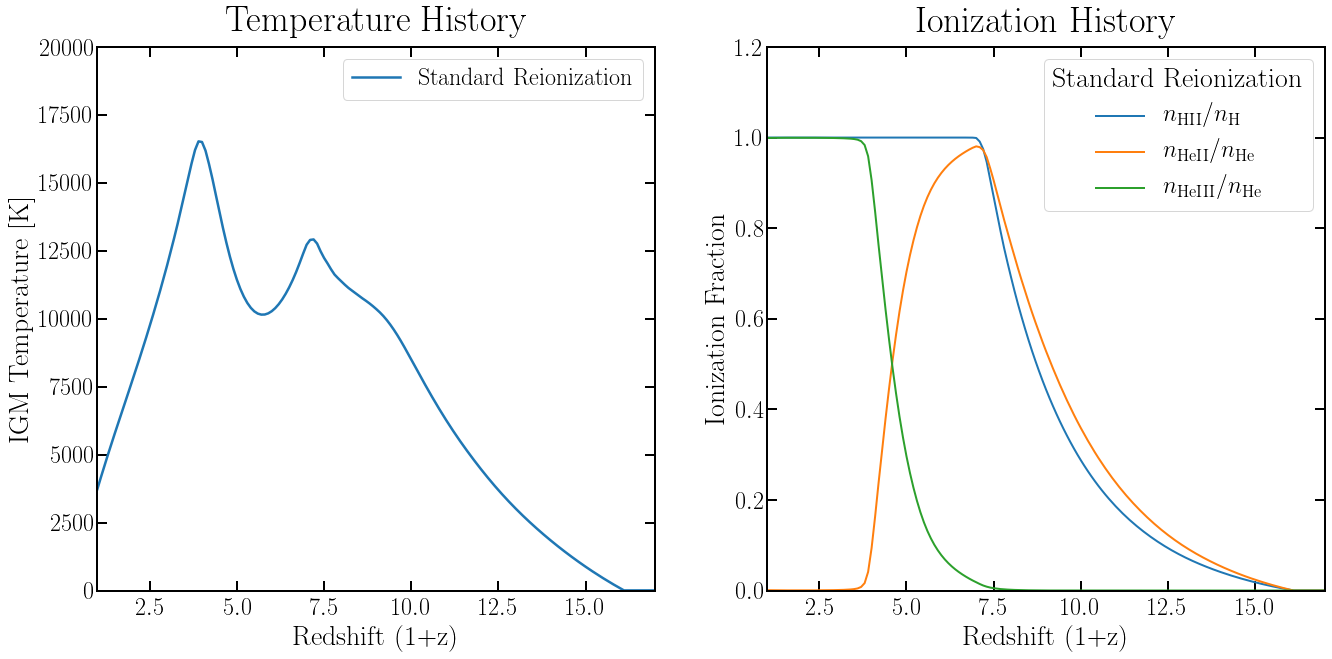

In [8]:
plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)

T_IGM_reion, = plt.plot(rs_vec, soln_with_reion[:,0]/phys.kB, label='Standard Reionization')

plt.legend(handles=[T_IGM_reion])

plt.title('Temperature History')
plt.xlabel('Redshift (1+z)')
plt.ylabel('IGM Temperature [K]')
plt.axis([1, 17, 0, 20000])

ax = plt.subplot(1,2,2)

xHII, = plt.plot(rs_vec, soln_with_reion[:,1], linewidth=2, label=r'$n_\mathrm{HII}/n_\mathrm{H}$')
xHeII, = plt.plot(rs_vec, soln_with_reion[:,2]/(phys.nHe/phys.nH), linewidth=2, label=r'$n_\mathrm{HeII}/n_\mathrm{He}$')
xHeIII, = plt.plot(rs_vec, soln_with_reion[:,3]/(phys.nHe/phys.nH), linewidth=2, label=r'$n_\mathrm{HeIII}/n_\mathrm{He}$')

leg = plt.legend(handles=[xHII, xHeII, xHeIII])
leg.set_title('Standard Reionization', prop = {'size':'28'})

plt.title('Ionization History')
plt.xlabel('Redshift (1+z)')
plt.ylabel('Ionization Fraction')
plt.axis([1, 17, 0, 1.2])


## User-Defined Reionization

The user may enter their own photoionization and photoheating rates into the TLA solver. This is done by defining two tuples of functions, each containing the photoionization and photoheating rates respectively of HI, HeI and HeII. Here, we define functions `photoion_rate` and `photoheat_rate` to return these tuples, given some new photoionization and photoheating rates. In this example, we use the rates from <cite data-cite="6232408/QRY4E9Y7"></cite>.

In [9]:
def photoion_rate():
    
    rs_vec = 1. + np.array([
        0.00, 0.05, 0.10, 0.16, 0.21, 0.27, 0.33, 0.40, 0.47,
        0.54, 0.62, 0.69, 0.78, 0.87, 0.96, 1.05, 1.15, 1.26, 
        1.37, 1.49, 1.61, 1.74, 1.87, 2.01, 2.16, 2.32, 2.48,
        2.65, 2.83, 3.02, 3.21, 3.42, 3.64, 3.87, 4.11, 4.36,
        4.62, 4.89, 5.18, 5.49, 5.81, 6.14, 6.49, 6.86, 7.25,
        7.65, 8.07, 8.52, 8.99, 9.48, 9.99, 10.50, 11.10, 11.70,
        12.30, 13.00, 13.70, 14.40, 15.10
    ])
    
    rate_vec_HI = np.array([
        22.8, 28.4, 35.4, 44.0, 54.6, 67.4, 83.1, 102, 125,
        152, 185, 223, 267, 318, 376, 440, 510, 585, 660, 732, 
        799, 859, 909, 944, 963, 965, 950, 919, 875, 822, 765, 
        705, 647, 594, 546, 504, 469, 441, 412, 360, 293, 230,
        175, 129, 92.8, 65.5, 45.6, 31.2, 21.2, 14.3, 9.59, 
        6.40, 4.27, 2.92, 1.73, 1.02, 0.592, 0.341, 0.194
    ]) * 1e-15
    
    rate_vec_HeI = np.array([
        12.4, 15.7, 19.6, 24.6, 30.7, 38.3, 47.5, 58.7, 72.2,
        88.4, 108, 130, 157, 187, 222, 261, 302, 346, 391, 
        434, 474, 509, 538, 557, 567, 566, 555, 535, 508,
        476, 441, 406, 372, 341, 314, 291, 271, 253, 237, 214,
        184, 154, 125, 99.2, 76.1, 56.8, 41.4, 29.6, 20.7, 
        14.4, 9.82, 6.67, 4.53, 3.24, 2.02, 1.23, 0.746, 0.446,
        0.262
    ]) * 1e-15
    
    rate_vec_HeII = np.array([
        0.555, 0.676, 0.823, 1.00, 1.22, 1.48, 1.80, 2.18,
        2.63, 3.17, 3.80, 4.54, 5.38, 6.33, 7.38, 8.52, 
        9.70, 10.9, 11.9, 12.7, 13.2, 13.4, 13.3, 12.8, 
        11.9, 10.6, 9.04, 7.22, 5.30, 3.51, 2.08, 1.14,
        0.591, 0.302, 0.152, 0.0760, 0.0375, 0.0182,
        0.00857, 0.00323, 0.00117, 4.42e-4, 1.73e-4, 
        7.01e-5, 2.92e-5, 1.25e-5, 5.67e-6, 2.74e-6, 1.44e-6,
        8.19e-7, 4.99e-7, 3.25e-7, 2.12e-7, 1.43e-7, 9.84e-8,
        6.81e-8, 4.73e-8, 3.30e-8, 1.92e-8
    ]) * 1e-15

    def ion_rate_HI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HI))
        return 10**log10_rate
    
    def ion_rate_HeI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeI))
        return 10**log10_rate
    
    def ion_rate_HeII(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeII))
        return 10**log10_rate

    return (ion_rate_HI, ion_rate_HeI, ion_rate_HeII)

def photoheat_rate():
    
    rs_vec = 1. + np.array([
        0.00, 0.05, 0.10, 0.16, 0.21, 0.27, 0.33, 0.40, 0.47,
        0.54, 0.62, 0.69, 0.78, 0.87, 0.96, 1.05, 1.15, 1.26, 
        1.37, 1.49, 1.61, 1.74, 1.87, 2.01, 2.16, 2.32, 2.48,
        2.65, 2.83, 3.02, 3.21, 3.42, 3.64, 3.87, 4.11, 4.36,
        4.62, 4.89, 5.18, 5.49, 5.81, 6.14, 6.49, 6.86, 7.25,
        7.65, 8.07, 8.52, 8.99, 9.48, 9.99, 10.50, 11.10, 11.70,
        12.30, 13.00, 13.70, 14.40, 15.10
    ])
    
    rate_vec_HI = np.array([
        8.89, 11.1, 13.9, 17.3, 21.5, 26.6, 32.9, 40.5, 49.6, 
        60.5, 73.4, 88.5, 106, 126, 149, 175, 203, 232, 262,
        290, 317, 341, 360, 374, 381, 382, 375, 363, 346, 325,
        302, 279, 257, 236, 218, 202, 189, 178, 167, 148, 123,
        98.9, 77.1, 58.3, 43.0, 31.0, 21.9, 15.3, 10.5, 7.13, 
        4.81, 3.23, 2.17, 1.51, 0.915, 0.546, 0.323, 0.189, 0.110
    ]) * 1e-14
    
    rate_vec_HeI = np.array([
        11.2, 14.0, 17.4, 21.6, 26.7, 33.1, 40.8, 50.2, 61.5,
        75.1, 91.1, 110, 132, 157, 186, 217, 251, 287, 323, 
        357, 387, 413, 432, 444, 446, 438, 422, 398, 368, 336,
        304, 274, 249, 227, 209, 194, 181, 170, 160, 146, 130, 
        112, 95.2, 78.3, 62.5, 48.3, 36.3, 26.6, 19.1, 13.4, 
        9.27, 6.36, 4.35, 3.14, 1.98, 1.22, 0.749, 0.455, 0.270
    ])* 1e-14

    rate_vec_HeII = np.array([
        1.14, 1.38, 1.68, 2.03, 2.45, 2.96, 3.57, 4.29, 5.14,
        6.15, 7.32, 8.67, 10.2, 11.9, 13.9, 15.9, 18.1, 20.2,
        22.1, 23.7, 24.7, 25.3, 25.2, 24.4, 22.9, 20.7, 17.8,
        14.5, 11.1, 7.75, 4.97, 2.96, 1.68, 0.925, 0.501, 0.267,
        0.141, 0.0727, 0.0365, 0.0156, 0.00624, 0.00269, 0.00128,
        6.74e-4, 3.88e-4, 2.40e-4, 1.55e-4, 1.03e-4, 6.98e-5, 
        4.76e-5, 3.26e-5, 2.24e-5, 1.53e-5, 1.06e-5, 7.52e-6,
        5.31e-6, 3.73e-6, 2.57e-6, 1.54e-6
    ]) * 1e-14

    def heat_rate_HI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HI))
        return 10**log10_rate
    
    def heat_rate_HeI(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeI))
        return 10**log10_rate
    
    def heat_rate_HeII(rs):
        log10_rate = np.interp(rs, rs_vec, np.log10(rate_vec_HeII))
        return 10**log10_rate

    return (heat_rate_HI, heat_rate_HeI, heat_rate_HeII)



Now we call the solver. In addition to setting `reion_switch=True`, we must also specify the redshift at which reionization effects start (`reion_rs`), as well as the two tuples for `photoion_rate_func` and `photoheat_rate_func` respectively.

In [10]:
# Initialize the redshift at which we want the solution. 
rs_vec_reion = np.flipud(1 + np.arange(0, 3000, 0.1))

# Set the initial conditions. The initial temperature is the CMB temperature, 
# and the initial free electron fraction is 1. 
init_cond = [phys.TCMB(3000), 1, 0, 0]


# Obtain the solution
soln_with_reion_2 = tla.get_history(
    init_cond, 0., 0., 0., 0., rs_vec_reion,
    reion_switch=True, reion_rs = 16.1, photoion_rate_func=photoion_rate(), photoheat_rate_func=photoheat_rate()
)

16.1 0.0004753318705879875 0.0002048586427219612 9.999986949615902e-13 9.999986949615902e-13
16.0999999999998 0.0004753318707176581 0.00020485864275293642 1.003308547353754e-12 9.999986949615902e-13
16.0999999999998 0.0004753318707176581 0.00020485864275293642 1.00330160845985e-12 9.999986949615902e-13
16.099999999999955 0.0004753318706174202 0.0002048586427289556 1.0007480955032122e-12 9.999986949615902e-13
16.099999999999955 0.0004753318706174202 0.0002048586427289556 1.0007480955032122e-12 9.999986949615902e-13
16.09999999999991 0.00047533187064685285 0.00020485864273600551 1.001504434938738e-12 9.999986949615902e-13
16.09999999999991 0.00047533187064685285 0.00020485864273600551 1.0014974960448342e-12 9.999986949615902e-13
16.099999999999817 0.00047533187070571825 0.00020485864275010535 1.003003236021982e-12 9.999986949615902e-13
16.099999999999817 0.00047533187070571825 0.00020485864275010535 1.003003236021982e-12 9.999986949615902e-13
16.099999999999724 0.00047533187076458365 0.0

16.09999999881682 0.00047533262173239107 0.00020485882236231934 2.0157250868457766e-11 9.999986949615902e-13
16.099999998760733 0.0004753326573386083 0.00020485883087772994 2.106537166923772e-11 9.999986949615902e-13
16.099999998760733 0.0004753326573386083 0.00020485883087772994 2.1065357791449912e-11 9.999986949615902e-13
16.099999998704646 0.00047533269294482557 0.00020485883939314053 2.1973478592229867e-11 9.999986949615902e-13
16.099999998704646 0.00047533269294482557 0.00020485883939314053 2.197346471444206e-11 9.999986949615902e-13
16.0999999986302 0.00047533274020602367 0.00020485885069593257 2.3178833852277592e-11 9.999986949615902e-13
16.0999999986302 0.00047533274020602367 0.00020485885069593257 2.3178819974489784e-11 9.999986949615902e-13
16.099999998555752 0.00047533278746722177 0.0002048588619987246 2.4384202990113124e-11 9.999986949615902e-13
16.099999998555752 0.00047533278746722177 0.0002048588619987246 2.4384168295643605e-11 9.999986949615902e-13
16.099999998481305 0.

16.099999951480903 0.000475362672518493 0.00020486600917463127 7.865758946956625e-10 9.999986949615902e-13
16.099999951480903 0.000475362672518493 0.00020486600917463127 7.865753742786197e-10 9.999986949615902e-13
16.0999999493368 0.0004753640336832356 0.00020486633470473414 8.21291062935714e-10 9.999986949615902e-13
16.0999999493368 0.0004753640336832356 0.00020486633470473414 8.212906674187614e-10 9.999986949615902e-13
16.0999999471927 0.0004753653948479796 0.00020486666023483702 8.560062728091289e-10 9.999986949615902e-13
16.0999999471927 0.0004753653948479796 0.00020486666023483702 8.560059605589032e-10 9.999986949615902e-13
16.099999944364985 0.00047536718999642325 0.00020486708955452793 9.017902050101334e-10 9.999986949615902e-13
16.099999944364985 0.00047536718999642325 0.00020486708955452793 9.017895666318942e-10 9.999986949615902e-13
16.09999994153727 0.0004753689851448693 0.00020486751887427435 9.475744008891063e-10 9.999986949615902e-13
16.09999994153727 0.000475368985144869

16.099998259722668 0.00047643667037284253 0.00020512286179463768 2.8177943062202004e-08 9.999986949615902e-13
16.099998259722668 0.00047643667037284253 0.00020512286179463768 2.8177927435812933e-08 9.999986949615902e-13
16.0999981847425 0.0004764842708938972 0.00020513424572982109 2.939194886086849e-08 9.999986949615902e-13
16.0999981847425 0.0004764842708938972 0.00020513424572982109 2.9391936710865263e-08 9.999986949615902e-13
16.099998109762332 0.0004765318714166815 0.00020514562966572614 3.060595574200242e-08 9.999986949615902e-13
16.099998109762332 0.0004765318714166815 0.00020514562966572614 3.060594612469547e-08 9.999986949615902e-13
16.09999801160575 0.0004765941852942816 0.0002051605323845629 3.2195224326792005e-08 9.999986949615902e-13
16.09999801160575 0.0004765941852942816 0.0002051605323845629 3.2195205022789164e-08 9.999986949615902e-13
16.099997913449165 0.0004766564991748458 0.00020517543510456537 3.37845007525317e-08 9.999986949615902e-13
16.099997913449165 0.000476656

16.099981245950108 0.0004872377635245168 0.00020770601157910074 3.0365070227689195e-07 9.999986949615902e-13
16.099980418594882 0.00048776300737999505 0.00020783162732757043 3.170467872334881e-07 9.999986949615902e-13
16.099980418594882 0.00048776300737999494 0.00020783162732757043 3.170466332247379e-07 9.999986949615902e-13
16.099979591239656 0.000488288251446064 0.0002079572431594734 3.3044269363152745e-07 9.999986949615902e-13
16.099979591239656 0.0004882882514460639 0.0002079572431594734 3.3044257317926817e-07 9.999986949615902e-13
16.09997876388443 0.0004888134957227234 0.0002080828590747541 3.4383861746700717e-07 9.999986949615902e-13
16.09997876388443 0.0004888134957227234 0.0002080828590747541 3.438385217102713e-07 9.999986949615902e-13
16.099977687164735 0.000489497048686806 0.0002082463356913311 3.612721871520952e-07 9.999986949615902e-13
16.099977687164735 0.0004894970486868059 0.0002082463356913311 3.6127199803948074e-07 9.999986949615902e-13
16.09997661044504 0.00049018060

16.09936508313416 0.0008784650954323895 0.0003012799105538422 1.0282267275799062e-05 1.0000264505372058e-12
16.09936508313416 0.0008784650954323541 0.0003012799105065467 1.0282264953469233e-05 1.0000264505372058e-12
16.099334198654095 0.0008980780059352711 0.0003059714151373294 1.0782549884555404e-05 1.0000333894311098e-12
16.099334198654095 0.0008980780059351864 0.00030597141503246883 1.0782545425913614e-05 1.0000333894311098e-12
16.09930331417403 0.0009176912097361019 0.0003106630358294393 1.1282844965147809e-05 1.0000403283250137e-12
16.09930331417403 0.0009176912097359078 0.0003106630356236595 1.128283689332682e-05 1.0000403283250137e-12
16.099272429693965 0.0009373047068274023 0.00031535477244976073 1.1783144988244953e-05 1.0000403283250137e-12
16.099272429693965 0.000937304706827315 0.0003153547722738459 1.1783139350546312e-05 1.0000403283250137e-12
16.0992415452139 0.0009569184972020276 0.00032004662514439897 1.2283457332479264e-05 1.0000472672189176e-12
16.0992415452139 0.00095

16.088317430511168 0.007912833607581733 0.00198685991193448 0.00018992704692142454 1.016249584484541e-12
16.088317430511168 0.00791283360762547 0.0019868600738606745 0.0001899270840179032 1.016249584484541e-12
16.087719709753696 0.0082944837498106 0.0020784781074958403 0.00019968583746299978 1.0179843079605178e-12
16.087719709753696 0.008294483749965668 0.002078478535140982 0.0001996859343090865 1.0179843079605178e-12
16.087121988996223 0.00867624270401533 0.0021701399927279708 0.00020944875179587652 1.0198092370572454e-12
16.087121988996223 0.008676242704074145 0.0021701402997826302 0.000209448818418001 1.0198092370572454e-12
16.08652426823875 0.009058110415574175 0.0022618451312506616 0.00021921568612014164 1.0217243717747237e-12
16.08652426823875 0.009058110415667597 0.002261845375479854 0.00021921573759938612 1.0217243717747237e-12
16.08592654748128 0.009440086830180357 0.0023535935836527244 0.0002289866547547023 1.023722773219049e-12
16.08592654748128 0.009440086830238396 0.002353

15.972924244003803 0.0835416031182869 0.020486323750620483 0.002148956988728759 3.166321371761427e-12
15.967705268255012 0.08705114737593407 0.021362207703196967 0.002241149219209558 3.358174849310558e-12
15.967705268255012 0.08705114737954281 0.021362209410537736 0.0022411494120637074 3.358174849310558e-12
15.96248629250622 0.09056805021066465 0.022241547807218043 0.0023336550743622633 3.5590072555713448e-12
15.96248629250622 0.09056805021460156 0.022241549123652615 0.0023336552225444313 3.5590072555713448e-12
15.955432601691163 0.09533292231375247 0.02343551869189564 0.0024591795136920253 3.844875806624515e-12
15.955432601691163 0.09533292232340149 0.023435521709814 0.0024591798521183678 3.844875806624515e-12
15.948378910876105 0.10011103950086556 0.02463583113693274 0.0025852776234461944 4.147578114288564e-12
15.948378910876105 0.10011103953399057 0.02463583875719083 0.0025852784763855385 4.147578114288564e-12
15.941325220061048 0.1049022869976741 0.025842515244825115 0.002711951388

15.020903422882258 0.7804368463839065 0.24421681493132502 0.024215259757832463 3.200545106718522e-10
15.020903422882258 0.7804378745347407 0.24421679805593866 0.024215258166405747 3.2005441352733754e-10
15.03003518683104 0.7742571797643353 0.24142888850644012 0.023957780982938374 3.129491110698268e-10
15.03003518683104 0.7742575580166127 0.24142888209005836 0.023957780374825256 3.129490763753573e-10
15.004402762560522 0.7914449952548419 0.24928523785187107 0.024682261170744672 3.331688813723588e-10
15.004402762560522 0.7914451778000657 0.24928523867066643 0.024682261273928294 3.331688883112527e-10
14.978770338290005 0.8080853926558054 0.2572367719759068 0.0254120728228475 3.5425597871840964e-10
14.978770338290005 0.8080858495708348 0.2572367684769022 0.025412072536640823 3.542559579017279e-10
14.953137914019488 0.824084190450111 0.26528240226075067 0.02614699459831983 3.76231081011813e-10
14.953137914019488 0.8240846458945569 0.26528240040438966 0.026146994492575133 3.762310740729191e-

13.503299389059995 0.9436053137843431 0.7662230286729059 0.06479321822402098 3.483818337979283e-09
13.503299389059995 0.9436054290562833 0.7662230180108103 0.06479321853558084 3.483818331040389e-09
13.45118712760708 0.941737394122734 0.7805709069197422 0.06568669675678127 3.673553454486278e-09
13.45118712760708 0.9417373277506957 0.7805709106866223 0.06568669819029073 3.6735534267307024e-09
13.399074866154164 0.9396985130559032 0.7943230188551665 0.06653083801422875 3.869348459695221e-09
13.399074866154164 0.9396985082071558 0.7943230224322659 0.06653083936110754 3.869348452756327e-09
13.346962604701249 0.9374753309453074 0.8074630816153425 0.06732616582506111 4.071311225650742e-09
13.346962604701249 0.9374753474744442 0.8074630875077129 0.0673261672123382 4.071311197895167e-09
13.294850343248333 0.9350553098227823 0.8199787611360196 0.06807348750530476 4.279562405840043e-09
13.294850343248333 0.9350624203350886 0.8199831223877029 0.06807369431571342 4.27963959409583e-09
13.29485034324

12.699897118683031 0.8955589063271208 0.9230926760073443 0.07387269075397751 7.34065391111427e-09
12.699897118683031 0.8955589013578624 0.923092673238205 0.07387269056100826 7.340653924992058e-09
12.698622690648339 0.8954424728491167 0.9232361765019487 0.07388056826612732 7.348794343886578e-09
12.698622690648339 0.8954423773876199 0.9232361237360662 0.07388056457228939 7.348794683892379e-09
12.699033281141825 0.8954800004532083 0.9231899775373689 0.07387803206215088 7.346170831368237e-09
12.699033281141825 0.8954799565606169 0.9231899532960629 0.07387803036472249 7.346170990962797e-09
12.698169443600618 0.895400852463169 0.9232870404640533 0.0738833591944425 7.351691998225274e-09
12.698169443600618 0.8954008528180969 0.9232870404621154 0.07388335919774647 7.351691998225274e-09
12.69730560605941 0.8953215901705884 0.9233839350287171 0.07388867707681895 7.357216946779488e-09
12.69730560605941 0.895321590525066 0.9233839350270899 0.07388867708014266 7.357216946779488e-09
12.69557793097699

11.995644049781134 0.818274960708729 0.9646714333183969 0.07627105808800017 1.3420155826893154e-08
11.995644049781134 0.8182749516787303 0.9646714348918582 0.07627105734109996 1.3420156090571123e-08
11.963822421314717 0.815309835643943 0.9656715872014066 0.07633980455181558 1.379302345949629e-08
11.963822421314717 0.8153098223450276 0.9656715911488201 0.0763398031005037 1.3793023861952136e-08
11.9320007928483 0.8124326163015766 0.9666424895808063 0.07640746208969207 1.4177691742833787e-08
11.9320007928483 0.8124326114680217 0.9666424903839557 0.07640746165276738 1.4177691957939498e-08
11.900179164381882 0.8096402971783752 0.96758537614302 0.07647393925914223 1.4574532775091242e-08
11.900179164381882 0.8096402933562411 0.967585377264126 0.07647393879520864 1.4574532969380272e-08
11.855743021308209 0.8058776335648479 0.9688572885848654 0.076564658692274 1.5149781935897e-08
11.855743021308209 0.805877626512077 0.9688572921642905 0.07656465745003627 1.5149782359169528e-08
11.81130687823453

10.602349811057467 0.7439411741949628 0.9911301717736266 0.07823658930144231 5.1924433107364276e-08
10.581380529531218 0.7433291969012952 0.9913246631268775 0.07825168791989673 5.3182176953936455e-08
10.581380529531218 0.7433291971603525 0.9913246630372055 0.0782516879145295 5.31821808882893e-08
10.56041124800497 0.7427259272065722 0.9915149876285968 0.07826647425889657 5.4475050942359715e-08
10.56041124800497 0.7427259275165515 0.9915149875563141 0.0782664742545794 5.4475054869773665e-08
10.539441966478721 0.7421312237940526 0.9917012334797521 0.07828095464658516 5.580393302312414e-08
10.539441966478721 0.742131224156578 0.991701233429745 0.07828095464362514 5.580393689502694e-08
10.494946214124809 0.7408970289280689 0.9920833179631254 0.07831069592116864 5.874716842158012e-08
10.494946214124809 0.7408970311931751 0.9920833177356263 0.07831069590710019 5.874719012644025e-08
10.450450461770897 0.7396994565450855 0.9924482190082822 0.07833914461522266 6.186577756334133e-08
10.4504504617

9.964271841815911 0.7286867853719478 0.9955538231726933 0.07857790659380627 1.1518975240321083e-07
9.964271841815911 0.7286867877013806 0.9955538243632175 0.0785779066964632 1.1518975247259977e-07
9.958374608402066 0.7285718413128478 0.9955828704815735 0.07858018426916827 1.1611981406978167e-07
9.958374608402066 0.7285718381794721 0.9955828689197891 0.0785801841354154 1.161198140350872e-07
9.95247737498822 0.7284571433589089 0.9956117591596922 0.07858245074622316 1.1706031698144326e-07
9.95247737498822 0.7284571409482111 0.9956117579431956 0.07858245064278725 1.1706031696756547e-07
9.946580141574374 0.7283426788285235 0.9956404836154162 0.07858470549517736 1.1801135330752333e-07
9.946580141574374 0.7283426784282558 0.9956404834314052 0.07858470547872716 1.1801135331446222e-07
9.940682908160529 0.728228438572314 0.9956690403885277 0.07858694816661385 1.1897301608471134e-07
9.940682908160529 0.728228437929501 0.9956690400664485 0.07858694813896855 1.1897301609165023e-07
9.932528033002475

9.4855837010738 0.7199184617041773 0.9974021274007967 0.07872472687063609 2.3460942379094352e-07
9.48073456262918 0.7198331722811542 0.9974165611815864 0.07872585716453645 2.3643049597982246e-07
9.48073456262918 0.7198331717546533 0.9974165608216239 0.07872585718465847 2.3643049597982246e-07
9.475885424184561 0.719747748374702 0.9974309189429063 0.07872698157662145 2.3827052001573756e-07
9.475885424184561 0.7197477481125122 0.9974309187637665 0.07872698158723217 2.3827052001573756e-07
9.471036285739942 0.719662189755505 0.9974452004140704 0.07872810018909773 2.4012965944841813e-07
9.471036285739942 0.7196621895667543 0.9974452002849106 0.07872810019667431 2.4012965944841813e-07
9.466187147295322 0.7195764958148207 0.9974594051077761 0.07872921309043326 2.42008079430478e-07
9.466187147295322 0.7195764956617098 0.9974594050019899 0.07872921309655226 2.42008079430478e-07
9.460419255469128 0.7194743892695077 0.9974762009549762 0.07873052950544554 2.4426773580915606e-07
9.460419255469128 0.

9.054833105365061 0.7118596610522938 0.9984202342896626 0.07880582340315118 4.934627123726054e-07
9.051901977657554 0.7118020365352873 0.9984256757011555 0.07880626222942025 4.961181710172458e-07
9.051901977657554 0.7118020373569806 0.9984256762067283 0.07880626224490478 4.961181711005125e-07
9.048970849950047 0.7117444045914053 0.9984311022041874 0.07880669982360533 4.987924243984865e-07
9.048970849950047 0.7117444050629511 0.9984311024922785 0.0788066998331669 4.987924244886921e-07
9.045360304707526 0.7116733992422126 0.9984377633935217 0.07880723706990017 5.021125570464635e-07
9.045360304707526 0.7116733998758199 0.998437763781665 0.07880723708272938 5.021125572060581e-07
9.041749759465004 0.7116023765456891 0.998444398459455 0.07880777232858756 5.054615960578546e-07
9.041749759465004 0.7116023771659785 0.9984443988404622 0.07880777234122649 5.054615962660214e-07
9.038139214222483 0.7115313355682992 0.9984510069837255 0.07880830558330348 5.08839758606161e-07
9.038139214222483 0.7115

8.606758126466737 0.7028670318041879 0.999071682269285 0.07885905577692706 1.205802764074615e-06
8.606758126466737 0.7028670318553988 0.9990716822693646 0.07885905577648139 1.20580272809645e-06
8.597610122589533 0.702676210924048 0.9990818322579216 0.07885987509854106 1.2295921527072373e-06
8.597610122589533 0.7026762111481064 0.9990818322587186 0.07885987509236651 1.2295919861321503e-06
8.588462118712329 0.7024846322354542 0.9990918733485472 0.07886068590740464 1.2539513483192377e-06
8.588462118712329 0.702484631921003 0.9990918733561709 0.0788606858872885 1.2539515535509027e-06
8.588462118712329 0.7024846319550219 0.9990918733483642 0.07886068590418421 1.2539515509071841e-06
8.595323121620233 0.7026283873372239 0.9990843526948527 0.07886007859529298 1.2356279184277952e-06
8.595323121620233 0.7026283873227269 0.9990843526952059 0.0788600785935343 1.2356279260050673e-06
8.593036120650932 0.7025805161185704 0.9990868663449757 0.07886028155425834 1.2416997068262492e-06
8.593036120650932 

8.395074966474484 0.6982635037435718 0.9992806377241016 0.07887593407535379 1.9277575673826153e-06
8.395074966474484 0.6982635037583734 0.9992806377241761 0.07887593407490877 1.9277575536297276e-06
8.393028386617592 0.6982171410371418 0.9992824137467178 0.07887607702707444 1.9367970108125077e-06
8.393028386617592 0.6982171410516722 0.9992824137467913 0.07887607702663295 1.9367969972886034e-06
8.390981806760701 0.6981707439487834 0.9992841854768317 0.07887621960930523 1.945883006129745e-06
8.390981806760701 0.6981707439632165 0.9992841854769045 0.07887621960886454 1.945882992661352e-06
8.38893522690381 0.6981243125080117 0.9992859529246814 0.07887636182249141 1.955015783698666e-06
8.38893522690381 0.6981243125223839 0.999285952924754 0.07887636182204782 1.9550157702510895e-06
8.386900356381794 0.6980781126918454 0.9992877060247513 0.07887650285656278 1.9641429193917315e-06
8.386900356381794 0.6980781127059534 0.9992877060248226 0.07887650285612273 1.964142906159261e-06
8.384865485859779

8.254960338660585 0.695011393749879 0.9993928203616089 0.07888488814316019 2.6669719973074213e-06
8.254960338660585 0.6950113937572414 0.9993928203616496 0.07888488814275824 2.666971989279121e-06
8.253165997402174 0.6949687378100544 0.9993941397088608 0.07888499209515648 2.6782121667415226e-06
8.253165997402174 0.6949687378173725 0.9993941397089012 0.0788849920947554 2.6782121587548557e-06
8.251371656143764 0.6949260567963325 0.9993954562533929 0.07888509578170456 2.6895025618395296e-06
8.251371656143764 0.6949260568036213 0.9993954562534333 0.0788850957813013 2.6895025538667405e-06
8.24958670209032 0.6948835742084954 0.999396763135387 0.07888519866260849 2.7007839403653255e-06
8.24958670209032 0.6948835684564885 0.9993967608601593 0.07888519830339968 2.7007843729220937e-06
8.24958670209032 0.6948835698409622 0.9993967616420755 0.07888519840458391 2.7007843715065594e-06
8.250925417630404 0.6949154384804881 0.9993957832331608 0.07888512152627011 2.692318210782696e-06
8.250925417630404 0

8.117870157567383 0.6916421758503026 0.9994841577661682 0.07889171553794655 3.6998477360439264e-06
8.116321335513701 0.6916028865000811 0.9994851074932504 0.07889178416086604 3.713788550165076e-06
8.116321335513701 0.6916028865117824 0.9994851074932755 0.07889178416051268 3.7137885388824343e-06
8.114778982895444 0.6915637348781403 0.9994860515541433 0.07889185231389584 3.7277277461708613e-06
8.114778982895444 0.6915637348896961 0.999486051554168 0.07889185231354467 3.72772773501312e-06
8.113236630277187 0.6915245569396214 0.9994869939223987 0.07889192028437654 3.7417236710690638e-06
8.113236630277187 0.6915245569511329 0.9994869939224231 0.07889192028402599 3.7417236599529557e-06
8.11169427765893 0.691485352708079 0.999487934601014 0.07889198807227504 3.7557765486459505e-06
8.11169427765893 0.691485352719567 0.9994879346010386 0.07889198807192296 3.75577653754372e-06
8.110158417065579 0.691446287389954 0.9994888696441355 0.07889205539337271 3.7698270917499443e-06
8.110158417065579 0.69

8.015952323787802 0.6890012187748576 0.9995431414616363 0.07889583630379565 4.749615914276251e-06
8.014541559094036 0.6889638850642292 0.9995439097952251 0.07889588766857292 4.766205224354669e-06
8.014541559094036 0.6889638850720431 0.9995439097952417 0.07889588766825277 4.766205216590047e-06
8.01313628519805 0.688926675976834 0.9995446738837156 0.07889593867723461 4.782790950640103e-06
8.01313628519805 0.6889266759845587 0.999544673883732 0.0788959386769165 4.782790942965687e-06
8.011731011302063 0.6888894462554539 0.9995454367219705 0.07889598953022975 4.799437769154036e-06
8.011731011302063 0.6888894462631528 0.9995454367219868 0.07889598952991234 4.799437761507375e-06
8.010325737406076 0.6888521959159571 0.9995461983120071 0.07889604022746843 4.816145900650437e-06
8.010325737406076 0.6888521959236424 0.9995461983120233 0.07889604022714987 4.816145893010715e-06
8.008925975942539 0.6888150712162279 0.9995469556756895 0.0788960905709026 4.832849664217209e-06
8.008925975942539 0.688815

7.907471777182065 0.6860708581428656 0.9995986842817209 0.07889932039983741 6.221644953993688e-06
7.906198358808917 0.6860357561565128 0.999599295437495 0.07889935557878987 6.241518011408653e-06
7.906198358808917 0.6860357561616199 0.9995992954375057 0.07889935557851614 6.241518006301627e-06
7.904929588041433 0.6860007663676545 0.9995999034597911 0.07889939049381035 6.261384226852185e-06
7.904929588041433 0.686000766372708 0.9995999034598018 0.07889939049353842 6.26138422180067e-06
7.90366081727395 0.6859657606986689 0.9996005105821046 0.07889942527368371 6.281316231426803e-06
7.90366081727395 0.6859657607037083 0.9996005105821153 0.07889942527341251 6.2813162263891664e-06
7.902392046506467 0.6859307391600299 0.999601116805747 0.07889945991828118 6.301314240703126e-06
7.902392046506467 0.6859307391650621 0.9996011168057575 0.07889945991800926 6.301314235672428e-06
7.901127966492797 0.6858958313276614 0.9996017198957359 0.07889949430013586 6.3213041695611705e-06
7.901127966492797 0.6858

7.839804214043393 0.6841831594181459 0.9996297935236198 0.07890095811524588 7.375594897607307e-06
7.839804214043393 0.6841831594249508 0.9996297935236762 0.07890095811501655 7.3755948760689805e-06
7.838763394207024 0.6841537482947689 0.9996302474789016 0.07890097849710845 7.395076266653033e-06
7.838763394207024 0.684153748298966 0.9996302474789043 0.07890097849693642 7.395076253031985e-06
7.8377225743706544 0.6841243257784716 0.9996307008916496 0.07890099878124954 7.414616182109535e-06
7.8377225743706544 0.6841243257823166 0.999630700891652 0.0789009987811077 7.414616169751365e-06
7.836681754534285 0.6840948918790313 0.9996311537625311 0.07890101896759849 7.434214805944472e-06
7.836681754534285 0.6840948918828518 0.9996311537625413 0.0789010189674427 7.4342147935793634e-06
7.835570530485582 0.6840634544257436 0.9996316366696251 0.07890104041132298 7.455204129598603e-06
7.835570530485582 0.6840634544302149 0.9996316366696365 0.07890104041112786 7.455204115040803e-06
7.834459306436879 0.

7.765557973602766 0.6820570078426224 0.9996608515321259 0.07890215897096972 8.922351489540348e-06
7.765557973602766 0.6820570078465233 0.9996608515321315 0.07890215897077431 8.922351476953194e-06
7.764495761344745 0.6820261825842904 0.9996612769104802 0.07890217229568194 8.946954854358036e-06
7.764495761344745 0.6820261825881897 0.9996612769104856 0.0789021722954863 8.946954841770882e-06
7.76343658182827 0.6819954340904305 0.9996617005570843 0.07890218546999961 8.971562440916736e-06
7.76343658182827 0.6819954340943007 0.9996617005570896 0.07890218546980514 8.971562428433666e-06
7.762377402311794 0.6819646743753128 0.9996621236878023 0.07890219853194719 8.996244606152004e-06
7.762377402311794 0.6819646743791775 0.9996621236878078 0.07890219853175326 8.99624459369669e-06
7.761318222795319 0.6819339034469475 0.9996625463032527 0.07890221148134395 9.021001568167153e-06
7.761318222795319 0.6819339034508108 0.9996625463032582 0.07890221148114977 9.021001555725716e-06
7.7602619930960985 0.681

7.690642254280226 0.6798557235705125 0.9996896132374984 0.0789028112081808 1.0853880669590976e-05
7.690642254280226 0.6798557235736747 0.9996896132375026 0.07890281120802163 1.0853880659862647e-05
7.689651841495927 0.6798262579399869 0.9996899771059556 0.07890281576191718 1.0882273946681564e-05
7.689651841495927 0.679826257943127 0.9996899771059597 0.07890281576175906 1.0882273937029563e-05
7.688661428711628 0.6797967829821788 0.9996903405594877 0.07890282020482714 1.0910747184657288e-05
7.688661428711628 0.6797967829853153 0.9996903405594917 0.07890282020466957 1.0910747175026103e-05
7.687671015927329 0.6797672987035883 0.9996907035985594 0.07890282453671961 1.09393006031272e-05
7.687671015927329 0.6797672987067246 0.9996907035985636 0.078902824536562 1.0939300593509893e-05
7.686683383073082 0.6797378879075437 0.9996910652063837 0.07890282874571045 1.0967853939031214e-05
7.686683383073082 0.6797378879106583 0.9996910652063881 0.07890282874555393 1.0967853929490234e-05
7.68569575021883

7.602268067570085 0.6771905437030786 0.9997204997770387 0.07890275772152294 1.3728890513264869e-05
7.602268067570085 0.6771905437055662 0.9997204997770417 0.07890275772141257 1.3728890506325975e-05
7.601359451445684 0.6771627718724867 0.9997208012688525 0.07890275206929394 1.3762342490543367e-05
7.601359451445684 0.6771627718749574 0.9997208012688554 0.07890275206918448 1.3762342483659984e-05
7.600450835321283 0.6771349926807125 0.9997211024446826 0.07890274630713523 1.3795880456878018e-05
7.600450835321283 0.677134992683181 0.9997211024446855 0.07890274630702632 1.3795880450008513e-05
7.5995422191968816 0.6771072061328504 0.999721403304854 0.07890274043484957 1.3829504629830902e-05
7.5995422191968816 0.6771072061353196 0.9997214033048569 0.07890274043474077 1.3829504622968336e-05
7.598636098056903 0.6770794885638011 0.999721703024852 0.07890273446881717 1.3863122542451256e-05
7.598636098056903 0.6770794885662541 0.9997217030248549 0.07890273446870924 1.3863122535644201e-05
7.597729976

7.561301938176892 0.6759311718577391 0.999733783477542 0.0789023907235925 1.532576719640716e-05
7.560430835067462 0.6759042334303521 0.999734059174941 0.07890238035923612 1.5361768223719208e-05
7.560430835067462 0.6759042334325694 0.9997340591749435 0.0789023803591497 1.5361768217897476e-05
7.559559731958031 0.6758772884512834 0.9997343345950755 0.07890236988503357 1.5397857818129357e-05
7.559559731958031 0.6758772884535017 0.9997343345950782 0.07890236988494734 1.5397857812314564e-05
7.5586911641442125 0.6758504153732579 0.9997346089378305 0.07890235933183731 1.54339307764928e-05
7.5586911641442125 0.675850415375461 0.9997346089378331 0.0789023593317519 1.5433930770726578e-05
7.557822596330394 0.6758235357884532 0.9997348830054734 0.0789023486691257 1.5470092220824794e-05
7.557822596330394 0.6758235357906545 0.9997348830054759 0.07890234866904076 1.547009221507245e-05
7.556954028516575 0.6757966497013957 0.9997351567982748 0.07890233789670137 1.550634236549553e-05
7.556954028516575 0.

7.481806535704341 0.6734462399091785 0.9997577590904421 0.07890096117899234 1.900439307865598e-05
7.481806535704341 0.6734462399129313 0.9997577590916326 0.07890096117930409 1.9004393069586845e-05
7.481147982175846 0.6734254209975776 0.9997579423632786 0.07890094450079449 1.9038531077909815e-05
7.481147982175846 0.6734254210010269 0.9997579423642001 0.07890094450102735 1.903853106721698e-05
7.480489428647352 0.6734045981654513 0.999758125500599 0.07890092774040541 1.9072740019464296e-05
7.480489428647352 0.6734045981682953 0.999758125501178 0.07890092774055657 1.9072740008431455e-05
7.479830875118857 0.6733837714172083 0.9997583085030377 0.07890091089791923 1.910702004417203e-05
7.479830875118857 0.6733837714194929 0.9997583085033244 0.07890091089800189 1.910702003313225e-05
7.478943660908825 0.6733557070905632 0.9997585548341534 0.07890088807760622 1.9153315308891028e-05
7.478943660908825 0.6733557070947676 0.9997585548344436 0.0789008880776857 1.9153315285382055e-05
7.478056446698792

7.133063772306896 0.6619636116205779 0.9998381434562997 0.07887625512606211 5.161088285910581e-05
7.1325260436731455 0.6619453614015887 0.9998382407503892 0.07887618250908793 5.169323674013987e-05
7.1325260436731455 0.6619453614042551 0.9998382407505515 0.07887618250929526 5.169323671931625e-05
7.131874977706378 0.6619232640676086 0.9998383584765886 0.07887609437626358 5.1793152573913204e-05
7.131874977706378 0.6619232640713806 0.9998383584766485 0.07887609437647278 5.1793152540155485e-05
7.13122391173961 0.6619011661835643 0.9998384761207146 0.07887600601246944 5.18932925142046e-05
7.13122391173961 0.6619011661875742 0.9998384761207638 0.0788760060126513 5.189329247722724e-05
7.130572845772843 0.6618790677566138 0.9998385936829334 0.07887591741736236 5.199365704625786e-05
7.130572845772843 0.6618790677604854 0.9998385936829697 0.07887591741748742 5.199365700928049e-05
7.1298340514444 0.6618539910111767 0.9998387269870572 0.07887581660367846 5.210781791869373e-05
7.1298340514444 0.6618

7.044667691575044 0.6589615725505557 0.9998534089221771 0.07886199914905051 6.740829951792926e-05
7.0438377237874334 0.6589334002410882 0.9998535455190544 0.0788618410044358 6.758036756591979e-05
7.0438377237874334 0.6589334002508977 0.9998535455190576 0.0788618410046783 6.758036749135443e-05
7.043007755999823 0.6589052288680486 0.9998536819946016 0.07886168236366296 6.775292198678978e-05
7.043007755999823 0.6589052288778813 0.9998536819946047 0.07886168236390648 6.775292191225218e-05
7.042183140534526 0.6588772401044102 0.9998538174699831 0.07886152425302073 6.792484670126164e-05
7.042183140534526 0.6588772401141103 0.9998538174699865 0.07886152425326202 6.792484662795223e-05
7.041358525069229 0.6588492522935363 0.9998539528257999 0.07886136564974788 6.809725423653074e-05
7.041358525069229 0.658849252303225 0.9998539528258035 0.07886136564998779 6.809725416347806e-05
7.040533909603932 0.6588212654545961 0.9998540880621563 0.07886120655253559 6.827014590615049e-05
7.040533909603932 0.6

6.9851097645575955 0.6569434905900473 0.9998629091640681 0.07884930838017518 8.107336965279544e-05
6.984384832303217 0.6569189869111924 0.9998630211066739 0.07884913602899671 8.12572746786977e-05
6.984384832303217 0.6569189869189396 0.9998630211066759 0.07884913602918961 8.125727463062504e-05
6.983659900048838 0.6568944850976615 0.9998631329623568 0.07884896321921504 8.14416312465635e-05
6.983659900048838 0.6568944851054067 0.9998631329623587 0.07884896321940724 8.144163119861575e-05
6.98293496779446 0.6568699851569433 0.9998632447311813 0.07884878994955627 8.162644048823747e-05
6.98293496779446 0.656869985164705 0.9998632447311833 0.078848789949749 8.16264404403036e-05
6.982213096130776 0.6568455905287235 0.9998633559418859 0.07884861695338424 8.181092037232163e-05
6.982213096130776 0.6568455905364206 0.999863355941888 0.07884861695357571 8.181092032492204e-05
6.981491224467092 0.6568211977877771 0.999863467066596 0.0788484434990679 8.199585126837661e-05
6.981491224467092 0.6568211977

6.923923872174638 0.6548834033365446 0.9998720577778109 0.07883303705845748 9.829494808721168e-05
6.9232699070247 0.6548614910392528 0.9998721523546551 0.07883284300415232 9.849889115930849e-05
6.9232699070247 0.6548614910460032 0.9998721523546569 0.07883284300431126 9.849889112568955e-05
6.922617777585133 0.6548396429001659 0.9998722466000014 0.07883264904119372 9.870270971921308e-05
6.922617777585133 0.6548396429068818 0.999872246600003 0.07883264904135195 9.870270968584394e-05
6.921965648145566 0.6548177974131768 0.9998723407794678 0.07883245462437548 9.890697661751185e-05
6.921965648145566 0.6548177974198948 0.9998723407794692 0.07883245462453331 9.89069765842121e-05
6.921313518705999 0.6547959545915562 0.9998724348931001 0.07883225975273041 9.911169282398463e-05
6.921313518705999 0.6547959545982868 0.9998724348931013 0.07883225975288854 9.91116927907057e-05
6.920663483292582 0.6547741845743169 0.9998725286390555 0.07883206505322923 9.931619978702927e-05
6.920663483292582 0.6547741

6.806525179321091 0.6510060208660946 0.9998879862186489 0.07878988015661167 0.00014313848610115337
6.806233723223876 0.6509965738860694 0.9998880204579736 0.07878974894329491 0.00014327340702043057
6.806233723223876 0.6509965738887371 0.9998880204587236 0.07878974894362178 0.00014327340701097285
6.805942267126661 0.6509871283870329 0.9998880546875959 0.0787896175848021 0.00014340847172254062
6.805942267126661 0.6509871283890823 0.9998880546880267 0.07878961758503475 0.0001434084717130829
6.805650811029446 0.6509776843687918 0.9998880889068132 0.07878948608083068 0.0001435436803646009
6.805650811029446 0.6509776843704457 0.9998880889070481 0.07878948608099792 0.0001435436803551432
6.805359471335843 0.6509682456051474 0.9998881231022507 0.0787893544840554 0.00014367897900759152
6.805359471335843 0.6509682456065695 0.9998881231023833 0.07878935448417698 0.0001436789789981477
6.805068131642241 0.6509588083265931 0.9998881572877629 0.07878922274198547 0.0001438144217710685
6.805068131642241

6.656676874405033 0.6463965470129248 0.9999043702285939 0.07869952470904762 0.00023529339788271736
6.645814888494012 0.6460866966336533 0.9999054678502443 0.07869082275603526 0.0002441179802910795
6.627075402844564 0.6455618988904454 0.9999073345997211 0.07867497202577795 0.0002601779345671254
6.627075402844564 0.6455619085100672 0.9999073345997211 0.07867497202577795 0.0002601779345671254
6.627075402844564 0.6455618988904454 0.9999073346125428 0.07867497202577795 0.0002601779345671254
6.627075402844564 0.6455618988904454 0.9999073345997211 0.0786749720486963 0.0002601779345671254
6.627075402844564 0.6455618988904454 0.9999073345997211 0.07867497202577795 0.0002601779566388032
6.608335917195117 0.6450502873487408 0.9999091678367712 0.07865799828879896 0.00027735798040011417
6.589596431545669 0.6445528697261874 0.9999109681976315 0.07863982467054724 0.00029573502630391574
6.589596431545669 0.6445528738013802 0.9999109681980092 0.07863982467724198 0.0002957350053260574
6.570856945896221 

6.381287150394726 0.6403697965849865 0.9999273238871926 0.0783282320493301 0.0006092605946224558
6.381287150394726 0.6403697965849865 0.9999273238871926 0.07832823200502406 0.0006092606383732435
6.381287150394726 0.6403698478370066 0.999927323890992 0.07832823172020287 0.0006092607259479341
6.359966955192763 0.640132301590249 0.9999286927043948 0.07828125254175532 0.0006564101161013886
6.3386467599908 0.6399406386306643 0.9999300413939054 0.07823057992267829 0.0007072507393898544
6.3386467599908 0.639940619714359 0.9999300413926917 0.07823058037334477 0.0007072506053262678
6.342930141994711 0.6399753179182038 0.9999297720285514 0.07824107043284267 0.0006967266530453001
6.325893328796659 0.6398491472809731 0.99993083870407 0.07819838566990944 0.0007395451024482871
6.308856515598607 0.6397554595524068 0.999931892934832 0.07815304378441279 0.0007850198707846159
6.291819702400555 0.6396960019938375 0.9999329349228026 0.07810488024950576 0.0008333147221390932
6.274782889202503 0.63967263778

6.169297895496741 0.6404560709635057 0.9999399604264052 0.07765834940442215 0.0012807548952656483
6.169297895496741 0.6404560709635057 0.9999399604264052 0.07765834932698519 0.0012807549723370878
6.169297895496741 0.6404560739100142 0.9999399604262398 0.0776583492165813 0.001280755011496923
6.166429526292419 0.6405020789757259 0.9999400867841262 0.0776455126599592 0.001293610082402502
6.163561157088098 0.640549416869213 0.9999402129951432 0.07763257231737983 0.0013065689126443222
6.160692787883776 0.6405980970113877 0.999940339061815 0.07761952730584858 0.0013196323939865043
6.1558197434419215 0.6406839061804248 0.9999405529053571 0.07759712263856867 0.0013420684153147844
6.1558197434419215 0.6406839157273589 0.9999405529053571 0.07759712263856867 0.0013420684153147844
6.1558197434419215 0.6406839061804248 0.999940552913976 0.07759712263856867 0.0013420684153147844
6.1558197434419215 0.6406839061804248 0.9999405529053571 0.07759712271868652 0.0013420684153147844
6.1558197434419215 0.64

5.605400916576835 0.6937288700207498 0.9999624278316858 0.07135288168719908 0.007589737348490867
5.605400916576835 0.6937284979625767 0.9999624541135165 0.0713527034927878 0.007589916795813306
5.615938080278099 0.6914352662920632 0.9999620437563745 0.07158870295161626 0.007353851132017641
5.615938080278099 0.6914352765952516 0.9999620437563745 0.07158870295161626 0.007353851132017641
5.615938080278099 0.6914352662920632 0.9999620437621315 0.07158870295161626 0.007353851132017641
5.615938080278099 0.6914352662920632 0.9999620437563745 0.07158870317782981 0.007353851132017641
5.615938080278099 0.6914352662920632 0.9999620437563745 0.07158870295161626 0.007353851358170113
5.615938080278099 0.691435210749602 0.9999620510567835 0.07158867373945077 0.007353880764578345
5.625342421052813 0.6894497484156015 0.9999616999807 0.07179328858166634 0.007149207650333084
5.625342421052813 0.6894497586892033 0.9999616999807 0.07179328858166634 0.007149207650333084
5.625342421052813 0.6894497484156015 0

5.359689430081604 0.7717774652357353 0.9999713684818721 0.06334145744988016 0.015602673882361681
5.359689430081604 0.7717774767361157 0.9999713684818721 0.06334145744988016 0.015602673882361681
5.359689430081604 0.7717774652357353 0.999971368486335 0.06334145744988016 0.015602673882361681
5.359689430081604 0.7717774652357353 0.9999713684818721 0.06334145771125499 0.015602673882361681
5.359689430081604 0.7717774652357353 0.9999713684818721 0.06334145744988016 0.015602674143743882
5.359689430081604 0.7717774701522516 0.9999713687470312 0.06334145710135566 0.015602674249649607
5.360051953937824 0.7716223560436467 0.9999713561078116 0.06335753219795458 0.015586596958916465
5.360051953937824 0.7716223675417159 0.9999713561078116 0.06335753219795458 0.015586596958916465
5.360051953937824 0.7716223560436467 0.9999713561122763 0.06335753219795458 0.015586596958916465
5.360051953937824 0.7716223560436467 0.9999713561078116 0.06335753245936589 0.015586596958916465
5.360051953937824 0.77162235604

5.1130499618000655 0.9097122449498869 0.9999793098861602 0.04860188468575408 0.030343662427365824
5.1130499618000655 0.9097122585056557 0.9999793098861602 0.04860188468575408 0.030343662427365824
5.1130499618000655 0.9097122449498869 0.9999793098894856 0.04860188468575408 0.030343662427365824
5.1130499618000655 0.9097122449498869 0.9999793098861602 0.048601884816872595 0.030343662427365824
5.1130499618000655 0.9097122449498869 0.9999793098861602 0.04860188468575408 0.030343662558508518
5.1130499618000655 0.9097122418726407 0.9999793098830991 0.04860188470563755 0.030343662473144406
5.110156432462795 0.911694527541307 0.9999793923736422 0.048382557776122714 0.03056300457325566
5.107262903125525 0.91368385682141 0.9999794745927351 0.04816221057226427 0.030783366747478627
5.107262903125525 0.913684016364357 0.9999794762023093 0.04816217244987763 0.030783405048515115
5.108288444688937 0.9129779889699609 0.9999794454852815 0.04824042376292591 0.030705148233591564
5.108288444688937 0.9129780

4.864444766319512 1.092566102434625 0.9999854218439616 0.0269546506927582 0.051991995295964405
4.864444766319512 1.092564771273262 0.9999854202430938 0.026954855103485574 0.05199179074812526
4.864444766319512 1.0925647875537459 0.9999854202430938 0.026954855103485574 0.05199179074812526
4.864444766319512 1.092564771273262 0.9999854202455132 0.026954855103485574 0.05199179074812526
4.864444766319512 1.092564771273262 0.9999854202430938 0.02695485527725907 0.05199179074812526
4.864444766319512 1.092564771273262 0.9999854202430938 0.026954855103485574 0.05199179092189023
4.864444766319512 1.0925660998901476 0.9999854218807451 0.026954650696051036 0.05199199529600852
4.867074341191448 1.0907001571892956 0.9999853680115065 0.027194423918023406 0.0517522130096157
4.867074341191448 1.0907007469638064 0.99998536874009 0.027194333095880745 0.051752303894827476
4.867074341191448 1.0907007504575725 0.9999853688524143 0.027194332843494942 0.05175230415647114
4.867074341191448 1.0907001571892956 0.

4.8632274848758446 1.093426718376568 0.9999854463322562 0.026843896077405685 0.05210275405262816
4.8613545475935975 1.0947489834650237 0.999985483844581 0.0266734732907768 0.05227318318253574
4.8594816103113505 1.0960677961011707 0.9999855212212969 0.026503208354974446 0.052443454428409766
4.855034558192463 1.099184888623632 0.9999856094251083 0.026099614245431696 0.05284706338737746
4.855034558192463 1.0991849050027631 0.9999856094251083 0.026099614245431696 0.05284706338737746
4.855034558192463 1.099184888623632 0.999985609427499 0.026099614245431696 0.05284706338737746
4.855034558192463 1.099184888623632 0.9999856094251083 0.026099614429101102 0.05284706338737746
4.855034558192463 1.099184888623632 0.9999856094251083 0.026099614245431696 0.052847063571039035
4.850587506073575 1.1022811610813599 0.9999856968670189 0.025697061284713534 0.053249631009869944
4.850587506073575 1.1022811630344669 0.9999856968671104 0.025697061627429407 0.053249630667101144
4.846140453954687 1.105355663217

4.615996738336796 1.2155450046907001 0.9999893265008315 0.008486182695112487 0.07046101808178308
4.607113219351433 1.2173959368560918 0.9999894326193851 0.008061381024600939 0.07088582971908974
4.607113219351433 1.2173959549967048 0.9999894326193851 0.008061381024600939 0.07088582971908974
4.607113219351433 1.2173959368560918 0.9999894326211893 0.008061381024600939 0.07088582971908974
4.607113219351433 1.2173959368560918 0.9999894326193851 0.008061381259082886 0.07088582971908974
4.607113219351433 1.2173959368560918 0.9999894326193851 0.008061381024600939 0.0708858299535734
4.607113219351433 1.217396025125804 0.9999894326197778 0.00806138523904909 0.07088582550454993
4.60948454430489 1.2169201414361195 0.9999894044861017 0.008172964047401518 0.07077424409026337
4.60948454430489 1.216920180377217 0.9999894044862956 0.008172965931258623 0.070774242206367
4.602972350272984 1.2181952518816959 0.9999894814142536 0.00786969458792098 0.07107752061268846
4.596460156241078 1.219371369351582 0.9

4.378127459929283 1.2148449220647324 0.9999916518790213 0.0023016032367361647 0.07664572969423084
4.372522941982072 1.2139863652835854 0.9999916973012843 0.002244531226246113 0.076702802776259
4.366918424034861 1.2131078535963689 0.9999917424294987 0.0021895237636981035 0.07675781126793281
4.361313906087649 1.2122103276399838 0.9999917872695483 0.0021364678278840143 0.07681086819280983
4.355709388140438 1.2112946937834521 0.9999918318270967 0.002085257792697706 0.07686207917918604
4.350104870193227 1.2103618073557232 0.9999918761075162 0.0020357942914628474 0.07691154359579315
4.342286292883417 1.209033067517561 0.9999919374274289 0.0019695322830530493 0.07697780682496781
4.334467715573607 1.207674324378834 0.9999919982307233 0.0019062536931396049 0.07704108657448089
4.326649138263797 1.2062874167547786 0.9999920585293465 0.0018457435289547797 0.07710159784148375
4.3188305609539865 1.2048740135288765 0.9999921183341214 0.0017878059729502169 0.07715953644755946
4.3110119836441765 1.2034

4.187355311168885 1.178166589534623 0.9999930558421986 0.0010809860376101849 0.07786636864068511
4.187355311168885 1.178166589534623 0.9999930558421986 0.001080985969657909 0.07786636870863803
4.187355311168885 1.178166584933943 0.9999930558421608 0.0010809863491517968 0.07786636826118272
4.18285988050116 1.1771750373514789 0.9999930855856337 0.0010635506075780538 0.07788380428609201
4.178364449833435 1.1761792109767792 0.9999931152059272 0.0010464579033223759 0.07790089726709505
4.178364449833435 1.1761792166386769 0.9999931152059081 0.0010464574746068683 0.07790089769581063
4.17386901916571 1.1751792395800076 0.9999931447039678 0.0010296926793230757 0.07791766276151897
4.169373588497985 1.1741752318632581 0.9999931740807105 0.0010132420505668052 0.077934113654619
4.16487815783026 1.1731672863616427 0.9999932033369687 0.0009970945496271255 0.07795026141402817
4.160382727162535 1.1721554950223534 0.9999932324735203 0.0009812396750115623 0.07796611654143287
4.15588729649481 1.1711399431

4.019512335214652 1.1388258278011945 0.9999940883600714 0.0005989785877069942 0.0783483833619488
4.019512335214652 1.1388258278011945 0.9999940883590109 0.0005989786308770104 0.0783483833619488
4.019512335214652 1.1388258278011945 0.9999940883590109 0.0005989785877069942 0.07834838340511918
4.019373769751585 1.1387917017784532 0.9999940891092034 0.0005986930969850215 0.07834866885660732
4.019235204288518 1.1387575707283744 0.9999940898591104 0.0005984083015857858 0.07834895365593467
4.018869955352608 1.138667579572914 0.9999940918355281 0.0005976609248130038 0.07834970104301987
4.018869955352608 1.1386675965403832 0.9999940918355281 0.0005976609248130038 0.07834970104301987
4.018869955352608 1.138667579572914 0.999994091836588 0.0005976609248130038 0.07834970104301987
4.018869955352608 1.138667579572914 0.9999940918355281 0.0005976609679083852 0.07834970104301987
4.018869955352608 1.138667579572914 0.9999940918355281 0.0005976609248130038 0.07834970108611561
4.018869955352608 1.1386675

3.829018455860204 1.0906173465840145 0.9999950449735748 0.0003466401376824649 0.07860072519079758
3.829018455860204 1.0906173465840145 0.9999950449735748 0.0003466401097894506 0.0786007252186908
3.829018455860204 1.0906173468640015 0.9999950449736685 0.00034664006782399864 0.07860072523276351
3.828730892914315 1.0905433660025647 0.9999950462325589 0.000346364737552729 0.07860100056633851
3.8284433299684264 1.090469373757574 0.9999950474911785 0.0003460911677314882 0.07860127413944616
3.827932250306127 1.090337840732217 0.9999950497273803 0.0003456092974202171 0.07860175601555508
3.827932250306127 1.090337856979517 0.9999950497273803 0.0003456092974202171 0.07860175601555508
3.827932250306127 1.090337840732217 0.9999950497282815 0.0003456092974202171 0.07860175601555508
3.827932250306127 1.090337840732217 0.9999950497273803 0.0003456093252459935 0.07860175601555508
3.827932250306127 1.090337840732217 0.9999950497273803 0.0003456092974202171 0.07860175604338106
3.827932250306127 1.090337

3.638846607775108 1.0412541008282514 0.9999958197627585 0.00022063478019999222 0.0787267319759953
3.638846607775108 1.0412543722200156 0.9999958233520903 0.00021997443128142502 0.0787273923311688
3.638846607775108 1.0412543877359148 0.9999958233520903 0.00021997443128142502 0.0787273923311688
3.638846607775108 1.0412543722200156 0.9999958233528612 0.00021997443128142502 0.0787273923311688
3.638846607775108 1.0412543722200156 0.9999958233520903 0.00021997445050239706 0.0787273923311688
3.638846607775108 1.0412543722200156 0.9999958233520903 0.00021997443128142502 0.07872739235038986
3.638846607775108 1.0412541075939492 0.9999958197612071 0.00022063601017311557 0.07872673074527912
3.638846607775108 1.0412541293669204 0.9999958197593846 0.00022063668018953292 0.07872673007597494
3.6469370999584516 1.0433653756862418 0.9999957923540355 0.0002242657938243131 0.07872310092325832
3.6469370999584516 1.0433653912335974 0.9999957923540355 0.0002242657938243131 0.07872310092325832
3.6469370999584

3.5977593668027414 1.03054512170846 0.9999959617965386 0.00020324553931026085 0.07874412140257485
3.5954522676989917 1.0299450111882675 0.9999959696688241 0.00020231235016904964 0.07874505460151181
3.593145168595242 1.029345019312873 0.999995977530137 0.00020138324671980373 0.07874598371469332
3.5908380694914923 1.0287451453847072 0.9999959853804982 0.00020045822911777395 0.07874690874196613
3.5885309703877426 1.0281453888982495 0.9999959932199116 0.00019953726786084425 0.07874782971283259
3.5847340872952063 1.0271586004819173 0.9999960060977414 0.00019803037543223573 0.07874933662094455
3.5847340872952063 1.0271586157877732 0.9999960060977414 0.00019803037543223573 0.07874933662094455
3.5847340872952063 1.0271586004819173 0.9999960060984812 0.00019803037543223573 0.07874933662094455
3.5847340872952063 1.0271586004819173 0.9999960060977414 0.00019803039305074654 0.07874933662094455
3.5847340872952063 1.0271586004819173 0.9999960060977414 0.00019803037543223573 0.07874933663856316
3.584

3.418854570226158 0.9843434540071366 0.9999965198048653 0.00014455028333860281 0.0788028172376082
3.418410047775316 0.984229749863881 0.9999965210264463 0.00014444105554054648 0.07880292646684661
3.418410047775316 0.9842297498410976 0.9999965210226999 0.00014444105720870515 0.0788029264647864
3.4184862949880745 0.984249252584149 0.9999965208164461 0.00014445978598743442 0.0788029077361096
3.4187809151785413 0.9843246133292095 0.9999965200070138 0.0001445321798416513 0.0788028353413183
3.4187809151785413 0.9843246279967892 0.9999965200070138 0.0001445321798416513 0.0788028353413183
3.4187809151785413 0.9843246133292095 0.9999965200076655 0.0001445321798416513 0.0788028353413183
3.4187809151785413 0.9843246133292095 0.9999965200070138 0.00014453219338769058 0.0788028353413183
3.4187809151785413 0.9843246133292095 0.9999965200070138 0.0001445321798416513 0.0788028353548644
3.4187072601309247 0.984305772845512 0.9999965202084777 0.00014451407843885794 0.07880285344286585
3.418633605083308 

3.3187216958632 0.9588984653832194 0.9999967870228488 0.00012178476869737637 0.07882558296700079
3.3187216958632 0.9588984653832194 0.9999967870228488 0.00012178475696919544 0.07882558297872902
3.3187216958632 0.9588984655048942 0.9999967870227173 0.00012178473626606179 0.07882558298770381
3.318529674292706 0.9588499513329363 0.9999967874549218 0.00012174722513441649 0.07882562049915004
3.318337652722212 0.958801436202488 0.9999967878870045 0.00012170997956548885 0.07882565774503181
3.3179451705420524 0.9587022706847923 0.9999967887701277 0.00012163469586322362 0.07882573302936827
3.3179451705420524 0.9587022849705694 0.9999967887701277 0.00012163469586322362 0.07882573302936827
3.3179451705420524 0.9587022706847923 0.9999967887707328 0.00012163469586322362 0.07882573302936827
3.3179451705420524 0.9587022706847923 0.9999967887701277 0.00012163470757921291 0.07882573302936827
3.3179451705420524 0.9587022706847923 0.9999967887701277 0.00012163469586322362 0.07882573304108431
3.3179451705

3.1599862426295604 0.9189240871292924 0.9999971338541909 9.640764895004622e-05 0.07885096028314624
3.1599862426295604 0.9189240871273814 0.9999971338538598 9.640764929571416e-05 0.07885096028280053
3.159972815885532 0.9189207152237726 0.9999971338797257 9.640572481985771e-05 0.07885096220729097
3.159972815885532 0.9189207152240487 0.999997133879941 9.640572481606213e-05 0.07885096220729479
3.159959389141503 0.9189173433095086 0.9999971339045324 9.640380252692177e-05 0.07885096412959831
3.159959389141503 0.9189173433100577 0.9999971339049606 9.640380251935143e-05 0.07885096412960592
3.1599459623974746 0.9189139713856906 0.9999971339291162 9.640188239695008e-05 0.0788509660497426
3.1599459623974746 0.9189139713860272 0.9999971339293645 9.640188238942832e-05 0.07885096604975014
3.159932535646762 0.9189105994506404 0.9999971339534228 9.639996441772325e-05 0.07885096796773607
3.159932535646762 0.9189105994508009 0.9999971339535221 9.639996441022924e-05 0.07885096796774356
3.1599191088960494

3.0062596768948215 0.8804553903177209 0.9999974024289713 7.924837867986229e-05 0.07886811967994187
3.0062596768948215 0.8804553771979134 0.9999974024294691 7.924837867986229e-05 0.07886811967994187
3.0062596768948215 0.8804553771979134 0.9999974024289713 7.924838682332042e-05 0.07886811967994187
3.0062596768948215 0.8804553771979134 0.9999974024289713 7.924837867986229e-05 0.07886811968808535
3.0062596768948215 0.8804551781385909 0.9999974011057295 7.929150312889488e-05 0.07886807655510752
3.0105914544865398 0.881536106779145 0.9999973949847041 7.969342532060386e-05 0.07886767463016943
3.0105914544865398 0.8815361199150565 0.9999973949847041 7.969342532060386e-05 0.07886767463016943
3.0105914544865398 0.881536106779145 0.9999973949852032 7.969342532060386e-05 0.07886767463016943
3.0105914544865398 0.881536106779145 0.9999973949847041 7.969343350309327e-05 0.07886767463016943
3.0105914544865398 0.881536106779145 0.9999973949847041 7.969342532060386e-05 0.07886767463835195
3.010591454486

3.002201397600921 0.8794425161989512 0.9999974066332313 7.893821444767551e-05 0.07886842985436657
3.002201397600921 0.8794425162304621 0.9999974066332307 7.893820895873288e-05 0.07886842985173921
3.001459689235144 0.8792574544845688 0.9999974076437184 7.887484119122046e-05 0.0788684932199471
3.0007179808693674 0.8790723985013676 0.9999974086542199 7.881153029518084e-05 0.07886855653128307
2.9999762725035906 0.8788873482759303 0.9999974096647369 7.874827218912889e-05 0.07886861978982862
2.9992345641378138 0.878702303806285 0.9999974106752697 7.868506227620004e-05 0.07886868300018038
2.9980685809897496 0.8784114211055856 0.99999741226388 7.858578741751915e-05 0.07886878227572836
2.9980685809897496 0.8784114341949357 0.99999741226388 7.858578741751915e-05 0.07886878227572836
2.9980685809897496 0.8784114211055856 0.9999974122643761 7.858578741751915e-05 0.07886878227572836
2.9980685809897496 0.8784114211055856 0.99999741226388 7.858579550279465e-05 0.07886878227572836
2.9980685809897496 0.

2.8695339108395794 0.8464082995883315 0.9999975872806254 6.820953245174205e-05 0.07887915860047298
2.8695339108395794 0.8464082995921195 0.9999975872805795 6.820953177381905e-05 0.07887915860115122
2.8693955854998143 0.8463738968332664 0.9999975874142467 6.81996267780996e-05 0.07887916850620572
2.8693955854998143 0.8463739094452202 0.9999975874142467 6.81996267780996e-05 0.07887916850620572
2.8693955854998143 0.8463738968332664 0.9999975874147118 6.81996267780996e-05 0.07887916850620572
2.8693955854998143 0.8463738968332664 0.9999975874142467 6.819963393978057e-05 0.07887916850620572
2.8693955854998143 0.8463738968332664 0.9999975874142467 6.81996267780996e-05 0.07887916851336743
2.8693955854998143 0.846373896872441 0.9999975874138949 6.819961978739297e-05 0.07887916851319655
2.8692572601600492 0.8463394935156202 0.9999975875471002 6.818985375143388e-05 0.0788791782792915
2.869118934820284 0.8463050897166677 0.9999975876804905 6.818019922639335e-05 0.07887918793387393
2.868903263474919

2.7388568194545164 0.8139547204331199 0.9999977159102038 6.04281333658474e-05 0.07888694005337671
2.7388568194545164 0.8139547204331199 0.9999977159102038 6.042812691068461e-05 0.0788869400598319
2.7388568194545164 0.8139547206484848 0.9999977159102146 6.0428088658026624e-05 0.07888694009162944
2.7389355786151715 0.8139742683999895 0.9999977158526512 6.043212561333139e-05 0.07888693605465152
2.7389355786151715 0.8139742685481345 0.9999977158526556 6.043209931249488e-05 0.07888693608095239
2.738614079877092 0.8138944719377696 0.9999977160876041 6.04158242423769e-05 0.07888695235611434
2.738292581139013 0.8138146720321581 0.9999977163226264 6.0399858034930476e-05 0.07888696832241289
2.738362354434783 0.813831990782296 0.9999977162716226 6.040331675431082e-05 0.07888696486367379
2.738362354434783 0.8138320029093377 0.9999977162716226 6.040331675431082e-05 0.07888696486367379
2.738362354434783 0.813831990782296 0.9999977162720646 6.040331675431082e-05 0.07888696486367379
2.738362354434783 

2.60981194484265 0.7817775197362667 0.9999978142852409 5.452675108953697e-05 0.07889284146282782
2.60981194484265 0.7817775313856596 0.9999978142852409 5.452675108953697e-05 0.07889284146282782
2.60981194484265 0.7817775197362667 0.9999978142856654 5.452675108953697e-05 0.07889284146282782
2.60981194484265 0.7817775197362667 0.9999978142852409 5.452675699822718e-05 0.07889284146282782
2.60981194484265 0.7817775197362667 0.9999978142852409 5.452675108953697e-05 0.07889284146873654
2.60981194484265 0.781777519738931 0.9999978142850375 5.4526750569529325e-05 0.07889284146334777
2.6097538691887934 0.7817629639085655 0.9999978143091985 5.452427950888156e-05 0.07889284393442035
2.6096957935349367 0.7817484078941077 0.9999978143333785 5.4521835361538706e-05 0.07889284637857949
2.609547278039241 0.7817111833113802 0.9999978143953554 5.4515706322366686e-05 0.07889285250764834
2.609547278039241 0.7817111949597846 0.9999978143953554 5.4515706322366686e-05 0.07889285250764834
2.609547278039241 0.7

2.48973220185528 0.7515823637652749 0.9999978693499463 5.051923829305083e-05 0.07889684899602065
2.489701933914259 0.7515747236089901 0.9999978693565614 5.051831576868837e-05 0.07889684991854906
2.489701933914259 0.7515747236096496 0.9999978693565624 5.0518315650477374e-05 0.0788968499186673
2.4896210038434448 0.7515542951542519 0.9999978693742548 5.0515886250643294e-05 0.078896852348078
2.4896210038434448 0.7515542951626417 0.9999978693742573 5.05158847441331e-05 0.07889685234958438
2.4895400737726305 0.751533866300785 0.9999978693919407 5.051350571704666e-05 0.07889685472862264
2.4895400737726305 0.7515338663124149 0.9999978693919783 5.051350363474011e-05 0.07889685473070407
2.4894591437018163 0.7515134370693556 0.9999978694094309 5.0511170392043836e-05 0.07889685706395999
2.4894591437018163 0.7515134370807833 0.9999978694100633 5.05111684669865e-05 0.07889685706588077
2.489519841254927 0.7515287590379802 0.9999978693962855 5.051291591064849e-05 0.07889685531843231
2.489519841254927 

2.3699892883425915 0.7211943434931104 0.9999979013785918 4.7797890473467997e-05 0.07889957035684143
2.3699892883425915 0.7211943434918419 0.9999979013783651 4.779789060589679e-05 0.078899570356709
2.369979335196425 0.7211918028868404 0.9999979013788178 4.779766142733177e-05 0.0788995705858885
2.369979335196425 0.7211918028871455 0.9999979013790605 4.7797661424112126e-05 0.07889957058589175
2.3699693820502588 0.7211892622712053 0.9999979013781812 4.7797433482744955e-05 0.07889957081383397
2.3699693820502588 0.7211892622717767 0.999997901378634 4.779743347633342e-05 0.07889957081384041
2.3699594289040924 0.7211867216459907 0.9999979013772693 4.7797206755760546e-05 0.0788995710405618
2.3699594289040924 0.7211867216463452 0.9999979013775391 4.779720674941146e-05 0.07889957104056816
2.369949477476264 0.7211841814498405 0.9999979013760563 4.7796981275854966e-05 0.07889957126604251
2.369949477476264 0.7211841814500074 0.9999979013761677 4.779698126956139e-05 0.0788995712660488
2.3699395260484

2.259991287692759 0.6929405545462524 0.9999978877748592 4.6467867038151034e-05 0.07890090038927647
2.259991287692759 0.6929405545462524 0.9999978877748592 4.646786189148322e-05 0.07890090039442316
2.259991287692759 0.6929405544915753 0.9999978877730179 4.6467865649414686e-05 0.07890090038551845
2.26002603003263 0.6929495367874372 0.9999978877773689 4.646831268387969e-05 0.0789008999384826
2.260022555798643 0.6929486385633187 0.9999978877771178 4.6468267604446445e-05 0.07890089998356219
2.260022555798643 0.692948648889058 0.9999978877771178 4.6468267604446445e-05 0.07890089998356219
2.260022555798643 0.6929486385633187 0.9999978877775292 4.6468267604446445e-05 0.07890089998356219
2.260022555798643 0.6929486385633187 0.9999978877771178 4.6468272751148954e-05 0.07890089998356219
2.260022555798643 0.6929486385633187 0.9999978877771178 4.6468267604446445e-05 0.0789008999887089
2.2600190815646557 0.692947740338397 0.999997887776867 4.646822252452054e-05 0.07890090002864225
2.2600156073306685

2.149967856207797 0.6644325437059855 0.9999978508838192 4.6228705591941366e-05 0.07890113954410859
2.1500573550501048 0.6644557998012527 0.9999978509222833 4.622897123386649e-05 0.07890113927846809
2.1500573550501048 0.6644558097024157 0.9999978509222833 4.622897123386649e-05 0.07890113927846809
2.1500573550501048 0.6644557998012527 0.9999978509227012 4.622897123386649e-05 0.07890113927846809
2.1500573550501048 0.6644557998012527 0.9999978509222833 4.6228976357635954e-05 0.07890113927846809
2.1500573550501048 0.6644557998012527 0.9999978509222833 4.622897123386649e-05 0.07890113928359188
2.150034980339528 0.6644499858910077 0.9999978509160752 4.622889555874754e-05 0.07890113935414314
2.149990230918374 0.6644383580440686 0.999997850903661 4.6228744171990244e-05 0.07890113950552967
2.149990230918374 0.6644383679449717 0.999997850903661 4.6228744171990244e-05 0.07890113950552967
2.149990230918374 0.6644383580440686 0.9999978509040789 4.6228744171990244e-05 0.07890113950552967
2.1499902309

2.058411882679048 0.6404580399690366 0.9999977840351505 4.681287750860075e-05 0.07890055536527246
2.0287191992667797 0.6326000811261457 0.9999977640525382 4.696163193392e-05 0.0789004066088792
2.0287191992667797 0.6326058999372877 0.9999977513801239 4.724117780913889e-05 0.0789001270605092
2.0287191992667797 0.632606108479319 0.9999977511962881 4.724368351953501e-05 0.07890012455490132
2.051029954987879 0.6385084802596452 0.9999977789840893 4.685195042010426e-05 0.07890051629185758
2.051029954987879 0.6385084897741631 0.9999977789840893 4.685195042010426e-05 0.07890051629185758
2.051029954987879 0.6385084802596452 0.99999777898452 4.685195042010426e-05 0.07890051629185758
2.051029954987879 0.6385084802596452 0.9999977789840893 4.6851955603534334e-05 0.07890051629185758
2.051029954987879 0.6385084802596452 0.9999977789840893 4.685195042010426e-05 0.07890051629704103
2.051029954987879 0.6385084686603252 0.9999977789842145 4.685194755414679e-05 0.0789005162947237
2.0436480272967104 0.6365

2.0030172975014024 0.6257833890671325 0.9999977187958018 4.7722096239356804e-05 0.07889964613753664
1.995210546313622 0.6237078172095748 0.999997709042721 4.786357982525247e-05 0.07889950465254944
1.9744315984411622 0.6181736031936549 0.9999976832902724 4.8233573776007566e-05 0.07889913465488665
1.9744315984411622 0.6181736124051594 0.9999976832902724 4.8233573776007566e-05 0.07889913465488665
1.9744315984411622 0.6181736031936549 0.9999976832907203 4.8233573776007566e-05 0.07889913465488665
1.9744315984411622 0.6181736031936549 0.9999976832902724 4.823357909131826e-05 0.07889913465488665
1.9744315984411622 0.6181736031936549 0.9999976832902724 4.8233573776007566e-05 0.07889913466020199
1.9536526505687024 0.6126243689447927 0.9999976578598739 4.859360764816745e-05 0.07889877461733313
1.9536526505687024 0.6126222070621458 0.9999976561698043 4.8624306576858234e-05 0.0788987439181264
1.9536526505687024 0.6126222334700945 0.9999976561471771 4.8624600842130106e-05 0.07889874362387947
1.9679

1.870193977945504 0.5900537304785658 0.9999975338760276 5.042121012827083e-05 0.0788969469963358
1.869951710636841 0.5899875158838335 0.9999975335272409 5.0426211929743836e-05 0.0788969419944816
1.869951710636841 0.5899875246753326 0.9999975335272409 5.0426211929743836e-05 0.0788969419944816
1.869951710636841 0.5899875158838335 0.9999975335277154 5.0426211929743836e-05 0.0788969419944816
1.869951710636841 0.5899875158838335 0.9999975335272409 5.042621745311726e-05 0.0788969419944816
1.869951710636841 0.5899875158838335 0.9999975335272409 5.0426211929743836e-05 0.078896942000005
1.869951710636841 0.5899875118390228 0.9999975335184699 5.042625583955018e-05 0.07889694195057126
1.8701225998438236 0.5900342212420581 0.9999975337732909 5.042268339568168e-05 0.07889694552305286
1.8701225998438236 0.5900342300342531 0.9999975337732909 5.042268339568168e-05 0.07889694552305286
1.8701225998438236 0.5900342212420581 0.9999975337737654 5.042268339568168e-05 0.07889694552305286
1.8701225998438236 0

1.7793850510333147 0.5650599804607267 0.9999973878434889 5.2658334229224724e-05 0.07889470984993296
1.7793850510333147 0.5650599888807766 0.9999973878434889 5.2658334229224724e-05 0.07889470984993296
1.7793850510333147 0.5650599804607267 0.9999973878439894 5.2658334229224724e-05 0.07889470984993296
1.7793850510333147 0.5650599804607267 0.9999973878434889 5.265833996294378e-05 0.07889470984993296
1.7793850510333147 0.5650599804607267 0.9999973878434889 5.2658334229224724e-05 0.07889470985566671
1.7793850510333147 0.565059980501711 0.99999738784349 5.265832689441835e-05 0.07889470985726782
1.7792069836842315 0.5650105954653057 0.9999973875365447 5.2662868288505527e-05 0.07889470531582252
1.7790289163351483 0.5649612083376352 0.9999973872296152 5.2667457878553814e-05 0.078894700726181
1.7785997896955121 0.5648421810591766 0.99999738649004 5.2678726175987844e-05 0.07889468945775854
1.7785997896955121 0.564842189475981 0.99999738649004 5.2678726175987844e-05 0.07889468945775854
1.7785997896

1.688064022966661 0.5394775753360989 0.999997230538823 5.5111828272079444e-05 0.07889225632827807
1.6878418830112574 0.5394146529442596 0.9999972297636884 5.512396237606493e-05 0.07889224419404481
1.6876197430558537 0.5393517263007636 0.9999972289884439 5.513634340494761e-05 0.07889223181288504
1.6872958725038918 0.5392599747606707 0.9999972278579646 5.515476045653972e-05 0.07889221339564165
1.6872958725038918 0.5392599827962705 0.9999972278579646 5.515476045653972e-05 0.07889221339564165
1.6872958725038918 0.5392599747606707 0.9999972278584932 5.515476045653972e-05 0.07889221339564165
1.6872958725038918 0.5392599747606707 0.9999972278579646 5.515476642382888e-05 0.07889221339564165
1.6872958725038918 0.5392599747606707 0.9999972278579646 5.515476045653972e-05 0.07889221340160896
1.6869720019519299 0.5391682152274005 0.9999972267272463 5.517351768265233e-05 0.0788921946382212
1.686648131399968 0.5390764481657427 0.9999972255962892 5.519253261813961e-05 0.07889217562309017
1.68664813139

1.6143558910115292 0.5184305033653511 0.9999969713525952 5.9601276384553536e-05 0.07888776683278505
1.6143558910115292 0.5184305033425975 0.9999969713525743 5.9601280364848797e-05 0.07888776682880372
1.613879162245481 0.5182932560938361 0.9999969699283413 5.962337808287227e-05 0.07888774473082016
1.6134024334794326 0.5181559925897751 0.9999969685040289 5.96454497503382e-05 0.07888772265888704
1.6127283620140225 0.5179618808229025 0.999996966489981 5.9676617877375826e-05 0.07888769149038449
1.6127283620140225 0.517961888541136 0.999996966489981 5.9676617877375826e-05 0.07888769149038449
1.6127283620140225 0.5179618808229025 0.9999969664905554 5.9676617877375826e-05 0.07888769149038449
1.6127283620140225 0.5179618808229025 0.999996966489981 5.967662426345499e-05 0.07888769149038449
1.6127283620140225 0.5179618808229025 0.999996966489981 5.9676617877375826e-05 0.0788876914967706
1.6127283620140225 0.5179618808001709 0.9999969664899782 5.967662185267508e-05 0.07888769148640942
1.6120542905

1.5305544069493735 0.49403749754530446 0.999996709974194 6.360604417073729e-05 0.07888376201452504
1.5296278357073432 0.4937644629946628 0.9999967061617927 6.367086685648421e-05 0.07888369719102545
1.5296278357073432 0.4937644703523267 0.9999967061617927 6.367086685648421e-05 0.07888369719102545
1.5296278357073432 0.4937644629946628 0.9999967061624122 6.367086685648421e-05 0.07888369719102545
1.5296278357073432 0.4937644629946628 0.9999967061617927 6.367087360818063e-05 0.07888369719102545
1.5296278357073432 0.4937644629946628 0.9999967061617927 6.367086685648421e-05 0.07888369719777716
1.5296278357073432 0.49376446301731064 0.9999967061618011 6.367086291537288e-05 0.07888369719496671
1.5287012644653128 0.49349135033371566 0.9999967023475809 6.373571635937686e-05 0.07888363234070742
1.5277746932232825 0.49321815950741366 0.999996698531562 6.380058479801137e-05 0.07888356747145342
1.5268481219812522 0.4929448904292583 0.9999966947137218 6.386546968545348e-05 0.07888350258574839
1.525921

1.4006025371602586 0.4549490562407416 0.9999961312041317 7.28419451637638e-05 0.07887452598501446
1.4006025371602586 0.4549490562407416 0.9999961312034131 7.284195274100819e-05 0.07887452598501446
1.4006025371602586 0.4549490562407416 0.9999961312034131 7.28419451637638e-05 0.07887452599259175
1.4000002158863738 0.4547640348950318 0.9999961283303307 7.288505068100276e-05 0.07887448287883508
1.399397894612489 0.45457897643751305 0.9999961254569236 7.292815308179018e-05 0.07887443977577166
1.399397894612489 0.4545789729441957 0.9999961254085433 7.292860846801891e-05 0.07887443932036556
1.3996184938146004 0.4546467655409387 0.9999961265090954 7.291237304303533e-05 0.07887445555605313
1.3996184938146004 0.454646748531212 0.9999961264802407 7.291263711536183e-05 0.0788744552919689
1.3999254198948872 0.45474105667243425 0.9999961279736234 7.289040350205722e-05 0.07887447752593177
1.3999254198948872 0.45474106344860404 0.9999961279736234 7.289040350205722e-05 0.07887447752593177
1.39992541989

1.3296701838833198 0.4328887674430789 0.9999957819036145 7.817732290972546e-05 0.07886919052102745
1.3296701838833198 0.43288876744347604 0.9999957819036234 7.817732284395168e-05 0.07886919052109323
1.3296462767643222 0.4328812372903796 0.999995781728276 7.817927254036988e-05 0.07886918857135779
1.3296462767643222 0.4328812372907672 0.9999957817282807 7.817927247542183e-05 0.07886918857142275
1.3296225192751496 0.43287375414669543 0.9999957815540217 7.818122003185046e-05 0.07886918662382744
1.3296225192751496 0.43287375414706974 0.9999957815540244 7.818121996870653e-05 0.07886918662389059
1.329598761785977 0.4328662708834282 0.9999957813797575 7.818317743273767e-05 0.07886918466638759
1.329598761785977 0.43286627088379553 0.9999957813797591 7.818317737057212e-05 0.07886918466644977
1.3295750042968044 0.4328587875013064 0.999995781205486 7.818514462033799e-05 0.07886918269916093
1.3295750042968044 0.43285878750166834 0.9999957812054869 7.818514455894959e-05 0.07886918269922233
1.3295255

1.269690995238187 0.41378631716303393 0.9999953282107832 8.517732337322975e-05 0.07886219040711297
1.269690995238187 0.413786316008644 0.9999953282105163 8.517730850832878e-05 0.07886219041331699
1.2695934280207242 0.4137549116097818 0.9999953274419678 8.518894863671772e-05 0.07886217877296844
1.2694198104364998 0.41369902348733184 0.9999953260737255 8.520960337257688e-05 0.07886215811784017
1.2692461928522754 0.4136431328379829 0.9999953247055535 8.523023523437229e-05 0.0788621374855861
1.269072575268051 0.413587238479158 0.9999953233371386 8.525083409849366e-05 0.07886211688633013
1.268728061264731 0.41347631480589886 0.9999953206210908 8.529161485172632e-05 0.0788620761047994
1.268728061264731 0.41347632096717607 0.9999953206210908 8.529161485172632e-05 0.0788620761047994
1.268728061264731 0.41347631480589886 0.9999953206219465 8.529161485172632e-05 0.0788620761047994
1.268728061264731 0.41347631480589886 0.9999953206210908 8.529162352211017e-05 0.0788620761047994
1.268728061264731 

1.2100534434180508 0.3943586961018131 0.9999948456818861 9.218842988212295e-05 0.07885517914899562
1.2100534434180508 0.3943586961018131 0.999994845680951 9.218843914596958e-05 0.07885517914899562
1.2100534434180508 0.3943586961018131 0.999994845680951 9.218842988212295e-05 0.07885517915825954
1.2100419331826333 0.3943549012338199 0.9999948455854925 9.21897935510993e-05 0.07885517778529719
1.2100189127117982 0.39434731148025076 0.9999948453945714 9.219252093246866e-05 0.07885517505785691
1.2100189127117982 0.3943473173564836 0.9999948453945714 9.219252093246866e-05 0.07885517505785691
1.2100189127117982 0.39434731148025076 0.9999948453955065 9.219252093246866e-05 0.07885517505785691
1.2100189127117982 0.39434731148025076 0.9999948453945714 9.219253019666918e-05 0.07885517505785691
1.2100189127117982 0.39434731148025076 0.9999948453945714 9.219252093246866e-05 0.0788551750671212
1.209995892240963 0.3943397216036029 0.9999948452036527 9.219524827552839e-05 0.07885517233045496
1.209995892

1.1592240836833414 0.37744988286190717 0.9999941866260749 0.00010182290883544581 0.07884554445884617
1.1631838133922474 0.37877665040987485 0.9999942373192489 0.00010106429591465182 0.07884630308911723
1.1631838133922474 0.3787766560540868 0.9999942373192489 0.00010106429591465182 0.07884630308911723
1.1631838133922474 0.37877665040987485 0.9999942373202848 0.00010106429591465182 0.07884630308911723
1.1631838133922474 0.37877665040987485 0.9999942373192489 0.00010106430593085497 0.07884630308911723
1.1631838133922474 0.37877665040987485 0.9999942373192489 0.00010106429591465182 0.07884630309913351
1.1627996571377537 0.37864799349683737 0.9999942321204285 0.00010114060005589343 0.07884622678322661
1.16241550088326 0.3785193211218814 0.9999942269181639 0.00010121693866617376 0.07884615044286444
1.1616471883742727 0.3782619299502577 0.9999942165034346 0.00010136971916723664 0.0788459976588522
1.1616471883742727 0.3782619355867997 0.9999942165034346 0.00010136971916723664 0.078845997658852

1.1502155553431466 0.37442686075659815 0.9999940997870309 0.00010312605541184378 0.07884424128149592
1.1498001667388698 0.37428724927911255 0.9999940957779604 0.0001031792155660391 0.07884418811998732
1.149384778134593 0.3741476156409282 0.9999940917676114 0.0001032322806212918 0.07884413505357754
1.1483708577595755 0.3738066914957511 0.9999940819738067 0.00010336138915948562 0.07884400594173296
1.1483708577595755 0.37380669706590486 0.9999940819738067 0.00010336138915948562 0.07884400594173296
1.1483708577595755 0.3738066914957511 0.9999940819748683 0.00010336138915948562 0.07884400594173296
1.1483708577595755 0.3738066914957511 0.9999940819738067 0.00010336139936843042 0.07884400594173296
1.1483708577595755 0.3738066914957511 0.9999940819738067 0.00010336138915948562 0.07884400595194202
1.1483708577595755 0.3738066912552122 0.9999940819738379 0.00010336142805424803 0.07884400590283794
1.147356937384558 0.3734656335758543 0.9999940721728869 0.00010349021050093388 0.07884387711708196
1

1.0869693610899769 0.3529012018646053 0.9999934104685526 0.0001118350341817731 0.07883553206552682
1.085983265702028 0.35256070082335084 0.999993395386314 0.0001120330457740279 0.0788353340485719
1.0849971703140793 0.35222004434195303 0.9999933802796922 0.0001122314604205879 0.07883513562854093
1.0840110749261305 0.3518792328539877 0.9999933651490001 0.00011243022605001568 0.0788349368575077
1.0830249795381817 0.35153826675834304 0.999993349994087 0.00011262929606816602 0.07883473778206726
1.08171764291674 0.35108598597586466 0.9999933298648325 0.00011289363292323745 0.07883447343799357
1.08171764291674 0.35108599120745354 0.9999933298648325 0.00011289363292323745 0.07883447343799357
1.08171764291674 0.35108598597586466 0.9999933298660171 0.00011289363292323745 0.07883447343799357
1.08171764291674 0.35108598597586466 0.9999933298648325 0.0001128936439239378 0.07883447343799357
1.08171764291674 0.35108598597586466 0.9999933298648325 0.00011289363292323745 0.07883447344899439
1.081717642

1.0000151665783463 0.32233273917982513 0.9999919954868922 0.00013000860618687243 0.07881735792210898
1.0000151665783463 0.32233273917982513 0.9999919954854926 0.0001300086185791402 0.07881735792210898
1.0000151665783463 0.32233273917982513 0.9999919954854926 0.00013000860618687243 0.0788173579345014
1.0000093700656538 0.32233066914955316 0.999991995385658 0.00013000985364266388 0.07881735667460825
0.999997777040269 0.32232652907685083 0.9999919951859868 0.00013001234856437754 0.07881735417959665
0.999997777040269 0.3223265338798904 0.9999919951859868 0.00013001234856437754 0.07881735417959665
0.999997777040269 0.32232652907685083 0.9999919951873866 0.00013001234856437754 0.07881735417959665
0.999997777040269 0.32232652907685083 0.9999919951859868 0.00013001236095694368 0.07881735417959665
0.999997777040269 0.32232652907685083 0.9999919951859868 0.00013001234856437754 0.07881735419198935
0.999997777040269 0.32232652909704784 0.9999919951918448 0.00013001234632135927 0.0788173541818405
0

And now plot the result, which again is in good agreement with Fig. 6 of <cite data-cite="6232408/MJ7LY7BF"></cite>

[1, 17, 0, 1.5]

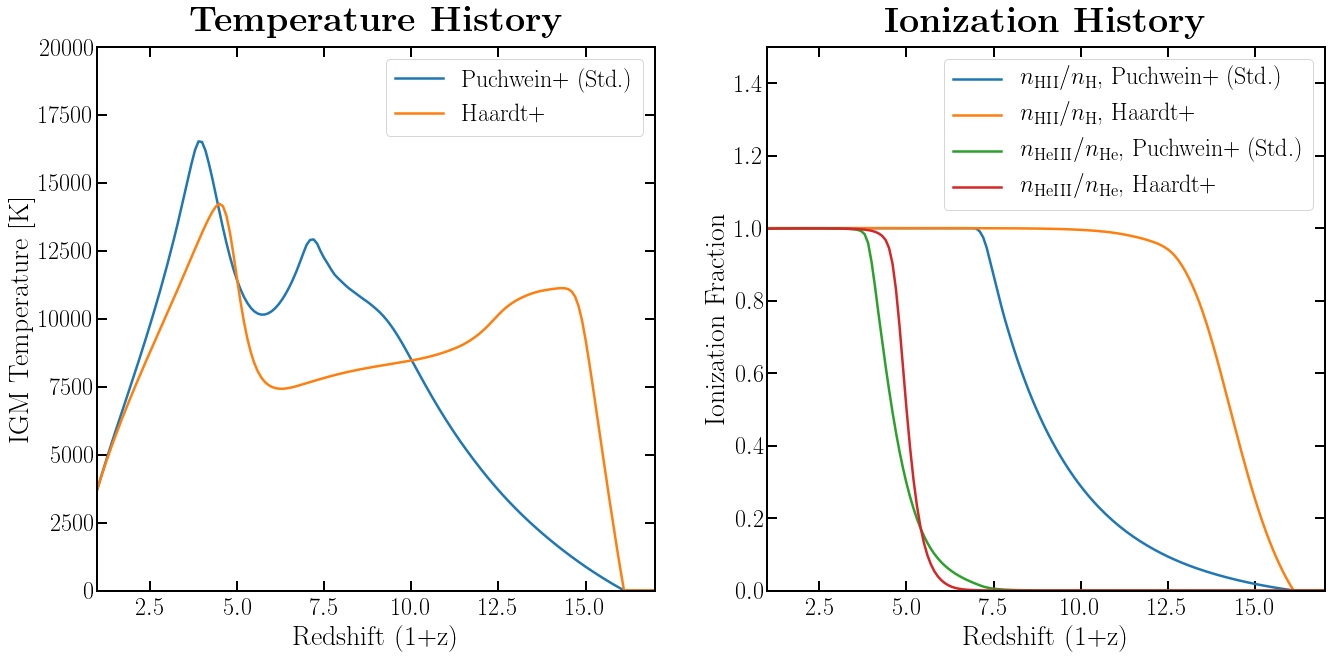

In [11]:
plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)

T_IGM_Puchwein, = plt.plot(rs_vec_reion, soln_with_reion[:,0]/phys.kB, label='Puchwein+ (Std.)')
T_IGM_Haardt, = plt.plot(rs_vec_reion, soln_with_reion_2[:,0]/phys.kB, label='Haardt+')

plt.legend(handles=[T_IGM_Puchwein, T_IGM_Haardt])


plt.title(r'\bf{Temperature History}')
plt.xlabel('Redshift (1+z)')
plt.ylabel('IGM Temperature [K]')
plt.axis([1, 17, 0, 20000])

ax = plt.subplot(1,2,2)

xHII_Puchwein, = plt.plot(rs_vec_reion, soln_with_reion[:,1], label=r'$n_\mathrm{HII}/n_\mathrm{H}$, Puchwein+ (Std.)')
xHII_Haardt, = plt.plot(rs_vec_reion, soln_with_reion_2[:,1], label=r'$n_\mathrm{HII}/n_\mathrm{H}$, Haardt+')
xHeIII_Puchwein, = plt.plot(rs_vec_reion, soln_with_reion[:,3]/(phys.nHe/phys.nH), label=r'$n_\mathrm{HeIII}/n_\mathrm{He}$, Puchwein+ (Std.)')
xHeIII_Haardt, = plt.plot(rs_vec_reion, soln_with_reion_2[:,3]/(phys.nHe/phys.nH), label=r'$n_\mathrm{HeIII}/n_\mathrm{He}$, Haardt+')

plt.legend(handles=[xHII_Puchwein, xHII_Haardt, xHeIII_Puchwein, xHeIII_Haardt], loc=1)

plt.title(r'\bf{Ionization History}')
plt.xlabel('Redshift (1+z)')
plt.ylabel('Ionization Fraction')
plt.axis([1, 17, 0, 1.5])


## Dark Matter

Now, we will introduce dark matter into the TLA equations. We introduce a dark matter species with mass $m_\chi = $ 100 MeV that decays with some (long) lifetime into an $e^+e^-$ pair. The energy injection rate is:

$$ \left( \frac{dE}{dV \, dt} \right)_{\text{inj.}} = \frac{\rho_{\text{DM},0}}{\tau} (1 + z)^3  $$

where $\tau$ is the lifetime, and $\rho_{\text{DM},0}$ is the dark matter density today. 

`get_history` requires four inputs in order to solve the TLA with DM injection: three functions that describe $f_c(z)$ as a function of redshift, $x_\mathrm{HI}$, $x_\mathrm{HeI}$ and $x_\mathrm{HeII}$, with $c$ indexing hydrogen ionization, hydrogen excitation and collisional heating, as well as the dark matter energy injection rate.

In this example, we will use the $f_c(z)$ computed in <cite data-cite="6232408/S55R7ACJ"></cite>, which assumes the default RECFAST ionization history and is therefore only dependent on redshift <span style="color:red">(HL: this needs to be true eventually)</span>. We will show in Example <span style="color:red">(HL: specify)</span> the histories with the same DM parameters, but with $f_c(z)$ computed with backreaction fully taken into account.

First, let's define the $f_c(z)$ functions.


In [12]:
# Import f's

from scipy.interpolate import interp2d

mDM = 1e8

fz_elec_decay = np.loadtxt('/Users/hongwan/Dropbox (MIT)/21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}


def f_H_ion(rs, xHI, xHeI, xHeII):
    
    interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['H_ion'])
    return 10**interp_func(np.log10(mDM), np.log10(rs))

def f_H_exc(rs, xHI, xHeI, xHeII):
    interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['H_exc'])
    return 10**interp_func(np.log10(mDM), np.log10(rs))

def f_heating(rs, xHI, xHeI, xHeII):
    interp_func = interp2d(log10eng, log10rs, log10f_elec_decay['heating'])
    return 10**interp_func(np.log10(mDM), np.log10(rs))


Next, we define the function that returns the DM energy injection rate. This function should only depend on redshift. Here, we have chosen decaying dark matter with a lifetime of $\tau = 10^{25}$ s. These values of $\tau$ and $m_\chi$ are consistent with existing CMB constraints on DM decay <cite data-cite="6232408/VKMX8MFJ"></cite>, and may be able to make an order 10\% contribution to reionization at $z = 6$ [see Fig. 15 of <cite data-cite="6232408/3KKTSI4D"></cite>]. 

In [13]:
# The user may also choose to use `physics.inj_rate` to construct this function.
def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e25
    return phys.rho_DM*rs**3/tau

Now call the solver, with initial conditions and the redshift array. We will first solve it without reionization turned on.

In [14]:
# Initialize the redshift at which we want the solution. 
rs_vec = np.flipud(4.02 + np.arange(0, 2994, 0.1))
# Set the initial conditions. Setting the initial condition to be 1 will result in an error. 
init_cond = [phys.TCMB(2997.92), 1, 0, 0]

print(rs_vec)

# Obtain the solution
soln_DM = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_vec, reion_switch=False)

[2997.92 2997.82 2997.72 ...    4.22    4.12    4.02]


The result is shown below.

[4, 3000.0, 0.0001, 2]

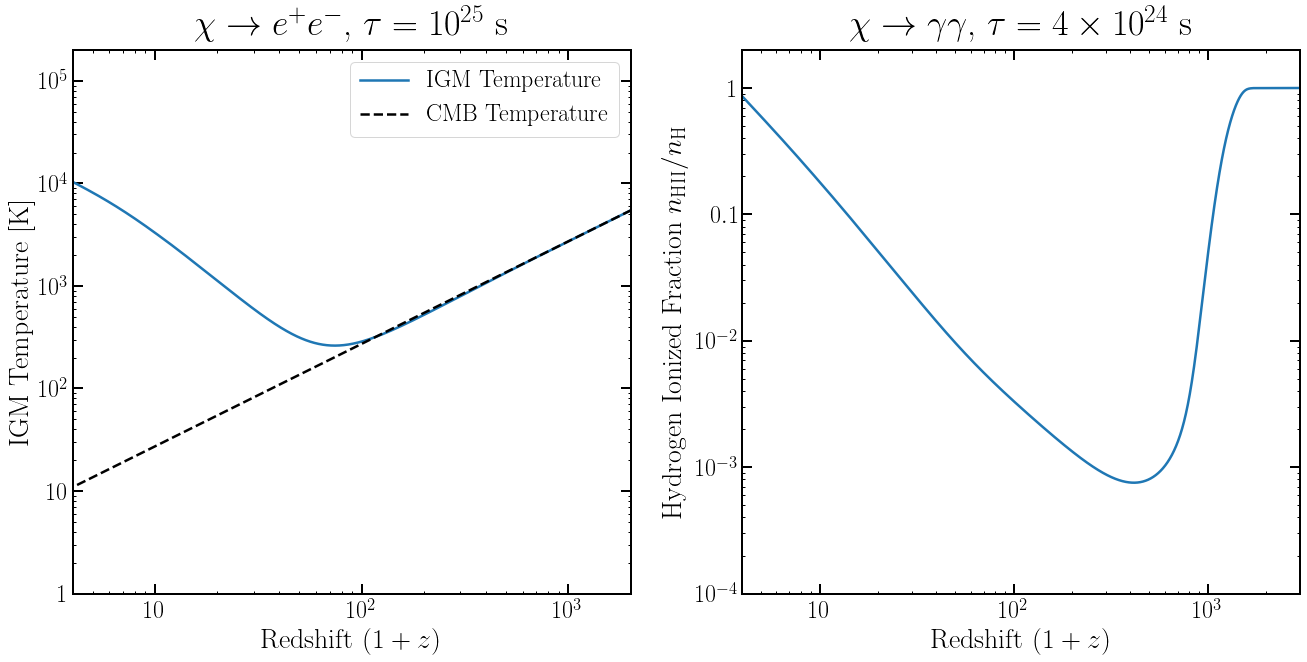

In [15]:
soln_Tm = soln_DM[:,0]/phys.kB
soln_xHII = soln_DM[:,1]

plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)

T_IGM, = plt.plot(rs_vec, soln_Tm, label='IGM Temperature')
T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB])


plt.title(r'$\chi \to e^+e^-$, $\tau = 10^{25}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('IGM Temperature [K]')
plt.axis([4, 2e3, 1, 2e5])

ax = plt.subplot(1,2,2)

plt.plot(rs_vec, soln_xHII)

ax.set_xscale('log')
ax.set_yscale('log')


plt.title(r'$\chi \to \gamma \gamma$, $\tau = 4 \times 10^{24}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Hydrogen Ionized Fraction $n_\mathrm{HII}/n_\mathrm{H}$')
plt.axis([4, 3e3, 1e-4, 2])

Of course, DM energy injection can be combined with a reionization model in `get_history`. Here, we solve the TLA again with the standard reionization scenario of the code. 

In [19]:
%autoreload
# Initialize the redshift at which we want the solution. 
rs_vec_DM_reion = np.flipud(4.02 + np.arange(0, 2994, 0.2))
# Set the initial conditions. Setting the initial condition to be 1 will result in an error. 
init_cond = [phys.TCMB(2997.92), 1, 0, 0]

# Obtain the solution
soln_DM_reion = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_vec_DM_reion, reion_switch=True, mxstep=0)

16.1 0.13731956360928632 0.07652840216735979 9.999986949615902e-13 9.999986949615902e-13
16.099999999997696 0.13731956360943912 0.07652840216740664 1.003308547353754e-12 9.999986949615902e-13
16.099999999997696 0.13731956360943912 0.07652840216740664 1.00330160845985e-12 9.999986949615902e-13
16.09999999999948 0.13731956360932102 0.07652840216737045 1.0007480955032122e-12 9.999986949615902e-13
16.09999999999948 0.13731956360932102 0.07652840216737045 1.0007480955032122e-12 9.999986949615902e-13
16.099999999998957 0.1373195636093557 0.0765284021673811 1.001504434938738e-12 9.999986949615902e-13
16.099999999998957 0.1373195636093557 0.0765284021673811 1.0014974960448342e-12 9.999986949615902e-13
16.09999999999791 0.13731956360942507 0.07652840216740237 1.003003236021982e-12 9.999986949615902e-13
16.09999999999791 0.13731956360942507 0.07652840216740237 1.003003236021982e-12 9.999986949615902e-13
16.09999999999686 0.13731956360949443 0.07652840216742363 1.004502037105226e-12 9.99998694961

16.099999990125564 0.13731956426337094 0.0765284023678739 1.515716024913516e-11 9.999986949615902e-13
16.099999990125564 0.13731956426337094 0.0765284023678739 1.5157153310241256e-11 9.999986949615902e-13
16.09999998964859 0.13731956429496567 0.07652840237755948 1.5841002121153025e-11 9.999986949615902e-13
16.09999998964859 0.13731956429496567 0.07652840237755948 1.584099518225912e-11 9.999986949615902e-13
16.099999989171618 0.1373195643265604 0.07652840238724501 1.652484399317089e-11 9.999986949615902e-13
16.099999989171618 0.1373195643265604 0.07652840238724501 1.6524837054276986e-11 9.999986949615902e-13
16.099999988538222 0.13731956436851633 0.07652840240010689 1.7432950916163037e-11 9.999986949615902e-13
16.099999988538222 0.13731956436851633 0.07652840240010689 1.7432943977269133e-11 9.999986949615902e-13
16.099999987904827 0.13731956441047227 0.07652840241296877 1.834107171694299e-11 9.999986949615902e-13
16.099999987904827 0.13731956441047227 0.07652840241296877 1.8341050900261

16.099999821482445 0.13731957543426432 0.07652840579238879 2.5694275179732884e-10 9.999986949615902e-13
16.099999821482445 0.13731957543426432 0.07652840579238879 2.5694257138608734e-10 9.999986949615902e-13
16.099999813520053 0.137319575961692 0.0765284059540754 2.6835848127015893e-10 9.999986949615902e-13
16.099999813520053 0.137319575961692 0.0765284059540754 2.6835834943117476e-10 9.999986949615902e-13
16.099999805557662 0.1373195764891197 0.07652840611576206 2.7977422462077683e-10 9.999986949615902e-13
16.099999805557662 0.1373195764891197 0.07652840611576206 2.797741205373683e-10 9.999986949615902e-13
16.099999795034865 0.13731957718614818 0.07652840632944097 2.9486097591346905e-10 9.999986949615902e-13
16.099999795034865 0.13731957718614818 0.07652840632944097 2.9486076080775803e-10 9.999986949615902e-13
16.099999784512068 0.13731957788317667 0.07652840654311988 3.09947817411782e-10 9.999986949615902e-13
16.099999784512068 0.13731957788317667 0.07652840654311988 3.09947401078147

16.099996355430736 0.13731980502504054 0.07652847617505593 5.226265038793532e-09 9.999986949615902e-13
16.099996355430736 0.13731980502504054 0.07652847617505593 5.226260979540598e-09 9.999986949615902e-13
16.099996189299016 0.13731981602958362 0.07652847954857717 5.4644494137945365e-09 9.999986949615902e-13
16.099996189299016 0.13731981602958362 0.07652847954857717 5.46444613169772e-09 9.999986949615902e-13
16.099996023167296 0.13731982703412685 0.07652848292209852 5.7026338581844804e-09 9.999986949615902e-13
16.099996023167296 0.13731982703412685 0.07652848292209852 5.702631318549312e-09 9.999986949615902e-13
16.099995857035577 0.13731983803867018 0.07652848629561998 5.940818538496817e-09 9.999986949615902e-13
16.099995857035577 0.13731983803867018 0.07652848629561998 5.940816533156479e-09 9.999986949615902e-13
16.0999956387766 0.13731985249611642 0.07652849072765372 6.253740997275159e-09 9.999986949615902e-13
16.0999956387766 0.13731985249611642 0.07652849072765372 6.253736931083331

16.099942014104332 0.13732340459426012 0.07652957965417834 8.313665235404333e-08 9.999986949615902e-13
16.099939536561937 0.13732356870698922 0.07652962996461948 8.66888228978624e-08 9.999986949615902e-13
16.099939536561937 0.13732356870698922 0.07652962996461948 8.668878893197673e-08 9.999986949615902e-13
16.099937059019542 0.13732373281974727 0.0765296802750925 9.024095497939255e-08 9.999986949615902e-13
16.099937059019542 0.13732373281974727 0.0765296802750925 9.02409280564842e-08 9.999986949615902e-13
16.099933823867392 0.1373239471167259 0.07652974597009476 9.487933125967851e-08 9.999986949615902e-13
16.099933823867392 0.1373239471167259 0.07652974597009476 9.487927758039527e-08 9.999986949615902e-13
16.099930588715242 0.1373241614137539 0.07652981166515122 9.951773267957709e-08 1.0000056338554941e-12
16.099930588715242 0.1373241614137539 0.07652981166515122 9.951763287052717e-08 1.0000056338554941e-12
16.099927353563093 0.13732437571083123 0.07652987736026184 1.0415606301744651e-

16.099101140474875 0.13737910583448576 0.07654665675621164 1.2888590810722356e-06 1.0042661147124932e-12
16.099056236266907 0.13738208047758366 0.07654756880802416 1.3532550484571249e-06 1.004724081710151e-12
16.099056236266907 0.13738208047758366 0.07654756880802416 1.3532543972766264e-06 1.004724081710151e-12
16.09901133205894 0.13738505513019159 0.07654848087027644 1.4176516938621542e-06 1.0052028653895206e-12
16.09901133205894 0.13738505513019159 0.07654848087027644 1.4176504996507577e-06 1.0052028653895206e-12
16.09896642785097 0.1373880297923097 0.07654939294296859 1.482048218377774e-06 1.005702465750602e-12
16.09896642785097 0.1373880297923097 0.07654939294296859 1.482047388229324e-06 1.005702465750602e-12
16.098921523643003 0.1373910044639382 0.07655030502610072 1.5464457256836317e-06 1.006222882793395e-12
16.098921523643003 0.1373910044639382 0.07655030502610072 1.5464450454708012e-06 1.006222882793395e-12
16.098876619435035 0.1373939791450772 0.07655121711967283 1.61084400691

16.091085986002412 0.13791021407946352 0.07670961846030161 1.2795207073347525e-05 1.448112463275919e-12
16.091085986002412 0.13791021407946336 0.07670961846030161 1.279520339903667e-05 1.448112463275919e-12
16.09073721002005 0.13793333191777146 0.07671671722854062 1.3296454478492481e-05 1.484021239228639e-12
16.09073721002005 0.13793333191777135 0.07671671722854057 1.3296451530246667e-05 1.484021239228639e-12
16.090288277215297 0.13796308927478076 0.07672585545478039 1.3941714714672815e-05 1.5322881852242176e-12
16.090288277215297 0.1379630892747805 0.07672585545478033 1.394170906802994e-05 1.5322881852242176e-12
16.089839344410546 0.13799284758533967 0.0767349947263809 1.4587053699499641e-05 1.5828519051019896e-12
16.089839344410546 0.13799284758533906 0.07673499472638079 1.4587043494537766e-05 1.5828519051019896e-12
16.089390411605795 0.13802260684960194 0.0767441350434393 1.5232461949378495e-05 1.6357193377558588e-12
16.089390411605795 0.13802260684960166 0.07674413504343924 1.52324

15.999419983613523 0.14400610786667897 0.07859717658268839 0.0001461461326483643 5.953455783913597e-11
15.999419983613523 0.1440061078667272 0.0785971765826981 0.00014614620613684348 5.953458559471159e-11
15.994502722883194 0.14433426025414683 0.07869967924523474 0.00015339215011354879 6.546777703286821e-11
15.994502722883194 0.14433426025416418 0.07869967924523819 0.00015339220068955745 6.546779784954992e-11
15.989585462152865 0.14466253106551033 0.07880230990806342 0.00016064771144297385 7.169415061625273e-11
15.989585462152865 0.144662531065538 0.07880230990806897 0.00016064775047315571 7.169417143293444e-11
15.984668201422537 0.14499092051141385 0.07890506870889163 0.00016791284591927136 7.821461533996654e-11
15.984668201422537 0.1449909205114312 0.07890506870889508 0.00016791287370711977 7.821462921775435e-11
15.979750940692208 0.1453194288028204 0.07900795578589964 0.00017518756814079162 8.503011489358059e-11
15.979750940692208 0.1453194288028291 0.07900795578590136 0.00017518758

15.298146243912685 0.19210535804948548 0.0945807482286744 0.0012849699925170238 4.385743511414741e-09
15.298146243912685 0.1921053580509795 0.09458074822849089 0.001284969991723818 4.38574349059806e-09
15.28556624528666 0.1929938139726103 0.09489409148464328 0.0013075225240096258 4.538705376810892e-09
15.28556624528666 0.19299381397276583 0.09489409148461353 0.0013075225230474857 4.538705369871998e-09
15.272986246660635 0.19388321506382328 0.09520843322128114 0.0013301574998732385 4.69479516373994e-09
15.272986246660635 0.19388321506382147 0.09520843322128231 0.0013301574990210313 4.694795156801046e-09
15.26040624803461 0.194773565518722 0.09552377678591673 0.0013528752864311391 4.854041238400164e-09
15.26040624803461 0.1947735655187201 0.0955237767859175 0.0013528752856404522 4.85404123146127e-09
15.247826249408584 0.19566486954673726 0.09584012554371385 0.0013756762508489867 5.016472272301176e-09
15.247826249408584 0.1956648695467356 0.09584012554371463 0.0013756762501166003 5.016472

13.33421920793841 0.34551164236156157 0.15820182282335132 0.006078668885771396 9.370589069274127e-08
13.33421920793841 0.3455116423563035 0.15820182282835693 0.0060786688751843995 9.370589032497989e-08
13.31833422044986 0.3469097877572261 0.15886356418513609 0.006130574739943884 9.530409508101689e-08
13.31833422044986 0.3469097877495027 0.15886356419130765 0.006130574724887539 9.530409455366096e-08
13.302449232961308 0.34831108672791755 0.15952816890965738 0.006182740882887984 9.692422579810067e-08
13.302449232961308 0.34831108671984073 0.15952816891589988 0.006182740868108862 9.692422527074473e-08
13.270679257984208 0.3511231935798156 0.16086602298701275 0.006287859400686956 1.0023133086012326e-07
13.270679257984208 0.35112473776047964 0.1608665586533478 0.006287916283217225 1.002351547735314e-07
13.270679257984208 0.35112319359264665 0.16086602297697417 0.006287859424603456 1.002313317205461e-07
13.270679257984208 0.3511249093273684 0.16086661817864506 0.006287922587389701 1.00235579

11.684649224078358 0.5160271126720233 0.2476342635550291 0.013418131870166071 4.965629151407192e-07
11.684649224078358 0.5160270424590362 0.24763427238673635 0.013418130931447333 4.965631923078972e-07
11.606904105868093 0.5254428482712574 0.25308984375239746 0.013880746872511982 5.363551160431079e-07
11.606904105868093 0.5254427121412304 0.25308986001299383 0.013880745316495417 5.363556010995474e-07
11.529158987657828 0.5349826262159576 0.2586781854192382 0.01435569272562099 5.7928071843516e-07
11.529158987657828 0.5349824690166943 0.2586782025076787 0.014355691341226468 5.792811640925599e-07
11.451413869447563 0.544645195118354 0.2644021756193269 0.01484322039514685 6.255767238463883e-07
11.451413869447563 0.5446616539153114 0.2644082311133975 0.014843771905987426 6.258676351900139e-07
11.451413869447563 0.5446612804149554 0.2644081596552157 0.014843762204951962 6.258551492333009e-07
11.507835819258771 0.5376204793977732 0.2602344941795425 0.014488142520747021 5.916328600086285e-07
11

10.472269608944051 0.6810689859444248 0.35184814924634356 0.022396095955509853 1.873752381392757e-06
10.472269608944051 0.681068985947202 0.35184814924728036 0.02239609595564136 1.8737523819964408e-06
10.453477169564348 0.6839041803113404 0.3538380144498811 0.022569638619471154 1.9185749394537432e-06
10.453477169564348 0.6839041783556666 0.3538380144848484 0.0225696386223956 1.9185749512221073e-06
10.434684730184644 0.6867458920167845 0.35584194551643533 0.022744471906946857 1.964835718751279e-06
10.434684730184644 0.6867458846392117 0.3558419456449111 0.022744471917108808 1.9648357519400084e-06
10.41589229080494 0.6895935926825127 0.35785999879263986 0.02292059952270003 2.012577322560438e-06
10.41589229080494 0.6895935843036395 0.357859998936254 0.02292059953382148 2.012577360509249e-06
10.397099851425237 0.6924467449640231 0.35989222928100617 0.023098025013264873 2.061843577476352e-06
10.397099851425237 0.69244673645398 0.35989222942543864 0.023098025024315825 2.061843619616255e-06
1

9.099770528558212 0.8663739799047387 0.5393612965092691 0.03884403224977554 1.523263492634458e-05
9.03010385880513 0.8728087340362527 0.5514763459840157 0.0399025526522602 1.723685311415951e-05
9.03010385880513 0.8728802636962748 0.5515039784742397 0.039905498161202584 1.7241922938920906e-05
9.03010385880513 0.8728744859628174 0.5515036728468459 0.03990545013013609 1.724168715951102e-05
9.082353861119941 0.8680181675129975 0.5423667268168225 0.03910680687086654 1.570930655602626e-05
9.082353861119941 0.868018160051358 0.5423667273490347 0.03910680687530191 1.570930634750556e-05
9.06493719368167 0.8696385440814031 0.5453878186489978 0.039370831642757884 1.6201885386771253e-05
9.06493719368167 0.8696408076926929 0.5453886806074658 0.03937092376200575 1.6202036113334428e-05
9.06493719368167 0.8696385434360633 0.5453878185194505 0.03937083163978708 1.620188535021716e-05
9.06493719368167 0.8696410596477638 0.5453887764672433 0.03937093399946311 1.6202052885772034e-05
9.078870527632287 0.868

8.235696920846086 0.9414337632616179 0.71517690813679 0.05416249613163775 7.91684106169338e-05
8.235696920846086 0.9414337642967101 0.7151769082496006 0.05416249612544965 7.916841060220947e-05
8.226715900754051 0.9422300117876413 0.7172962529509692 0.05434641789587459 8.062601650185575e-05
8.226715900754051 0.9422300159185552 0.7172962534041407 0.05434641787069177 8.062601644234085e-05
8.217734880662016 0.9430396331586647 0.7194262733023307 0.05453128846956991 8.211335806571768e-05
8.217734880662016 0.943039637782385 0.7194262738241529 0.05453128843994678 8.211335799866021e-05
8.208753860569981 0.9438619800150331 0.7215668097884996 0.05471708795419526 8.363104312023723e-05
8.208753860569981 0.9438619845645765 0.7215668103182724 0.054717087923357194 8.363104305408181e-05
8.17193424953599 0.9473529268477836 0.7304487003879927 0.055488078479029895 9.018368505377128e-05
8.17193424953599 0.9473530874722854 0.7304487205223799 0.055488077165786895 9.018368274060773e-05
8.135114638502 0.951005

7.491978424912836 1.0346884701553323 0.915743753941296 0.07123463305291716 0.0004044350550515899
7.491978424912836 1.0346884698061007 0.9157437540472366 0.07123463303547814 0.00040443505490141834
7.491114772229032 1.0348056156936551 0.9159797041259694 0.07125367501656871 0.00040527378693842875
7.491114772229032 1.034805615001396 0.915979704338809 0.07125367498304647 0.00040527378663472724
7.490251119545229 1.0349224851514924 0.9162154293351018 0.07127269184315527 0.0004061143436753997
7.490251119545229 1.0349224844602598 0.9162154295470629 0.07127269180940486 0.00040611434337120556
7.488523814177621 1.0351553922538532 0.9166861991866703 0.0713106497325775 0.0004078009466055646
7.488523814177621 1.0351569686771467 0.9166869069659767 0.07131072374649197 0.0004078015858434286
7.488523814177621 1.0351553940960503 0.9166861986246982 0.07131064982209658 0.0004078009474199479
7.488523814177621 1.035157283038546 0.9166870488029089 0.07131073850426889 0.0004078017132835704
7.489905658471707 1.0

7.139403654642063 1.0693169494450154 0.992851940026586 0.07708141530414239 0.0010159252782867556
7.139167079273727 1.069292573070883 0.9928702262202005 0.07708230048529514 0.0010165773806983525
7.139167079273727 1.0692925730690301 0.9928702262201732 0.07708230048520696 0.0010165773806978043
7.1389305039053905 1.06926829074303 0.9928885540844459 0.0770831918721144 0.0010172295732497894
7.1389305039053905 1.0692682907411832 0.9928885540844139 0.07708319187202631 0.0010172295732492412
7.136564750222027 1.0690304658730694 0.9930740479727023 0.0770924380965271 0.0010237564805726518
7.136564750222027 1.0690304650388995 0.9930740479308049 0.07709243805275126 0.0010237564803131094
7.134198996538663 1.0688011521800596 0.9932633164789633 0.07710225903321703 0.001030292518956387
7.134198996538663 1.0688011527789163 0.9932633162522158 0.07710225903039827 0.0010302925190054935
7.131833242855299 1.0685795009649253 0.993455979623185 0.0771126112071566 0.001036837791435409
7.131833242855299 1.06857950

6.947228297746704 1.0361347136511645 0.9998709030725086 0.07732522604801578 0.0015779202821773405
6.945802650443149 1.0358056174278436 0.9998740787699857 0.0773217015443467 0.0015823329767763877
6.945802650443149 1.0358056173547396 0.999874078766575 0.07732170153509083 0.0015823329766597588
6.944448264471446 1.0354929924379168 0.9998770204756896 0.07731833227991881 0.0015865285596896941
6.944448264471446 1.0354929936016284 0.9998770204998545 0.07731833241118884 0.0015865285689768277
6.943093878499743 1.0351803935998625 0.9998798908235453 0.0773149430346296 0.0015907275241078059
6.943093878499743 1.0351803960327393 0.9998798908822095 0.07731494333861667 0.0015907275427436765
6.941739492528041 1.0348678266160916 0.9998826917124773 0.0773115343354365 0.0015949298852430197
6.941739492528041 1.0348678290157678 0.9998826917720305 0.07731153464340795 0.0015949299038123463
6.940471316060769 1.0345751871582485 0.9998852529499784 0.0773083252208526 0.0015988678357203023
6.940471316060769 1.03457

6.8997351014523876 1.025209210540702 0.9999431291718623 0.07719769335119225 0.0017269752515816639
6.8997351014523876 1.0252092106647113 0.9999431291729111 0.07719769336480752 0.001726975253349236
6.899092923580069 1.02506232159665 0.9999437504144171 0.07719584986518982 0.0017290203103798932
6.899092923580069 1.0250623217197727 0.9999437504154529 0.07719584987874382 0.0017290203121445025
6.898470921377778 1.0249200756501913 0.9999443455709347 0.0771940617795945 0.0017310018887295164
6.898470921377778 1.0249200757629877 0.9999443455718805 0.07719406179200397 0.0017310018903562222
6.8978489191754875 1.0247778575568038 0.9999449343366003 0.0771922712310624 0.0017329842255569827
6.8978489191754875 1.0247778576665827 0.9999449343374889 0.07719227124300868 0.0017329842271550863
6.897226916973197 1.024635667529453 0.9999455167822315 0.0771904782347197 0.0017349673216010553
6.897226916973197 1.0246356676384816 0.9999455167831095 0.07719047824661328 0.0017349673231965707
6.896623763448304 1.0244

6.874150980350849 1.0193821095132651 0.9999632407369141 0.077122354661601 0.0018090817894809014
6.873735715241913 1.0192879833132382 0.9999634995779926 0.0771211021130351 0.0018104253134739526
6.873735715241913 1.019287983337434 0.9999634995781035 0.07712110211531074 0.0018104253139203108
6.873320450132977 1.0191938727505183 0.9999637565808194 0.07711984868865951 0.001811769187965953
6.873320450132977 1.0191938727746215 0.9999637565809294 0.07711984869092733 0.0018117691884118325
6.872913717205321 1.0191017109967835 0.9999640065339093 0.07711862016928395 0.0018130857903004144
6.872913717205321 1.0191017110195715 0.9999640065340132 0.07711862017142412 0.0018130857907233122
6.872506984277666 1.0190095643077994 0.9999642547486028 0.07711739081308235 0.0018144027288223563
6.872506984277666 1.0190095643302242 0.9999642547487027 0.07711739081517205 0.0018144027292404247
6.872100251350011 1.0189174327272648 0.9999645012372288 0.0771161606228093 0.001815720003738877
6.872100251350011 1.0189174

6.811874977561646 1.0054628276160427 0.9999872227546021 0.0769259960819044 0.0020145923449589806
6.811874977561646 1.0054628276160427 0.9999872227546021 0.0769259959750993 0.002014592451516091
6.811874977561646 1.0054628276048245 0.9999872227533424 0.07692599594020483 0.0020145923464828727
6.811118240708857 1.005296367385335 0.9999873855290433 0.07692351709916824 0.0020171409306847243
6.810361503856067 1.0051299768724664 0.9999875462307694 0.0769210362711722 0.002019690788855423
6.808848030150489 1.0047974048214081 0.9999878615134651 0.07691606863668848 0.002024794311043021
6.808848030150489 1.0047974197940561 0.9999878615134651 0.07691606863668848 0.002024794311043021
6.808848030150489 1.0047974048214081 0.9999878615155124 0.07691606863668848 0.002024794311043021
6.808848030150489 1.0047974048214081 0.9999878615134651 0.07691606874385598 0.002024794311043021
6.808848030150489 1.0047974048214081 0.9999878615134651 0.07691606863668848 0.0020247944179731386
6.808848030150489 1.0047972087

6.802656114131891 1.0034402409912573 0.9999877922908762 0.07689511067591728 0.002045734503627085
6.802656114131891 1.0034402409912573 0.9999877922888182 0.07689511078384713 0.002045734503627085
6.802656114131891 1.0034402409912573 0.9999877922888182 0.07689511067591728 0.0020457346113200575
6.800987507214441 1.0030761275608124 0.9999878201333874 0.07688946096200575 0.002051394009799236
6.799318900296991 1.0027126754288462 0.999987847954886 0.07688380415907367 0.0020570605761514593
6.7961625598088755 1.002026977076044 0.9999879005187855 0.07687308444824739 0.0020677987069019563
6.7961625598088755 1.0020269920074094 0.9999879005187855 0.07687308444824739 0.0020677987069019563
6.7961625598088755 1.002026977076044 0.999987900520827 0.07687308444824739 0.0020677987069019563
6.7961625598088755 1.002026977076044 0.9999879005187855 0.07687308455697445 0.0020677987069019563
6.7961625598088755 1.002026977076044 0.9999879005187855 0.07687308444824739 0.0020677988153947127
6.7961625598088755 1.002

6.489814221752786 0.9465880526863509 0.9999926064517228 0.07569178307211659 0.0032507152312403267
6.489741194537994 0.9465774422462645 0.9999926073444532 0.07569146295163764 0.003251035621354696
6.489741194537994 0.9465774422396162 0.9999926073399836 0.07569146295081361 0.0032510356213546407
6.489668167323202 0.946566832990095 0.9999926082116839 0.07569114278703164 0.003251356037422201
6.489668167323202 0.9465668329869514 0.9999926082094989 0.07569114278668984 0.003251356037422208
6.489595140108411 0.9465562249405017 0.9999926090660467 0.07569082258285001 0.0032516764794454783
6.489595140108411 0.9465562249389604 0.9999926090651048 0.07569082258259552 0.0032516764794454853
6.489492643714387 0.9465413382048102 0.9999926102528396 0.0756903731021446 0.003252126275449102
6.489492643714387 0.9465413382010055 0.999992610250477 0.07569037310154113 0.003252126275449116
6.489390147320363 0.9465264538792016 0.9999926114286518 0.07568992355292836 0.003252576122595059
6.489390147320363 0.946526453

6.218361252275961 0.9158641988219534 0.9999957080786093 0.07429838878180234 0.004644760697355324
6.211967644371469 0.9153549504111742 0.9999957814844089 0.07426003065852549 0.004683134246887606
6.2055740364669765 0.9148558304195205 0.9999958548908356 0.07422138473409584 0.004721795600261605
6.192786820657992 0.9138880637333071 0.9999960016947789 0.07414321978695217 0.004799991413044387
6.192786820657992 0.9138880773513005 0.9999960016947789 0.07414321978695217 0.004799991413044387
6.192786820657992 0.9138880637333071 0.9999960016955194 0.07414321978695217 0.004799991413044387
6.192786820657992 0.9138880637333071 0.9999960016947789 0.07414321997093137 0.004799991413044387
6.192786820657992 0.9138880637333071 0.9999960016947789 0.07414321978695217 0.004799991596936629
6.192786820657992 0.9138880656911683 0.999996001707826 0.07414321981859684 0.004799991380804551
6.197044173604876 0.9142057509332245 0.9999959528219132 0.07416937400465334 0.004773826917807492
6.197044173604876 0.9142057645

6.179704095038374 0.9129401484292886 0.9999961518852185 0.07406202662969616 0.004881216117059849
6.179704095038374 0.9129401484323434 0.9999961518864424 0.07406202663061057 0.004881216117059932
6.179612886169372 0.9129336903072012 0.9999961529197037 0.07406145613500421 0.004881786810109194
6.179612886169372 0.9129336903092372 0.999996152920407 0.07406145613568126 0.004881786810109291
6.17952098398646 0.9129271852507389 0.9999961539612364 0.07406088123026242 0.004882361911631293
6.17952098398646 0.912927185251991 0.9999961539615246 0.07406088123076587 0.004882361911631404
6.179429081803549 0.9129206823603928 0.999996155002141 0.07406030625250207 0.00488293708384261
6.179429081803549 0.9129206823612658 0.9999961550022876 0.07406030625288225 0.004882937083842721
6.179337179620637 0.912914181637625 0.9999961560427216 0.07405973120230411 0.004883512326751729
6.179337179620637 0.912914181638276 0.9999961560428186 0.07405973120258971 0.004883512326751847
6.179245337370328 0.9129076873206946 0

6.018298705594444 0.9049403978519841 0.9999979891977506 0.07293533448963718 0.0060082439305269575
6.012685513157531 0.9047890385181416 0.999998053375329 0.07289161432090871 0.006051975988898457
6.007072320720618 0.9046464636410912 0.9999981175625681 0.07284756572881239 0.006096036484206355
6.001459128283705 0.904512700523467 0.9999981817586954 0.07280318630526272 0.0061404278244241856
6.002724737279601 0.9045420892986347 0.9999981672841762 0.07281322156569486 0.006130389875966348
6.002724737279601 0.9045421027773621 0.9999981672841762 0.07281322156569486 0.006130389875966348
6.002724737279601 0.9045420892986347 0.9999981672845369 0.07281322156569486 0.006130389875966348
6.002724737279601 0.9045420892986347 0.9999981672841762 0.07281322177426458 0.006130389875966348
6.002724737279601 0.9045420892986347 0.9999981672841762 0.07281322156569486 0.006130390084475031
6.002724737279601 0.9045420893124225 0.9999981672863227 0.07281322156569307 0.006130389875968381
6.006202804032415 0.9046251654

5.955691751860683 0.9037544608869928 0.9999987058253212 0.07242868176771884 0.0065150300127155975
5.955691751860683 0.9037544743539837 0.9999987058253212 0.07242868176771884 0.0065150300127155975
5.955691751860683 0.9037544608869928 0.9999987058255826 0.07242868176771884 0.0065150300127155975
5.955691751860683 0.9037544608869928 0.9999987058253212 0.07242868198230262 0.0065150300127155975
5.955691751860683 0.9037544608869928 0.9999987058253212 0.07242868176771884 0.006515030227244319
5.955691751860683 0.903754460908033 0.999998705825457 0.07242868176762446 0.006515030012811264
5.954995761623717 0.9037475472710416 0.9999987138927249 0.07242280864346184 0.00652090462847852
5.954299771386752 0.9037407732034245 0.999998721960399 0.07241693007798325 0.006526784685654444
5.954299771386752 0.9037407732571673 0.9999987219610189 0.07241693007774425 0.006526784685897909
5.953447921138519 0.9037326721328631 0.999998731834868 0.07240972765446388 0.006533988935180091
5.952596070890286 0.90372478032

5.9303404784246005 0.9035930874053032 0.9999989997244374 0.07221120780016646 0.0067325584289441714
5.930291824022569 0.9035929574274217 0.9999990002885363 0.07221078333462956 0.006732982999214862
5.930291824022569 0.9035929708920061 0.9999990002885363 0.07221078333462956 0.006732982999214862
5.930291824022569 0.9035929574274217 0.9999990002887421 0.07221078333462956 0.006732982999214862
5.930291824022569 0.9035929574274217 0.9999990002885363 0.07221078355242341 0.006732982999214862
5.930291824022569 0.9035929574274217 0.9999990002885363 0.07221078333462956 0.006732983216956791
5.930291824022569 0.9035929575265775 0.9999989999123997 0.07221078333462957 0.006732982999215001
5.930291824022569 0.903592957404845 0.9999990003742498 0.07221078333462949 0.006732982999214904
5.930328314824092 0.9035930548459516 0.9999989998654621 0.0722111016863555 0.006732664568938493
5.930328314824092 0.9035930683105374 0.9999989998654621 0.0722111016863555 0.006732664568938493
5.930328314824092 0.90359305484

5.615967231168713 0.9234941852650862 0.9999990000000976 0.06872884934010023 0.0102156209996132
5.615967231168713 0.9234942036914727 0.9999990000000976 0.06872884304532309 0.01021562741597297
5.616815468366521 0.9233805866991635 0.9999990000000976 0.06874059086103129 0.010203877462614478
5.616815468366521 0.92338060187198 0.9999990000000976 0.06874058625211085 0.010203882169545347
5.618837474589789 0.9231111961723238 0.9999990000000976 0.06876852025998129 0.010175943306840941
5.618837474589789 0.9231112099277525 0.9999990000000976 0.06876852025998129 0.010175943306840941
5.618837474589789 0.9231111961723238 0.9999990000003034 0.06876852025998129 0.010175943306840941
5.618837474589789 0.9231111961723238 0.9999990000000976 0.06876852051238914 0.010175943306840941
5.618837474589789 0.9231111961723238 0.9999990000000976 0.06876852025998129 0.010175943559230703
5.618331973033972 0.9231783611067017 0.9999990000000976 0.06876154519111854 0.010182919610778648
5.617826471478155 0.92324564957415 

5.1235019527936405 1.053895044397381 0.9999990000000976 0.05881278834346603 0.020132864231972577
5.1235019527936405 1.0538950286931212 0.9999990000003034 0.05881278834346603 0.020132864231972577
5.1235019527936405 1.0538950286931212 0.9999990000000976 0.05881278858305092 0.020132864231972577
5.1235019527936405 1.0538950286931212 0.9999990000000976 0.05881278834346603 0.020132864471569603
5.1235019527936405 1.053894971566445 0.9999990000000976 0.05881278793844505 0.020132864630955673
5.094660210930705 1.0657880620961921 0.9999990000000976 0.05801633594116093 0.020929381870146556
5.094660210930705 1.0657943967410621 0.9999990000000976 0.05801547328635392 0.020930246018567016
5.109285545487506 1.059695746102566 0.9999990000000976 0.058423506322380796 0.020522178526239273
5.109285545487506 1.0596957618932632 0.9999990000000976 0.058423506322380796 0.020522178526239273
5.109285545487506 1.059695746102566 0.9999990000003034 0.058423506322380796 0.020522178526239273
5.109285545487506 1.059695

4.872198022877629 1.1748375479559185 0.9999990000000976 0.05084108079616009 0.028105123466753375
4.871398417723201 1.1752837012946449 0.9999990000000976 0.050811962658885046 0.02813424304634582
4.870598812568773 1.1757302270463053 0.9999990000000976 0.050782820908198655 0.028163386398129025
4.868999602259918 1.1766243952766344 0.9999990000000976 0.05072446661161291 0.02822174389363688
4.868999602259918 1.1766244128097043 0.9999990000000976 0.05072446661161291 0.02822174389363688
4.868999602259918 1.1766243952766344 0.9999990000003034 0.05072446661161291 0.02822174389363688
4.868999602259918 1.1766243952766344 0.9999990000000976 0.050724466770030244 0.02822174389363688
4.868999602259918 1.1766243952766344 0.9999990000000976 0.05072446661161291 0.02822174405206858
4.868999602259918 1.1766244773802448 0.9999990000000976 0.050724457970847195 0.0282217525923589
4.86976911558299 1.176193950411776 0.9999990000000976 0.050752557499098544 0.028193651467433356
4.86976911558299 1.1761939679384317

4.640363744212513 1.3202017847473149 0.9999990000000976 0.04125521932017089 0.03769141568960599
4.640363744212513 1.3202017847473149 0.9999990000000976 0.041255219293660016 0.03769141571612775
4.63959677300663 1.3207286408963486 0.9999990000000976 0.0412200240501546 0.0377266121856624
4.63959677300663 1.3207286746323472 0.9999990000000976 0.041220020681580656 0.03772661556477065
4.639841756570099 1.3205603274411624 0.9999990000000976 0.04123126814435218 0.037715367691514776
4.639841756570099 1.3205603471190446 0.9999990000000976 0.04123126814435218 0.037715367691514776
4.639841756570099 1.3205603274411624 0.9999990000003034 0.04123126814435218 0.037715367691514776
4.639841756570099 1.3205603274411624 0.9999990000000976 0.04123126817050759 0.037715367691514776
4.639841756570099 1.3205603274411624 0.9999990000000976 0.04123126814435218 0.03771536771768106
4.639841756570099 1.3205603363020546 0.9999990000000976 0.04123126724357853 0.03771536859602426
4.639319768927685 1.3209190099827897 0

4.330017789805772 1.5497415384689337 0.9999990000000976 0.02521792322727403 0.05372913555667594
4.3173528971523485 1.5593831342013098 0.9999990000000976 0.024500275931103092 0.054446796332994735
4.304688004498925 1.5689874940386859 0.9999990000000976 0.023780627006746716 0.05516645841303254
4.292023111845502 1.5785416283267721 0.9999990000000976 0.023059951431756473 0.05588714681358285
4.279358219192079 1.588032447939134 0.9999990000000976 0.02233925008235567 0.056607860653548545
4.264557413391547 1.5990260064760504 0.9999990000000976 0.02149834104220842 0.057448783860020766
4.2497566075910145 1.6098941410841712 0.9999990000000976 0.02066046158398228 0.05828667701457427
4.234955801790482 1.620615869949563 0.9999990000000976 0.019827300995647446 0.059119850823386
4.22015499598995 1.6311704434474743 0.9999990000000976 0.019000564495083496 0.05994660006569892
4.205354190189418 1.6415375783019641 0.9999990000000976 0.018181964676338952 0.06076521214068374
4.205354190189418 1.64157475482872

4.019881125961263 1.7585534953426054 0.9999990000000976 0.007757035636296386 0.07119026799345811
4.021102240099854 1.7579755571717794 0.9999990000000976 0.007816212669411973 0.0711310903703554
4.020980128685995 1.7580335280651767 0.9999990000000976 0.007810285578630526 0.0711370175195822
4.020980128685995 1.7580335542619177 0.9999990000000976 0.007810285578630526 0.0711370175195822
4.020980128685995 1.7580335280651767 0.9999990000003034 0.007810285578630526 0.0711370175195822
4.020980128685995 1.7580335280651767 0.9999990000000976 0.007810285810302776 0.0711370175195822
4.020980128685995 1.7580335280651767 0.9999990000000976 0.007810285578630526 0.0711370177512552
4.020980128685995 1.7580334910448576 0.9999990000000976 0.007810284077852149 0.07113701902082317
4.021102240099854 1.7579755571717794 0.9999990000000976 0.007816212669411973 0.0711310903703554
4.021090028958468 1.7579813542611191 0.9999990000000976 0.007815619780214132 0.0711316832653996
4.021090028958468 1.7579813804570827 0

And plotting the results,

[4, 17, 0.0001, 2.0]

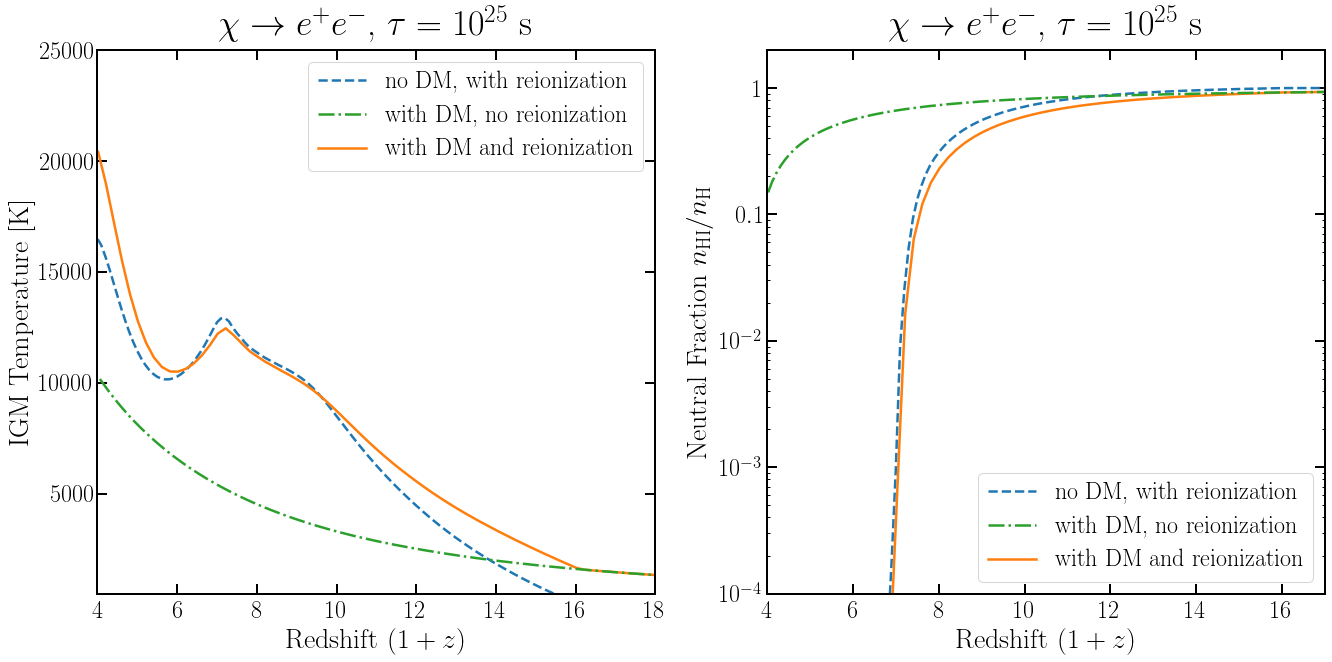

In [21]:
plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)

T_IGM_no_DM_reion, = plt.plot(rs_vec_reion, soln_with_reion[:,0]/phys.kB, label='no DM, with reionization', linestyle='--')
T_IGM_DM_reion, = plt.plot(rs_vec_DM_reion, soln_DM_reion[:,0]/phys.kB, label='with DM and reionization')
T_IGM_DM_no_reion, = plt.plot(rs_vec, soln_DM[:,0]/phys.kB, label='with DM, no reionization', linestyle='-.')


# ax.set_yscale('log')

plt.legend(handles=[T_IGM_no_DM_reion, T_IGM_DM_no_reion, T_IGM_DM_reion])


plt.title(r'$\chi \to e^+e^-$, $\tau = 10^{25}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('IGM Temperature [K]')
plt.axis([4, 18, 5e2, 2.5e4])
# plt.axis([5, 18, 5e2, 2e4])

ax = plt.subplot(1,2,2)

xHI_no_DM_reion, = plt.plot(rs_vec_reion, 1 - soln_with_reion[:,1], label='no DM, with reionization', linestyle='--')
xHI_DM_reion, = plt.plot(rs_vec_DM_reion, 1 - soln_DM_reion[:,1], label='with DM and reionization')
xHI_DM_no_reion, = plt.plot(rs_vec, 1 - soln_DM[:,1], label='with DM, no reionization', linestyle='-.')


ax.set_yscale('log')

plt.legend(handles=[xHI_no_DM_reion, xHI_DM_no_reion, xHI_DM_reion], loc=4)

plt.title(r'$\chi \to e^+e^-$, $\tau = 10^{25}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Neutral Fraction $n_\mathrm{HI}/n_\mathrm{H}$')
plt.axis([4, 17, 1e-4, 2.])




Alternatively, the user can specify their own fixed ionization history, with $T_m$ being the only variable integrated with respect to redshift. As before, the user must specify `reion_rs`, the redshift at which the reionization model starts, and a function for $x_e$. Here, we choose the standard $\tanh$ model matched onto the standard ionization history saved in `soln_xHII` above.

In [22]:
# Define the standard ionization history as an interpolation function for convenience. 

def xe_reion_func(rs):
    # Parameters of the model.
    
    f = 1.08
    delta_z = 0.5
    delta_y = 1.5*rs**0.5*delta_z
    z_re = 8.8
    y = rs**(3/2)
    y_re = (1 + z_re)**(3/2)
    
    reion_model_xe = (f/2)*(1 + np.tanh((y_re - y)/delta_y))
    reion_model_xe[reion_model_xe > 1] == 1.0
    
    return reion_model_xe

In [23]:
def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e25
    return phys.rho_DM*rs**3/tau

# Initialize the redshift at which we want the solution. 
rs_vec = np.flipud(1 + np.arange(1, 3000, 0.1))

# Set the initial conditions. The initial temperature is the CMB temperature, 
# and the initial free electron fraction is 1. 
init_cond = [phys.TCMB(rs_vec[0]), 1, 0, 0]

# Obtain the solution.
soln_with_reion = tla.get_history(
    init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_vec, reion_switch=True, 
    reion_rs = 10., xe_reion_func = xe_reion_func
)

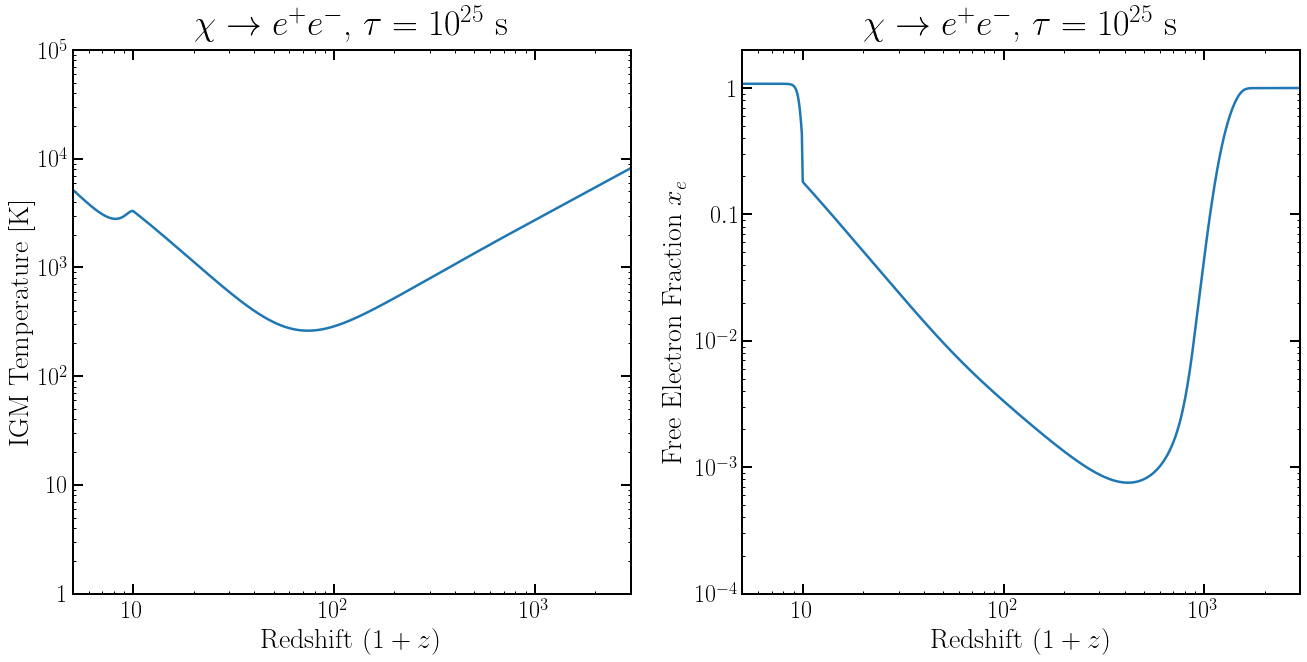

In [24]:
plt.figure(figsize=(22,10))

ax = plt.subplot(1,2,1)


plt.plot(rs_vec, soln_with_reion[:,0]/phys.kB)

plt.axis([5, 3000, 1, 1e5])
plt.title(r'$\chi \to e^+e^-$, $\tau = 10^{25}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel('IGM Temperature [K]')

ax.set_xscale('log')
ax.set_yscale('log')

ax = plt.subplot(1,2,2)

plt.plot(rs_vec, soln_with_reion[:,1])

plt.axis([5, 3000, 1e-4, 2])

plt.title(r'$\chi \to e^+e^-$, $\tau = 10^{25}$ s')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'Free Electron Fraction $x_e$')


ax.set_xscale('log')
ax.set_yscale('log')

## Bibliography

<div class="cite2c-biblio"></div>